In [1]:
import pyarrow.dataset as ds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
from statsmodels.stats import stattools
from scipy import stats
import seaborn as sns

In [3]:
from RiskLabAI.controller import Controller

# initialize controller
controller = Controller()

In [24]:
import optuna
from optuna.samplers import TPESampler
from optuna.exceptions import TrialPruned
import torch
print(torch.backends.mps.is_available())

True


# Load Datasets

In [5]:
#Asset under study
ticker = 'BTCUSDT'

# define dataset
dataset = ds.dataset(
    "/Users/bobet/Documents/Code Repository/Trading-Systems/_datasets",
    format="parquet")

# push filter into Arrow scan (faster, uses partition pruning if possible)
table = dataset.to_table(filter=ds.field("symbol") == ticker)

# convert to pandasssss
df = table.to_pandas()
df.tail()

,symbol,ts_ms,iso_utc,ohlc_ts_open,ohlc_open,ohlc_high,ohlc_low,ohlc_close,ohlc_volume,ohlc_ts_close,...,tr_volume_base,tr_volume_quote,tr_vwap,tr_buy_sell_imbalance,spot_price,perp_mark_price,basis_abs,basis_pct,funding_rate,next_funding_time_ms
29396,BTCUSDT,1757235398782,2025-09-07T08:56:38.782629+00:00,1757235360000,111064.48,111064.49,111056.56,111056.57,2.20840,1757235419999,...,13.34440,1.482838e+06,111120.587469,-0.743010,111056.56,111012.000000,-44.560000,-0.000401,0.000057,1757260800000
29397,BTCUSDT,1757235458832,2025-09-07T08:57:38.832643+00:00,1757235420000,111056.57,111056.57,111056.56,111056.57,1.36043,1757235479999,...,14.19905,1.577770e+06,111118.009205,-0.770104,111056.57,111009.024457,-47.545543,-0.000428,0.000057,1757260800000
29398,BTCUSDT,1757235518882,2025-09-07T08:58:38.882621+00:00,1757235480000,111056.56,111056.57,111056.56,111056.57,1.23647,1757235539999,...,8.16041,9.065610e+05,111092.576224,-0.587442,111056.57,111003.800000,-52.770000,-0.000475,0.000058,1757260800000
29399,BTCUSDT,1757235578942,2025-09-07T08:59:38.942235+00:00,1757235540000,111056.57,111071.25,111056.56,111071.25,8.48946,1757235599999,...,7.84490,8.714298e+05,111082.330495,-0.861344,111071.25,111035.600000,-35.650000,-0.000321,0.000058,1757260800000
29400,BTCUSDT,1757235638992,2025-09-07T09:00:38.992628+00:00,1757235600000,111071.25,111071.25,111071.24,111071.25,2.93395,1757235659999,...,8.17185,9.075995e+05,111064.142909,-0.800718,111071.25,111028.000000,-43.250000,-0.000389,0.000058,1757260800000


In [6]:
#features
df.columns

Index(['symbol', 'ts_ms', 'iso_utc', 'ohlc_ts_open', 'ohlc_open', 'ohlc_high',
       'ohlc_low', 'ohlc_close', 'ohlc_volume', 'ohlc_ts_close', 'ohlc_trades',
       'ohlc_taker_base', 'ohlc_taker_quote', 'l1_bid', 'l1_ask', 'l1_mid',
       'l1_spread', 'l1_bid_qty', 'l1_ask_qty', 'l1_imbalance', 'l2_bid_depth',
       'l2_ask_depth', 'l2_depth_asymmetry', 'l2_bid_vwap', 'l2_ask_vwap',
       'l2_bid_slope', 'l2_ask_slope', 'tr_volume_base', 'tr_volume_quote',
       'tr_vwap', 'tr_buy_sell_imbalance', 'spot_price', 'perp_mark_price',
       'basis_abs', 'basis_pct', 'funding_rate', 'next_funding_time_ms'],
      dtype='object')

In [7]:
sample_size = df.count()[0]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29401 entries, 0 to 29400
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   symbol                 29401 non-null  object 
 1   ts_ms                  29401 non-null  int64  
 2   iso_utc                29401 non-null  object 
 3   ohlc_ts_open           29401 non-null  int64  
 4   ohlc_open              29401 non-null  float64
 5   ohlc_high              29401 non-null  float64
 6   ohlc_low               29401 non-null  float64
 7   ohlc_close             29401 non-null  float64
 8   ohlc_volume            29401 non-null  float64
 9   ohlc_ts_close          29401 non-null  int64  
 10  ohlc_trades            29401 non-null  int64  
 11  ohlc_taker_base        29401 non-null  float64
 12  ohlc_taker_quote       29401 non-null  float64
 13  l1_bid                 29401 non-null  float64
 14  l1_ask                 29401 non-null  float64
 15  l1

## Raw Features

### General
- **symbol**: Trading pair identifier (e.g., BTCUSDT).  
- **ts_ms**: Data timestamp in milliseconds (epoch time).  
- **iso_utc**: Data timestamp in human-readable UTC format.  

### OHLC Data (Candlestick)
- **ohlc_ts_open**: Opening timestamp for the candlestick period.  
- **ohlc_open**: Opening price of the candlestick.  
- **ohlc_high**: Highest price within the candlestick.  
- **ohlc_low**: Lowest price within the candlestick.  
- **ohlc_close**: Closing price of the candlestick.  
- **ohlc_volume**: Trading volume during the candlestick (base asset units).  
- **ohlc_ts_close**: Closing timestamp for the candlestick period.  
- **ohlc_trades**: Number of trades in the candlestick.  
- **ohlc_taker_base**: Base asset volume traded by takers (aggressors).  
- **ohlc_taker_quote**: Quote asset volume traded by takers.  

### Level 1 Order Book (Top of Book)
- **l1_bid**: Best bid price (highest buy order).  
- **l1_ask**: Best ask price (lowest sell order).  
- **l1_mid**: Midpoint price between bid and ask.  
- **l1_spread**: Difference between best ask and bid (ask - bid).  
- **l1_bid_qty**: Quantity available at best bid.  
- **l1_ask_qty**: Quantity available at best ask.  
- **l1_imbalance**: Order book imbalance at Level 1 = (bid_qty – ask_qty) / (bid_qty + ask_qty).  

### Level 2 Order Book (Depth of Market)
- **l2_bid_depth**: Total buy-side liquidity across multiple bid levels.  
- **l2_ask_depth**: Total sell-side liquidity across multiple ask levels.  
- **l2_depth_asymmetry**: Relative difference between bid and ask depth.  
- **l2_bid_vwap**: Volume-weighted average bid price across order book levels.  
- **l2_ask_vwap**: Volume-weighted average ask price across order book levels.  
- **l2_bid_slope**: Measure of how steeply bid prices rise with quantity (liquidity gradient).  
- **l2_ask_slope**: Measure of how steeply ask prices rise with quantity.  

### Trade Data
- **tr_volume_base**: Total traded volume in base asset.  
- **tr_volume_quote**: Total traded volume in quote asset.  
- **tr_vwap**: Trade volume-weighted average price.  
- **tr_buy_sell_imbalance**: Difference between buy-initiated and sell-initiated trade volumes.  

### Derived Prices
- **spot_price**: Current spot market price.  
- **perp_mark_price**: Mark price used in perpetual futures to avoid manipulation.  
- **basis_abs**: Absolute difference between perpetual mark price and spot price.  
- **basis_pct**: Percentage difference between perpetual mark price and spot price.  
- **funding_rate**: Periodic payment rate between long and short positions in perpetual contracts.  
- **next_funding_time_ms**: Timestamp (ms) of the next funding event.  

## Data hygiene & storage

✔ Why: storage efficiency + ordering. A 10GB dataset may shrink to ~3-4GB when optimized.

In [8]:
# Ensure correct dtypes (saves memory on 10GB dataset)
dtype_map = {
    "symbol": "category",
    "ohlc_open": "float32", "ohlc_high": "float32", "ohlc_low": "float32", "ohlc_close": "float32",
    "ohlc_volume": "float32", "ohlc_trades": "int32",
    "ohlc_taker_base": "float32", "ohlc_taker_quote": "float32",
    "l1_bid": "float32", "l1_ask": "float32", "l1_mid": "float32", "l1_spread": "float32",
    "l1_bid_qty": "float32", "l1_ask_qty": "float32", "l1_imbalance": "float32",
    "l2_bid_depth": "float32", "l2_ask_depth": "float32", "l2_depth_asymmetry": "float32",
    "l2_bid_vwap": "float32", "l2_ask_vwap": "float32",
    "l2_bid_slope": "float32", "l2_ask_slope": "float32",
    "tr_volume_base": "float32", "tr_volume_quote": "float32", "tr_vwap": "float32",
    "tr_buy_sell_imbalance": "float32",
    "spot_price": "float32", "perp_mark_price": "float32",
    "basis_abs": "float32", "basis_pct": "float32", "funding_rate": "float32"
}

df = df.astype(dtype_map)

# Make sure timestamp is datetime
df["iso_utc"] = pd.to_datetime(df["iso_utc"])
df = df.set_index("iso_utc").sort_index()


#Intergrity Check
# Drop duplicates, check ordering
df = df[~df.index.duplicated(keep="first")].sort_index()

# Sanity checks for OHLC
mask = (
    (df["ohlc_low"] <= df["ohlc_open"]) &
    (df["ohlc_low"] <= df["ohlc_close"]) &
    (df["ohlc_high"] >= df["ohlc_open"]) &
    (df["ohlc_high"] >= df["ohlc_close"])
)
df = df[mask]

# Check non-negative volumes
df = df[df["ohlc_volume"] >= 0]

## Convert DataFrame to RiskLA AI Input Format

In [9]:
df_riskAI = df.copy()
df_riskAI = df_riskAI.loc[:, ['symbol', 'ohlc_close', 'ohlc_volume']]
#rename column
df_riskAI.reset_index(inplace=True) 
df_riskAI.set_index('symbol', inplace=True)
df_riskAI.columns = ['date', 'price', 'volume']
df_riskAI.head()

,date,price,volume
symbol,,,
BTCUSDT,2025-08-17 15:45:47.575950+00:00,118251.351562,0.75580
BTCUSDT,2025-08-17 15:46:47.606265+00:00,118234.531250,5.14589
BTCUSDT,2025-08-17 15:47:47.643040+00:00,118234.531250,2.35213
BTCUSDT,2025-08-17 15:48:47.662644+00:00,118234.523438,6.03409
BTCUSDT,2025-08-17 15:49:47.702649+00:00,118234.523438,1.28289


## Load Existing Parameter Resampling Database

In [10]:
param_db_filename = 'params_resampling-scheme.json'
# Open and load JSON file

def load_param_resampling_db(file_name):
    with open(file_name, "r") as f:
        df_params = json.load(f)
    return df_params

db_resampling_params = load_param_resampling_db(param_db_filename)
db_resampling_params

[{'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_tick_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.860134363,
  'Shapiro-Wilk_pvalue': 0.0,
  'window_size_for_expected_n_ticks_estimation': 5,
  'window_size_for_expected_imbalance_estimation': 10000,
  'initial_estimate_of_expected_n_ticks_in_bar': 20000,
  'batch_size': 1000000},
 {'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_volume_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.966333091,
  'Shapiro-Wilk_pvalue': 0.870860279,
  'window_size_for_expected_n_ticks_estimation': 5,
  'window_size_for_expected_imbalance_estimation': 10000,
  'initial_estimate_of_expected_n_ticks_in_bar': 20000,
  'batch_size': 1000000},
 {'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_dollar_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.961657166,
  'Shapiro-Wilk_pvalue': 0.832820237,
  'window_size_for_expected_n_ticks

In [11]:
#load best parameters in the resampling database
def db_resampling_best_params(_sampling_method,db_params):
    db = pd.DataFrame(db_params)
    db = db.loc[db['Sampling_Scheme'] ==_sampling_method]

    # Sort by 'n_samples' first, then by 'Shapiro-Wilk_pvalue', then by 'Shapiro-Wilk_statistic'
    db = db.sort_values(
        by=['n_samples', 'Shapiro-Wilk_pvalue', 'Shapiro-Wilk_statistic'],
        ascending=[True, True, True])   # example: n_samples ↑, pvalue ↓, stat ↓

    return db.tail(1).to_dict(orient="records")[0]

In [12]:
db_best_params = db_resampling_best_params(_sampling_method='expected_dollar_imbalance_bars',db_params=db_resampling_params)
db_best_params

{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_dollar_imbalance_bars',
 'n_trials': 200,
 'n_samples': 29401,
 'Shapiro-Wilk_statistic': 0.9999974966049194,
 'Shapiro-Wilk_pvalue': 0.9969781962478527,
 'window_size_for_expected_n_ticks_estimation': 48,
 'window_size_for_expected_imbalance_estimation': 2945,
 'initial_estimate_of_expected_n_ticks_in_bar': 3211,
 'batch_size': 745904}

In [13]:
# import pandas as pd

# df = pd.read_csv("params_resampling-scheme.csv")

# df.to_json("params_resampling-scheme.json", orient="records", indent=2)

# print("✅ Saved params_resampling-scheme.json")

# Utilily Functions

## Helper Functions

Summed (additive counts / volumes)

We sum over the ticks inside each bar:
	•	ohlc_trades
	•	ohlc_taker_base
	•	ohlc_taker_quote
	•	tr_volume_base
	•	tr_volume_quote

⸻

Last (state-like snapshots, take the latest tick in the bar)

We forward-fill within the bar only, then take the last available value:
	•	l1_bid, l1_ask, l1_mid, l1_spread
	•	l1_bid_qty, l1_ask_qty, l1_imbalance
	•	l2_bid_depth, l2_ask_depth, l2_depth_asymmetry
	•	l2_bid_vwap, l2_ask_vwap, l2_bid_slope, l2_ask_slope
	•	spot_price, perp_mark_price
	•	basis_abs, basis_pct
	•	funding_rate, next_funding_time_ms

(These are “levels” or “state variables” you’d want at the bar close.)

⸻

Mean (averaged inside the bar)
	•	tr_buy_sell_imbalance

⸻

Weighted mean (value × volume / total volume)
	•	tr_vwap (weighted by tr_volume_base)

(This is the standard definition of VWAP: average trade price weighted by base-asset volume.)

In [14]:
from __future__ import annotations

from typing import Callable, Iterable, Mapping, Optional


# --- replace the helper entirely ---
def _to_utc_series(s: pd.Series, *, assume_unit_ms: bool | None = None) -> pd.Series:
    """
    Coerce a time-like Series to timezone-aware UTC pandas Timestamps.
    - If the Series is integer-like, interpret as Unix milliseconds.
    - If tz-aware, convert to UTC (no-op if already UTC).
    - If naive datetime or object, parse and localize to UTC.
    """


    # Auto-detect integer-ms if not explicitly passed
    if assume_unit_ms is None:
        assume_unit_ms = pd.api.types.is_integer_dtype(s)

    if assume_unit_ms:
        return pd.to_datetime(s.astype("int64"), unit="ms", utc=True)

    if pd.api.types.is_datetime64tz_dtype(s):
        # Already tz-aware: just convert to UTC
        return s.dt.tz_convert("UTC")

    # Covers naive datetime64[ns], object, string, etc.
    return pd.to_datetime(s, utc=True, errors="coerce")


def _ensure_datetime_naive_ns_utc(s_aware: pd.Series) -> pd.Series:
    """
    Convert timezone-aware UTC timestamps to naive datetime64[ns] in UTC
    (i.e., drop tz info). This is convenient for binning with pd.cut.
    """
    if not pd.api.types.is_datetime64tz_dtype(s_aware.dtype):
        raise TypeError("Expected tz-aware datetime64[ns, UTC] series.")
    return s_aware.dt.tz_convert("UTC").dt.tz_localize(None)


def _default_agg_spec(feature_cols: Iterable[str]) -> tuple[dict[str, str], dict[str, tuple[str, str]]]:
    """
    Build default aggregation maps given the available columns.
    Returns (agg_spec, weighted_cols).
    """
    vol_sum = {
        'ohlc_trades','ohlc_taker_base','ohlc_taker_quote',
        'tr_volume_base','tr_volume_quote'
    }
    last_like = {
        'l1_bid','l1_ask','l1_mid','l1_spread',
        'l1_bid_qty','l1_ask_qty','l1_imbalance',
        'l2_bid_depth','l2_ask_depth','l2_depth_asymmetry',
        'l2_bid_vwap','l2_ask_vwap','l2_bid_slope','l2_ask_slope',
        'spot_price','perp_mark_price','basis_abs','basis_pct',
        'funding_rate','next_funding_time_ms'
    }
    mean_like = {'tr_buy_sell_imbalance'}

    agg: dict[str, str] = {}
    for c in feature_cols:
        if c in vol_sum:
            agg[c] = "sum"
        elif c in last_like:
            agg[c] = "last"
        elif c in mean_like:
            agg[c] = "mean"

    weighted: dict[str, tuple[str, str]] = {}
    # VWAP-like default if both columns exist
    if 'tr_vwap' in feature_cols and 'tr_volume_base' in feature_cols:
        weighted['tr_vwap'] = ('tr_vwap', 'tr_volume_base')

    return agg, weighted


def attach_extra_features_to_bars(
    df: pd.DataFrame,
    bars: pd.DataFrame,
    feature_cols: list[str],
    *,
    time_col: str = "ts_ms",
    bar_time_col: str = "Date Time",
    agg_spec: Optional[Mapping[str, str | Callable]] = None,
    weighted_cols: Optional[Mapping[str, tuple[str, str]]] = None,
    drop_empty: bool = False,
) -> pd.DataFrame:
    """
    Aggregate tick-level features from `df` into expected tick-imbalance bars `bars`.

    For each bar i with close time T_i (bars[bar_time_col]) and previous close T_{i-1},
    aggregate df rows whose time is in (T_{i-1}, T_i] (left-open, right-closed).
    The first bar uses (-inf, T_0].

    Aggregations:
      * `agg_spec`: mapping {col: reduction}, where reduction is a pandas
        reduction name (e.g., 'sum','mean','last','max','min') or a callable.
      * `weighted_cols`: mapping {out_col: (value_col, weight_col)} computing
        sum(value*weight)/sum(weight) per bar. When the weight sum is zero (or
        no rows fall into the interval), result is NaN.

    Timestamp handling:
      * Robustly coerces both `df[time_col]` and `bars[bar_time_col]` to tz-aware
        UTC timestamps. Integer ms are supported (interpreted as Unix ms).
      * Sorting is applied internally; original `bars` order and index are preserved.

    Special rules:
      * For columns aggregated with 'last', values are forward-filled *within the
        same bar only* before taking the last, to make 'last' robust against
        missing ticks inside the bar. No forward filling across bars.
      * Empty intervals produce NaNs. Set `drop_empty=True` to drop those bars
        **from the returned DataFrame** (i.e., fewer rows than input `bars`).

    Implementation notes:
      * Uses a categorical bin index via `pd.cut` with bins (-inf, T_0], (T_0, T_1], ...
        to avoid O(N*M) loops.
      * Preserves the input `bars` index and order (unless `drop_empty=True`).
      * New columns are named `{col}_bar`.

    Parameters
    ----------
    df : pd.DataFrame
        Tick-level data with at least `time_col` and requested feature columns.
    bars : pd.DataFrame
        Bar dataframe with at least `bar_time_col` and a row per bar close time.
    feature_cols : list[str]
        Columns from `df` to aggregate (some may be produced via `weighted_cols`).
    time_col : str, default 'ts_ms'
        Column in `df` containing tick timestamps (int ms or datetime-like).
    bar_time_col : str, default 'Date Time'
        Column in `bars` containing bar close timestamps (tz-aware or UTC-naive).
    agg_spec : dict[str, str | Callable] | None
        Map of simple aggregations for selected columns (see above).
        If None, sensible defaults are used (per the prompt).
    weighted_cols : dict[str, tuple[str, str]] | None
        Map for weighted averages: {out_col: (value_col, weight_col)}.
        Defaults include tr_vwap weighted by tr_volume_base if available.
    drop_empty : bool, default False
        If True, rows where *all new aggregated columns* are NaN are dropped
        from the returned DataFrame.

    Returns
    -------
    pd.DataFrame
        A copy of `bars` with additional aggregated columns appended.

    Raises
    ------
    KeyError
        If required columns are missing in `df` or `bars`.
    TypeError / ValueError
        On invalid dtypes or aggregation specifications.
    """
    # --- Parameter validation -------------------------------------------------
    if not isinstance(df, pd.DataFrame):
        raise TypeError("`df` must be a pandas DataFrame.")
    if not isinstance(bars, pd.DataFrame):
        raise TypeError("`bars` must be a pandas DataFrame.")
    if not isinstance(feature_cols, (list, tuple)):
        raise TypeError("`feature_cols` must be a list of column names.")

    for col in [time_col]:
        if col not in df.columns:
            raise KeyError(f"`df` is missing required time column: {col!r}")
    if bar_time_col not in bars.columns:
        raise KeyError(f"`bars` is missing required column: {bar_time_col!r}")

    # Determine default agg/weighted if not provided
    if agg_spec is None or weighted_cols is None:
        dflt_agg, dflt_weighted = _default_agg_spec(feature_cols)
        agg_spec = dflt_agg if agg_spec is None else dict(agg_spec)
        # merge defaults with user-provided, user overrides defaults
        weighted_cols = dflt_weighted | (weighted_cols or {})

    # Validate agg_spec values
    valid_reductions = {
        "sum", "mean", "last", "first", "min", "max", "median", "std", "var"
    }
    for k, v in agg_spec.items():
        if not (callable(v) or (isinstance(v, str) and v in valid_reductions)):
            raise ValueError(
                f"agg_spec[{k!r}] must be a callable or one of {sorted(valid_reductions)}; got {v!r}"
            )

    # Validate presence of required columns in df for simple aggs
    simple_cols = [c for c in feature_cols if c in agg_spec]
    missing_simple = [c for c in simple_cols if c not in df.columns]
    if missing_simple:
        raise KeyError(f"`df` is missing required feature columns for agg_spec: {missing_simple}")

    # Validate weighted columns
    weighted_cols = dict(weighted_cols or {})
    for out_col, (val_col, w_col) in weighted_cols.items():
        if val_col not in df.columns or w_col not in df.columns:
            raise KeyError(
                f"Weighted column {out_col!r} requires value={val_col!r} and weight={w_col!r} to be present in `df`."
            )

    # Some feature_cols might be produced outputs (e.g., 'tr_vwap'); ensure we'll emit them
    out_cols = set(simple_cols) | set(weighted_cols.keys())
    if not out_cols:
        raise ValueError("No aggregations inferred. Check `feature_cols`, `agg_spec`, or `weighted_cols`.")

    # --- Timestamp coercion ---------------------------------------------------
    # df times
    df_ts = _to_utc_series(df[time_col])  # safe: auto-detects int-ms, tz-aware, or naive
    if df_ts.isna().any():
        bad = int(df_ts.isna().sum())
        raise ValueError(f"{bad} rows in `df[{time_col!r}]` could not be parsed to timestamps.")

    # bars times
    bars_ts = _to_utc_series(bars[bar_time_col], assume_unit_ms=False)
    if bars_ts.isna().any():
        bad = int(bars_ts.isna().sum())
        raise ValueError(f"{bad} rows in `bars[{bar_time_col!r}]` could not be parsed to timestamps.")

    # Sort df by time; keep bars original order for final alignment
    df_ord = df_ts.sort_values(kind="mergesort").index
    df_sorted = df.loc[df_ord].copy()
    df_ts_sorted = df_ts.loc[df_ord]

    # Sort bars by time to build bins; remember mapping back to original order
    bars_ts_sorted = bars_ts.sort_values(kind="mergesort")
    bars_sorted_index = bars_ts_sorted.index  # index labels of bars in ascending time
    n_bars = len(bars_sorted_index)

    # Convert both to naive datetime64[ns] for pd.cut
    df_ts_naive = _ensure_datetime_naive_ns_utc(df_ts_sorted)
    bars_ts_naive_sorted = _ensure_datetime_naive_ns_utc(bars_ts_sorted)

    # --- Build categorical bin labels: (-inf, T0], (T0, T1], ..., (T_{n-1}, T_n] ---
    # Use Timestamp.min as practical -inf for datetime bins.
    # --- Build categorical bin labels: (-inf, T0], (T0, T1], ..., (T_{n-1}, T_n] ---
    if n_bars == 0:
        return bars.copy()

    # Keep datetime64[ns] dtype by constructing a DatetimeIndex
    bins_idx = pd.DatetimeIndex([pd.Timestamp.min]).append(
        pd.DatetimeIndex(bars_ts_naive_sorted)
    )

    # (Optional but helpful) validate bins are increasing; duplicates create zero-width bins
    if not bins_idx.is_monotonic_increasing:
        # We sorted bars earlier, so this should only trip if there are NaNs (already checked) or weird inputs
        raise ValueError("Bar close times are not monotonic after normalization.")

    labels = pd.Index(np.arange(n_bars), name="_bar_pos")  # positions in SORTED bar order

    cat = pd.cut(
        df_ts_naive,
        bins=bins_idx,           # <- DatetimeIndex keeps dtype correct
        labels=labels,
        right=True,
        include_lowest=True,
    )

    # Groupby helper on the categorical bar position
    gb = df_sorted.groupby(cat, observed=True, sort=False)

    # --- Prepare aggregations -------------------------------------------------
    results = []

    # 1) Handle 'last' columns with intra-bar forward-fill (no cross-bar carry)
    last_cols = [c for c in simple_cols if agg_spec[c] == "last"]
    if last_cols:
        # Forward-fill within each bar only
        last_block = df_sorted[last_cols].copy()
        last_block = last_block.groupby(cat, observed=True).ffill()
        last_agg = last_block.groupby(cat, observed=True).last()
        last_agg.index = last_agg.index.astype("Int64")  # groupby over Categorical yields categorical index; make it integer-ish
        last_agg = last_agg.reindex(labels.astype("Int64"))  # include empty bars as NaN
        last_agg.columns = [f"{c}_bar" for c in last_agg.columns]
        results.append(last_agg)

    # 2) Other simple reductions (sum/mean/min/max/etc.), excluding 'last'
    other_cols = [c for c in simple_cols if agg_spec[c] != "last"]
    if other_cols:
        # Build a column-wise aggregation map
        agg_map: dict[str, str | Callable] = {c: agg_spec[c] for c in other_cols}
        other_agg = gb.agg(agg_map)
        # When aggregating multiple functions, gb.agg returns DataFrame; else Series
        if isinstance(other_agg, pd.Series):
            other_agg = other_agg.to_frame()
        # Ensure full set of bars (inject empty intervals as NaN)
        other_agg.index = other_agg.index.astype("Int64")
        other_agg = other_agg.reindex(labels.astype("Int64"))
        other_agg.columns = [f"{c}_bar" for c in other_agg.columns]
        results.append(other_agg)

    # 3) Weighted averages
    for out_col, (vcol, wcol) in weighted_cols.items():
        if out_col not in feature_cols:
            continue

        vals = df_sorted[vcol]
        wgts = df_sorted[wcol]

        # Compute numerator and denominator as Series, then group them directly.
        prod = vals * wgts  # may have name=None; that's fine since we group the series itself

        num = prod.groupby(cat, observed=True).sum(min_count=1)
        den = wgts.groupby(cat, observed=True).sum(min_count=1)

        # Align to full set of bars (include empty bars as NaN)
        num.index = num.index.astype("Int64")
        den.index = den.index.astype("Int64")
        num = num.reindex(labels.astype("Int64"))
        den = den.reindex(labels.astype("Int64"))

        wavg = (num / den).replace([np.inf, -np.inf], np.nan)
        wavg = wavg.rename(f"{out_col}_bar").to_frame()

        results.append(wavg)

    # If nothing to concatenate (shouldn't happen), return bars copy
    if not results:
        return bars.copy()

    # Concatenate all aggregates; index currently is bar position in *sorted* order (0..n_bars-1)
    agg_df = pd.concat(results, axis=1)

    # Replace +/- inf with NaN (e.g., divisions)
    agg_df = agg_df.replace([np.inf, -np.inf], np.nan)

    # Map from sorted bar positions → original bars index labels
    # positions: 0..n_bars-1 correspond to bars_sorted_index order
    agg_df.index = pd.Index(bars_sorted_index, name=bars.index.name)

    # Reindex to original bars order
    agg_df = agg_df.reindex(bars.index)

    # Assemble result
    out = bars.copy()
    out = pd.concat([out, agg_df], axis=1)

    if drop_empty:
        new_cols = [c for c in out.columns if c.endswith("_bar")]
        mask_all_nan = out[new_cols].isna().all(axis=1)
        out = out.loc[~mask_all_nan]

    return out

In [15]:
log_return = lambda s: np.log(s).diff().dropna()

# Hyper Parameter Optimization

## Optimization_Helper Function

In [30]:
Imbalance_sampling_method = ["expected_tick_imbalance_bars", "expected_volume_imbalance_bars", "expected_dollar_imbalance_bars"]
run_bars_sampling_method  = ["expected_tick_run_bars", "expected_volume_run_bars", "expected_dollar_run_bars"]

def sampling_best_params(sampling_method, df_sample, params_resampling_db, db_file_name, trials=50):

    # ---- preload baseline from DB, with fallback
    try:
        _db_best_params = db_resampling_best_params(_sampling_method=sampling_method, db_params=params_resampling_db)
        baseline_params = {
            "window_size_for_expected_n_ticks_estimation": int(_db_best_params["window_size_for_expected_n_ticks_estimation"]),
            "window_size_for_expected_imbalance_estimation": int(_db_best_params["window_size_for_expected_imbalance_estimation"]),
            "initial_estimate_of_expected_n_ticks_in_bar": int(_db_best_params["initial_estimate_of_expected_n_ticks_in_bar"]),
            "batch_size": int(_db_best_params["batch_size"]),
        }
    except Exception:
        # sensible midpoints as a fallback
        baseline_params = {
            "window_size_for_expected_n_ticks_estimation": 5,
            "window_size_for_expected_imbalance_estimation": 10000,
            "initial_estimate_of_expected_n_ticks_in_bar": 20000,
            "batch_size": 1_000_000,
        }

    def objective(trial):
        # Hyperparameters to tune
        param = {
            "window_size_for_expected_n_ticks_estimation": trial.suggest_int("window_size_for_expected_n_ticks_estimation", 1, 50),
            "window_size_for_expected_imbalance_estimation": trial.suggest_int("window_size_for_expected_imbalance_estimation", 100, 20000),
            "initial_estimate_of_expected_n_ticks_in_bar": trial.suggest_int("initial_estimate_of_expected_n_ticks_in_bar", 500, 20000),
            # or log-scale (Optuna ≥3 supports log for suggest_int)
            "batch_size": trial.suggest_int("batch_size", 50_000, 2_000_000, log=True)
        }

        # detect if this is the enqueued baseline trial
        is_baseline = all(trial.params.get(k) == v for k, v in baseline_params.items())

        # Generate imbalance bars
        info_driven_bar = controller.handle_input_command(
            method_name=sampling_method,
            method_arguments={
                "window_size_for_expected_n_ticks_estimation": param["window_size_for_expected_n_ticks_estimation"],
                "window_size_for_expected_imbalance_estimation": param["window_size_for_expected_imbalance_estimation"],
                "initial_estimate_of_expected_n_ticks_in_bar": param["initial_estimate_of_expected_n_ticks_in_bar"],
            },
            input_data=df_sample,
            batch_size=param["batch_size"],
        )
        
        # Compute returns from info_driven_bar
        info_driven_bar_returns = log_return(info_driven_bar['Close'])

        # guardrails
        if info_driven_bar_returns.size < 3 or np.allclose(np.var(info_driven_bar_returns), 0.0):
            # baseline must NEVER be pruned; return a penalty instead
            if is_baseline:
                return 1.0
            raise TrialPruned("Not enough data / zero variance")


        # Shapiro-Wilk test
        #minimum 3 datapoints
        # --- Guardrails for Shapiro ---
        # too few points → either prune or penalize
        if info_driven_bar_returns.size < 3:
            # Prefer pruning so Optuna doesn’t waste time on bad regions:
            raise optuna.TrialPruned("Not enough data points for Shapiro (need >= 3).")
            # or alternatively: return 1.0  # penalty

        # zero variance also breaks normality tests
        if np.allclose(np.var(info_driven_bar_returns ), 0.0):
            raise optuna.TrialPruned("Zero-variance returns.")

        # Shapiro recommended max n=5000; subsample if larger
        if info_driven_bar_returns.size > 5000:
            rng = np.random.default_rng(42)
            idx = rng.choice(info_driven_bar_returns.size, size=5000, replace=False)
            sample = info_driven_bar_returns[idx]
        else:
            sample = info_driven_bar_returns
        
        # --- Shapiro–Wilk test ---
        # We want "more normal" = better → maximize statistic (close to 1).
        # Optuna minimizes by default, so we return (1 - stat).
        try:
            stat, pval = stats.shapiro(sample)
        except ValueError as e:
            # e.g., numerical issues → prune this trial
            raise optuna.TrialPruned(f"Shapiro failed: {e}")

        # Store extra values for later inspection
        trial.set_user_attr("shapiro_stat", float(stat))
        trial.set_user_attr("shapiro_pval", float(pval))


        return 1.0 - float(stat)  # lower is better (stat closer to 1)
    
    def _saved_to_db (_new_params, db, file_name):
        params_resampling_db.append(_new_params)
        with open(file_name, "w") as f:
            json.dump(params_resampling_db, f, indent=4)

    # ---- run study
    study = optuna.create_study(direction="minimize", sampler=TPESampler(seed=42))# minimize 1 - stat
    study.enqueue_trial(baseline_params)
    study.optimize(objective, n_trials=trials)


    best = study.best_trial   # <--- define best here

    sample_size = len(df_sample)
    new_stat = best.user_attrs.get('shapiro_stat')
    new_pvalue =best.user_attrs.get('shapiro_pval')

    new_params = {  'ticker': df_sample.index.unique()[0],
                    'Sampling_Scheme': sampling_method,
                    'n_trials' : trials,
                    'n_samples': sample_size,
                    'Shapiro-Wilk_statistic': new_stat ,
                    'Shapiro-Wilk_pvalue': new_pvalue ,
                } | study.best_params 

    
    # save new param set to database if not already present
    if new_params in params_resampling_db:
        print("⚠️ Resampling parameters already exist in the database.")
    
    elif new_pvalue is None or new_stat is None:
        print(
            "ℹ️ New parameters contain None values — keeping existing best parameters.\n"
            f"New params candidate: {new_params}\n"
            f"Existing best params: {_db_best_params}"
            )
        return _db_best_params
    else:
        #Saved to database
        if sample_size > _db_best_params["n_samples"]:
            _saved_to_db(_new_params=new_params, db=params_resampling_db, file_name=db_file_name)
            print(
                f"✅ Saved new parameters (larger sample size: {sample_size} vs "
                f"{_db_best_params['n_samples']})."
            )
            return new_params
        #skip new paramaters
        elif sample_size < _db_best_params["n_samples"]:
            print(
                f"ℹ️  Smaller sample size ({sample_size} vs {_db_best_params['n_samples']}). "
                "Keeping existing best parameters."
            )
            return _db_best_params
        #Saved to database
        elif (
            sample_size == _db_best_params["n_samples"]
            and new_pvalue > _db_best_params["Shapiro-Wilk_pvalue"]
        ):
            _saved_to_db(_new_params=new_params, db=params_resampling_db, file_name=db_file_name)
            print(
                f"🔄 Same sample size ({sample_size}) but better p-value "
                f"({new_pvalue:.4f} vs {_db_best_params['Shapiro-Wilk_pvalue']:.4f}). "
                "Updated with new parameters."
            )
            return new_params
        #skip new paramaters       
        else:
            print("ℹ️ Did not satisfy update conditions — keeping existing best parameters.")
            print("New params candidate:", new_params)
            print("Existing best params:", _db_best_params)
            return _db_best_params

## Optimized Sampling Schemes Parameters

### Optimized Imbalance Bars

##### Imbalance Tick Bars Parameters

In [ ]:
params_expected_tick_bars = sampling_best_params(sampling_method='expected_tick_imbalance_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename , 
                                                trials=200)
params_expected_tick_bars

[I 2025-09-10 20:11:13,862] A new study created in memory with name: no-name-1dac7538-6f75-434d-9831-b38a7476119a


Processing batch 0 with size 29401


[I 2025-09-10 20:11:14,101] Trial 0 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:11:19,772] Trial 1 finished with value: 0.09569716453552246 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 19020, 'initial_estimate_of_expected_n_ticks_in_bar': 14774, 'batch_size': 455046}. Best is trial 1 with value: 0.09569716453552246.


Processing batch 0 with size 29401


[I 2025-09-10 20:11:22,149] Trial 2 finished with value: 0.09380596876144409 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 3204, 'initial_estimate_of_expected_n_ticks_in_bar': 1632, 'batch_size': 1220775}. Best is trial 2 with value: 0.09380596876144409.


Processing batch 0 with size 29401


[I 2025-09-10 20:11:30,799] Trial 3 finished with value: 0.05949205160140991 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 14191, 'initial_estimate_of_expected_n_ticks_in_bar': 901, 'batch_size': 1789879}. Best is trial 3 with value: 0.05949205160140991.
[I 2025-09-10 20:11:30,919] Trial 4 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:11:31,041] Trial 5 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:11:31,161] Trial 6 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:11:31,280] Trial 7 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:11:31,400] Trial 8 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:11:36,727] Trial 9 finished with value: 0.08833390474319458 and parameters: {'window_size_for_expected_n_ticks_estimation': 4, 'window_size_for_expected_imbalance_estimation': 18983, 'initial_estimate_of_expected_n_ticks_in_bar': 19330, 'batch_size': 986439}. Best is trial 3 with value: 0.05949205160140991.


Processing batch 0 with size 29401


[I 2025-09-10 20:11:44,539] Trial 10 finished with value: 0.06438314914703369 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 12651, 'initial_estimate_of_expected_n_ticks_in_bar': 647, 'batch_size': 1694665}. Best is trial 3 with value: 0.05949205160140991.


Processing batch 0 with size 29401


[I 2025-09-10 20:11:50,202] Trial 11 finished with value: 0.0899626612663269 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 12744, 'initial_estimate_of_expected_n_ticks_in_bar': 787, 'batch_size': 1903655}. Best is trial 3 with value: 0.05949205160140991.


Processing batch 0 with size 29401


[I 2025-09-10 20:11:56,741] Trial 12 finished with value: 0.09762293100357056 and parameters: {'window_size_for_expected_n_ticks_estimation': 39, 'window_size_for_expected_imbalance_estimation': 14359, 'initial_estimate_of_expected_n_ticks_in_bar': 665, 'batch_size': 596486}. Best is trial 3 with value: 0.05949205160140991.
[I 2025-09-10 20:11:56,867] Trial 13 finished with value: 0.0504305362701416 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 7826, 'initial_estimate_of_expected_n_ticks_in_bar': 7282, 'batch_size': 1760672}. Best is trial 13 with value: 0.0504305362701416.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:11:56,993] Trial 14 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:11:57,127] Trial 15 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:11:57,254] Trial 16 finished with value: 0.028986036777496338 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 8316, 'initial_estimate_of_expected_n_ticks_in_bar': 6241, 'batch_size': 1970826}. Best is trial 16 with value: 0.028986036777496338.
[I 2025-09-10 20:11:57,379] Trial 17 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:11:57,632] Trial 18 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:11:57,757] Trial 19 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:11:57,888] Trial 20 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:12:04,062] Trial 21 finished with value: 0.2641565203666687 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 11499, 'initial_estimate_of_expected_n_ticks_in_bar': 7407, 'batch_size': 57142}. Best is trial 16 with value: 0.028986036777496338.


Processing batch 0 with size 29401


[I 2025-09-10 20:12:12,483] Trial 22 finished with value: 0.23040634393692017 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 16311, 'initial_estimate_of_expected_n_ticks_in_bar': 2964, 'batch_size': 1853824}. Best is trial 16 with value: 0.028986036777496338.
[I 2025-09-10 20:12:12,609] Trial 23 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:12:17,896] Trial 24 finished with value: 0.08718985319137573 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 9009, 'initial_estimate_of_expected_n_ticks_in_bar': 5578, 'batch_size': 1191736}. Best is trial 16 with value: 0.028986036777496338.
[I 2025-09-10 20:12:18,023] Trial 25 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:12:24,255] Trial 26 finished with value: 0.10315781831741333 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 11529, 'initial_estimate_of_expected_n_ticks_in_bar': 5486, 'batch_size': 1449338}. Best is trial 16 with value: 0.028986036777496338.
[I 2025-09-10 20:12:24,481] Trial 27 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:12:24,610] Trial 28 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:12:24,740] Trial 29 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:12:32,315] Trial 30 finished with value: 0.11240804195404053 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 14444, 'initial_estimate_of_expected_n_ticks_in_bar': 2707, 'batch_size': 1016501}. Best is trial 16 with value: 0.028986036777496338.


Processing batch 0 with size 29401


[I 2025-09-10 20:12:40,039] Trial 31 finished with value: 0.1048504114151001 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 12442, 'initial_estimate_of_expected_n_ticks_in_bar': 1758, 'batch_size': 1558288}. Best is trial 16 with value: 0.028986036777496338.


Processing batch 0 with size 29401


[I 2025-09-10 20:12:45,740] Trial 32 finished with value: 0.07866674661636353 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 13021, 'initial_estimate_of_expected_n_ticks_in_bar': 4427, 'batch_size': 1981319}. Best is trial 16 with value: 0.028986036777496338.


Processing batch 0 with size 29401


[I 2025-09-10 20:12:51,483] Trial 33 finished with value: 0.09813493490219116 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 9931, 'initial_estimate_of_expected_n_ticks_in_bar': 3201, 'batch_size': 1561376}. Best is trial 16 with value: 0.028986036777496338.
[I 2025-09-10 20:12:51,611] Trial 34 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:12:53,476] Trial 35 finished with value: 0.7555655837059021 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 11652, 'initial_estimate_of_expected_n_ticks_in_bar': 7014, 'batch_size': 1569056}. Best is trial 16 with value: 0.028986036777496338.


Processing batch 0 with size 29401


[I 2025-09-10 20:12:58,090] Trial 36 finished with value: 0.15411758422851562 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 8303, 'initial_estimate_of_expected_n_ticks_in_bar': 5476, 'batch_size': 859461}. Best is trial 16 with value: 0.028986036777496338.
[I 2025-09-10 20:12:58,217] Trial 37 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:12:58,346] Trial 38 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:13:05,115] Trial 39 finished with value: 0.1264277696609497 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 10417, 'initial_estimate_of_expected_n_ticks_in_bar': 1831, 'batch_size': 1985073}. Best is trial 16 with value: 0.028986036777496338.
[I 2025-09-10 20:13:05,247] Trial 40 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:13:12,022] Trial 41 finished with value: 0.2357376217842102 and parameters: {'window_size_for_expected_n_ticks_estimation': 1, 'window_size_for_expected_imbalance_estimation': 13086, 'initial_estimate_of_expected_n_ticks_in_bar': 4652, 'batch_size': 1995678}. Best is trial 16 with value: 0.028986036777496338.


Processing batch 0 with size 29401


[I 2025-09-10 20:13:17,904] Trial 42 finished with value: 0.11030703783035278 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 14989, 'initial_estimate_of_expected_n_ticks_in_bar': 6049, 'batch_size': 1679307}. Best is trial 16 with value: 0.028986036777496338.


Processing batch 0 with size 29401


[I 2025-09-10 20:13:24,822] Trial 43 finished with value: 0.25349390506744385 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 12755, 'initial_estimate_of_expected_n_ticks_in_bar': 767, 'batch_size': 1093459}. Best is trial 16 with value: 0.028986036777496338.


Processing batch 0 with size 29401


[I 2025-09-10 20:13:32,792] Trial 44 finished with value: 0.11177033185958862 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 13323, 'initial_estimate_of_expected_n_ticks_in_bar': 2200, 'batch_size': 152135}. Best is trial 16 with value: 0.028986036777496338.
[I 2025-09-10 20:13:32,918] Trial 45 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:13:41,033] Trial 46 finished with value: 0.09731674194335938 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 18867, 'initial_estimate_of_expected_n_ticks_in_bar': 7228, 'batch_size': 1575108}. Best is trial 16 with value: 0.028986036777496338.


Processing batch 0 with size 29401


[I 2025-09-10 20:13:47,924] Trial 47 finished with value: 0.2586543560028076 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 10888, 'initial_estimate_of_expected_n_ticks_in_bar': 533, 'batch_size': 1769903}. Best is trial 16 with value: 0.028986036777496338.
[I 2025-09-10 20:13:48,052] Trial 48 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:13:53,553] Trial 49 finished with value: 0.0926276445388794 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 13890, 'initial_estimate_of_expected_n_ticks_in_bar': 4709, 'batch_size': 1341069}. Best is trial 16 with value: 0.028986036777496338.


Processing batch 0 with size 29401


[I 2025-09-10 20:13:53,787] Trial 50 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:13:53,917] Trial 51 finished with value: 0.02539759874343872 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 8540, 'initial_estimate_of_expected_n_ticks_in_bar': 5955, 'batch_size': 1678439}. Best is trial 51 with value: 0.02539759874343872.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:13:54,047] Trial 52 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:13:54,177] Trial 53 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:13:58,210] Trial 54 finished with value: 0.1132095456123352 and parameters: {'window_size_for_expected_n_ticks_estimation': 33, 'window_size_for_expected_imbalance_estimation': 7368, 'initial_estimate_of_expected_n_ticks_in_bar': 1280, 'batch_size': 1353010}. Best is trial 51 with value: 0.02539759874343872.
[I 2025-09-10 20:13:58,338] Trial 55 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:13:58,606] Trial 56 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:13:58,738] Trial 57 finished with value: 0.0051590800285339355 and parameters: {'window_size_for_expected_n_ticks_estimation': 38, 'window_size_for_expected_imbalance_estimation': 4929, 'initial_estimate_of_expected_n_ticks_in_bar': 6651, 'batch_size': 54902}. Best is trial 57 with value: 0.0051590800285339355.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:13:58,871] Trial 58 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:13:59,000] Trial 59 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:14:02,935] Trial 60 finished with value: 0.08663225173950195 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 6982, 'initial_estimate_of_expected_n_ticks_in_bar': 7638, 'batch_size': 70954}. Best is trial 57 with value: 0.0051590800285339355.
[I 2025-09-10 20:14:03,063] Trial 61 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:14:03,194] Trial 62 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:14:06,709] Trial 63 finished with value: 0.07601529359817505 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 6324, 'initial_estimate_of_expected_n_ticks_in_bar': 5103, 'batch_size': 498073}. Best is trial 57 with value: 0.0051590800285339355.


Processing batch 0 with size 29401


[I 2025-09-10 20:14:09,134] Trial 64 finished with value: 0.18637263774871826 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 6198, 'initial_estimate_of_expected_n_ticks_in_bar': 5177, 'batch_size': 536654}. Best is trial 57 with value: 0.0051590800285339355.


Processing batch 0 with size 29401


[I 2025-09-10 20:14:09,370] Trial 65 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:14:09,500] Trial 66 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:14:12,169] Trial 67 finished with value: 0.1048504114151001 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 3663, 'initial_estimate_of_expected_n_ticks_in_bar': 2223, 'batch_size': 270880}. Best is trial 57 with value: 0.0051590800285339355.
[I 2025-09-10 20:14:12,299] Trial 68 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:14:12,431] Trial 69 finished with value: 0.12772178649902344 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 2727, 'initial_estimate_of_expected_n_ticks_in_bar': 7329, 'batch_size': 61750}. Best is trial 57 with value: 0.0051590800285339355.


Processing batch 0 with size 29401


[I 2025-09-10 20:14:17,331] Trial 70 finished with value: 0.11240804195404053 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 8581, 'initial_estimate_of_expected_n_ticks_in_bar': 2852, 'batch_size': 203091}. Best is trial 57 with value: 0.0051590800285339355.


Processing batch 0 with size 29401


[I 2025-09-10 20:14:21,108] Trial 71 finished with value: 0.11254739761352539 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 9634, 'initial_estimate_of_expected_n_ticks_in_bar': 4194, 'batch_size': 50017}. Best is trial 57 with value: 0.0051590800285339355.


Processing batch 0 with size 29401


[I 2025-09-10 20:14:29,339] Trial 72 finished with value: 0.24760299921035767 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 16230, 'initial_estimate_of_expected_n_ticks_in_bar': 5665, 'batch_size': 1787103}. Best is trial 57 with value: 0.0051590800285339355.


Processing batch 0 with size 29401


[I 2025-09-10 20:14:33,104] Trial 73 finished with value: 0.27340537309646606 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 6795, 'initial_estimate_of_expected_n_ticks_in_bar': 5055, 'batch_size': 1466098}. Best is trial 57 with value: 0.0051590800285339355.


Processing batch 0 with size 29401


[I 2025-09-10 20:14:38,202] Trial 74 finished with value: 0.09252917766571045 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 11167, 'initial_estimate_of_expected_n_ticks_in_bar': 6629, 'batch_size': 1202329}. Best is trial 57 with value: 0.0051590800285339355.


Processing batch 0 with size 29401


[I 2025-09-10 20:14:41,551] Trial 75 finished with value: 0.11788463592529297 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 7435, 'initial_estimate_of_expected_n_ticks_in_bar': 1207, 'batch_size': 1749595}. Best is trial 57 with value: 0.0051590800285339355.
[I 2025-09-10 20:14:41,680] Trial 76 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:14:41,813] Trial 77 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:14:49,992] Trial 78 finished with value: 0.10452121496200562 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 13580, 'initial_estimate_of_expected_n_ticks_in_bar': 3149, 'batch_size': 1911363}. Best is trial 57 with value: 0.0051590800285339355.
[I 2025-09-10 20:14:50,121] Trial 79 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:14:55,090] Trial 80 finished with value: 0.24680864810943604 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 9153, 'initial_estimate_of_expected_n_ticks_in_bar': 7738, 'batch_size': 454294}. Best is trial 57 with value: 0.0051590800285339355.
[I 2025-09-10 20:14:55,218] Trial 81 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:14:55,482] Trial 82 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:14:55,611] Trial 83 finished with value: 0.14929306507110596 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 5359, 'initial_estimate_of_expected_n_ticks_in_bar': 7383, 'batch_size': 54161}. Best is trial 57 with value: 0.0051590800285339355.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:14:55,745] Trial 84 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:14:58,128] Trial 85 finished with value: 0.21592622995376587 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 6077, 'initial_estimate_of_expected_n_ticks_in_bar': 5218, 'batch_size': 1665152}. Best is trial 57 with value: 0.0051590800285339355.
[I 2025-09-10 20:14:58,260] Trial 86 finished with value: 0.15860068798065186 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 7020, 'initial_estimate_of_expected_n_ticks_in_bar': 7759, 'batch_size': 104938}. Best is trial 57 with value: 0.0051590800285339355.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:14:58,393] Trial 87 finished with value: 0.07330083847045898 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 8651, 'initial_estimate_of_expected_n_ticks_in_bar': 6120, 'batch_size': 1999783}. Best is trial 57 with value: 0.0051590800285339355.


Processing batch 0 with size 29401


[I 2025-09-10 20:14:58,631] Trial 88 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:15:03,780] Trial 89 finished with value: 0.2518578767776489 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 7706, 'initial_estimate_of_expected_n_ticks_in_bar': 2093, 'batch_size': 1411805}. Best is trial 57 with value: 0.0051590800285339355.


Processing batch 0 with size 29401


[I 2025-09-10 20:15:07,438] Trial 90 finished with value: 0.11368000507354736 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 9396, 'initial_estimate_of_expected_n_ticks_in_bar': 6115, 'batch_size': 1778863}. Best is trial 57 with value: 0.0051590800285339355.


Processing batch 0 with size 29401


[I 2025-09-10 20:15:07,710] Trial 91 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:15:07,844] Trial 92 finished with value: 0.08888113498687744 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 8453, 'initial_estimate_of_expected_n_ticks_in_bar': 5967, 'batch_size': 1840379}. Best is trial 57 with value: 0.0051590800285339355.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:15:10,507] Trial 93 finished with value: 0.09215599298477173 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 5867, 'initial_estimate_of_expected_n_ticks_in_bar': 5512, 'batch_size': 1655871}. Best is trial 57 with value: 0.0051590800285339355.


Processing batch 0 with size 29401


[I 2025-09-10 20:15:18,346] Trial 94 finished with value: 0.2742427587509155 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 12944, 'initial_estimate_of_expected_n_ticks_in_bar': 967, 'batch_size': 316568}. Best is trial 57 with value: 0.0051590800285339355.
[I 2025-09-10 20:15:18,478] Trial 95 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:15:18,746] Trial 96 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:15:18,883] Trial 97 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:15:22,814] Trial 98 finished with value: 0.08789622783660889 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 10034, 'initial_estimate_of_expected_n_ticks_in_bar': 6411, 'batch_size': 1846023}. Best is trial 57 with value: 0.0051590800285339355.


Processing batch 0 with size 29401


[I 2025-09-10 20:15:28,106] Trial 99 finished with value: 0.08790916204452515 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 11910, 'initial_estimate_of_expected_n_ticks_in_bar': 7196, 'batch_size': 1528425}. Best is trial 57 with value: 0.0051590800285339355.


Processing batch 0 with size 29401


[I 2025-09-10 20:15:33,201] Trial 100 finished with value: 0.09899783134460449 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 11129, 'initial_estimate_of_expected_n_ticks_in_bar': 4253, 'batch_size': 1271845}. Best is trial 57 with value: 0.0051590800285339355.


Processing batch 0 with size 29401


[I 2025-09-10 20:15:38,246] Trial 101 finished with value: 0.1498802900314331 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 9107, 'initial_estimate_of_expected_n_ticks_in_bar': 5166, 'batch_size': 1996242}. Best is trial 57 with value: 0.0051590800285339355.
[I 2025-09-10 20:15:38,380] Trial 102 finished with value: 0.0005325078964233398 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 7684, 'initial_estimate_of_expected_n_ticks_in_bar': 5799, 'batch_size': 1713135}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:15:38,515] Trial 103 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:15:38,650] Trial 104 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:15:45,553] Trial 105 finished with value: 0.1500314474105835 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 12587, 'initial_estimate_of_expected_n_ticks_in_bar': 1654, 'batch_size': 1501611}. Best is trial 102 with value: 0.0005325078964233398.
[I 2025-09-10 20:15:45,685] Trial 106 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:15:45,822] Trial 107 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:15:50,897] Trial 108 finished with value: 0.27587199211120605 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 8710, 'initial_estimate_of_expected_n_ticks_in_bar': 2382, 'batch_size': 237886}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:15:57,119] Trial 109 finished with value: 0.14850687980651855 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 10598, 'initial_estimate_of_expected_n_ticks_in_bar': 5439, 'batch_size': 1378955}. Best is trial 102 with value: 0.0005325078964233398.
[I 2025-09-10 20:15:57,252] Trial 110 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:16:00,983] Trial 111 finished with value: 0.11369013786315918 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 9533, 'initial_estimate_of_expected_n_ticks_in_bar': 4697, 'batch_size': 1189132}. Best is trial 102 with value: 0.0005325078964233398.
[I 2025-09-10 20:16:01,121] Trial 112 finished with value: 0.05137038230895996 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 8914, 'initial_estimate_of_expected_n_ticks_in_bar': 6048, 'batch_size': 1683438}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:16:01,259] Trial 113 finished with value: 0.1318252682685852 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 7838, 'initial_estimate_of_expected_n_ticks_in_bar': 6412, 'batch_size': 1693834}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:16:01,525] Trial 114 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:16:08,639] Trial 115 finished with value: 0.09332573413848877 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 13438, 'initial_estimate_of_expected_n_ticks_in_bar': 7569, 'batch_size': 1563537}. Best is trial 102 with value: 0.0005325078964233398.
[I 2025-09-10 20:16:08,772] Trial 116 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:16:16,711] Trial 117 finished with value: 0.10913705825805664 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 15467, 'initial_estimate_of_expected_n_ticks_in_bar': 5287, 'batch_size': 61324}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:16:16,952] Trial 118 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:16:17,088] Trial 119 finished with value: 0.09264153242111206 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 8847, 'initial_estimate_of_expected_n_ticks_in_bar': 4987, 'batch_size': 54843}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:16:22,062] Trial 120 finished with value: 0.0826793909072876 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 7203, 'initial_estimate_of_expected_n_ticks_in_bar': 511, 'batch_size': 1617775}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:16:27,198] Trial 121 finished with value: 0.11142164468765259 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 7553, 'initial_estimate_of_expected_n_ticks_in_bar': 553, 'batch_size': 1893483}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:16:31,942] Trial 122 finished with value: 0.06432110071182251 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 6542, 'initial_estimate_of_expected_n_ticks_in_bar': 890, 'batch_size': 1617471}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:16:36,436] Trial 123 finished with value: 0.11275374889373779 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 6396, 'initial_estimate_of_expected_n_ticks_in_bar': 939, 'batch_size': 1591459}. Best is trial 102 with value: 0.0005325078964233398.
[I 2025-09-10 20:16:36,572] Trial 124 finished with value: 0.14552968740463257 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 7984, 'initial_estimate_of_expected_n_ticks_in_bar': 1441, 'batch_size': 1306443}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:16:36,706] Trial 125 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:16:36,969] Trial 126 finished with value: 0.0050209760665893555 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 5939, 'initial_estimate_of_expected_n_ticks_in_bar': 1233, 'batch_size': 1979117}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:16:37,103] Trial 127 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:16:37,239] Trial 128 finished with value: 0.1495608687400818 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 4670, 'initial_estimate_of_expected_n_ticks_in_bar': 2693, 'batch_size': 1811066}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:16:37,382] Trial 129 finished with value: 0.04128086566925049 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 6119, 'initial_estimate_of_expected_n_ticks_in_bar': 15875, 'batch_size': 1474949}. Best is trial 102 with value: 0.0005325078964233398.
[I 2025-09-10 20:16:37,523] Trial 130 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:16:37,661] Trial 131 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:16:37,920] Trial 132 finished with value: 0.1703166961669922 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 6687, 'initial_estimate_of_expected_n_ticks_in_bar': 13198, 'batch_size': 1908882}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:16:38,061] Trial 133 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:16:38,198] Trial 134 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:16:41,901] Trial 135 finished with value: 0.09356492757797241 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 5163, 'initial_estimate_of_expected_n_ticks_in_bar': 2174, 'batch_size': 1496850}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:16:46,663] Trial 136 finished with value: 0.09147226810455322 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 8411, 'initial_estimate_of_expected_n_ticks_in_bar': 1034, 'batch_size': 1361329}. Best is trial 102 with value: 0.0005325078964233398.
[I 2025-09-10 20:16:46,799] Trial 137 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:16:46,939] Trial 138 finished with value: 0.03475576639175415 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 9294, 'initial_estimate_of_expected_n_ticks_in_bar': 4419, 'batch_size': 707658}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:16:53,398] Trial 139 finished with value: 0.07249486446380615 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 10049, 'initial_estimate_of_expected_n_ticks_in_bar': 1909, 'batch_size': 1131650}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:17:00,030] Trial 140 finished with value: 0.09864640235900879 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 10133, 'initial_estimate_of_expected_n_ticks_in_bar': 1994, 'batch_size': 1128684}. Best is trial 102 with value: 0.0005325078964233398.
[I 2025-09-10 20:17:00,164] Trial 141 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:17:00,306] Trial 142 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:17:05,913] Trial 143 finished with value: 0.13049721717834473 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 9038, 'initial_estimate_of_expected_n_ticks_in_bar': 3191, 'batch_size': 410518}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:17:13,703] Trial 144 finished with value: 0.08925789594650269 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 18138, 'initial_estimate_of_expected_n_ticks_in_bar': 1413, 'batch_size': 1266035}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:17:18,290] Trial 145 finished with value: 0.1113501787185669 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 8268, 'initial_estimate_of_expected_n_ticks_in_bar': 1649, 'batch_size': 901852}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:17:23,167] Trial 146 finished with value: 0.24506258964538574 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 8774, 'initial_estimate_of_expected_n_ticks_in_bar': 5622, 'batch_size': 480921}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:17:29,970] Trial 147 finished with value: 0.11798983812332153 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 10609, 'initial_estimate_of_expected_n_ticks_in_bar': 740, 'batch_size': 1833623}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:17:34,107] Trial 148 finished with value: 0.08565753698348999 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 9267, 'initial_estimate_of_expected_n_ticks_in_bar': 6533, 'batch_size': 822781}. Best is trial 102 with value: 0.0005325078964233398.
[I 2025-09-10 20:17:34,248] Trial 149 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:17:37,300] Trial 150 finished with value: 0.226406991481781 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 6575, 'initial_estimate_of_expected_n_ticks_in_bar': 2632, 'batch_size': 1439719}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:17:37,562] Trial 151 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:17:37,703] Trial 152 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:17:37,842] Trial 153 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:17:37,985] Trial 154 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:17:41,811] Trial 155 finished with value: 0.08565753698348999 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 8592, 'initial_estimate_of_expected_n_ticks_in_bar': 5070, 'batch_size': 1705901}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:17:42,085] Trial 156 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:17:48,642] Trial 157 finished with value: 0.07932764291763306 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 11520, 'initial_estimate_of_expected_n_ticks_in_bar': 5562, 'batch_size': 1991662}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:17:52,254] Trial 158 finished with value: 0.706488847732544 and parameters: {'window_size_for_expected_n_ticks_estimation': 39, 'window_size_for_expected_imbalance_estimation': 16230, 'initial_estimate_of_expected_n_ticks_in_bar': 6170, 'batch_size': 632999}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:17:56,551] Trial 159 finished with value: 0.07864350080490112 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 6230, 'initial_estimate_of_expected_n_ticks_in_bar': 842, 'batch_size': 1546322}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:18:00,727] Trial 160 finished with value: 0.0769270658493042 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 5654, 'initial_estimate_of_expected_n_ticks_in_bar': 599, 'batch_size': 1384626}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:18:05,018] Trial 161 finished with value: 0.09761786460876465 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 5907, 'initial_estimate_of_expected_n_ticks_in_bar': 872, 'batch_size': 1399581}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:18:08,725] Trial 162 finished with value: 0.15634405612945557 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 5118, 'initial_estimate_of_expected_n_ticks_in_bar': 537, 'batch_size': 1561367}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:18:08,967] Trial 163 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:18:12,917] Trial 164 finished with value: 0.08009743690490723 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 5663, 'initial_estimate_of_expected_n_ticks_in_bar': 1898, 'batch_size': 1194674}. Best is trial 102 with value: 0.0005325078964233398.


Processing batch 0 with size 29401


[I 2025-09-10 20:18:16,814] Trial 165 finished with value: 0.11275374889373779 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 5412, 'initial_estimate_of_expected_n_ticks_in_bar': 945, 'batch_size': 1682998}. Best is trial 102 with value: 0.0005325078964233398.
[I 2025-09-10 20:18:17,071] Trial 166 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:18:20,683] Trial 167 finished with value: 0.2586543560028076 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 4890, 'initial_estimate_of_expected_n_ticks_in_bar': 556, 'batch_size': 1592657}. Best is trial 102 with value: 0.0005325078964233398.
[I 2025-09-10 20:18:20,823] Trial 168 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:18:20,967] Trial 169 finished with value: 0.0006014108657836914 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 6786, 'initial_estimate_of_expected_n_ticks_in_bar': 6668, 'batch_size': 1782718}. Best is trial 102 with value: 0.0005325078964233398.
[I 2025-09-10 20:18:21,108] Trial 170 finished with value: 0.00015085935592651367 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 7415, 'initial_estimate_of_expected_n_ticks_in_bar': 6618, 'batch_size': 1732204}. Best is trial 170 with value: 0.00015085935592651367.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:18:21,380] Trial 171 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:18:21,520] Trial 172 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:18:21,663] Trial 173 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:18:21,806] Trial 174 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:18:21,951] Trial 175 finished with value: 0.002016782760620117 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 9190, 'initial_estimate_of_expected_n_ticks_in_bar': 5803, 'batch_size': 1408964}. Best is trial 170 with value: 0.00015085935592651367.
[I 2025-09-10 20:18:22,094] Trial 176 finished with value: 0.06065577268600464 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 9144, 'initial_estimate_of_expected_n_ticks_in_bar': 5852, 'batch_size': 1624097}. Best is trial 170 with value: 0.00015085935592651367.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:18:22,361] Trial 177 finished with value: 0.0629575252532959 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 9048, 'initial_estimate_of_expected_n_ticks_in_bar': 5849, 'batch_size': 1684654}. Best is trial 170 with value: 0.00015085935592651367.
[I 2025-09-10 20:18:22,502] Trial 178 finished with value: 0.026608765125274658 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 9164, 'initial_estimate_of_expected_n_ticks_in_bar': 5747, 'batch_size': 1667035}. Best is trial 170 with value: 0.00015085935592651367.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:18:22,647] Trial 179 finished with value: 0.031215250492095947 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 9127, 'initial_estimate_of_expected_n_ticks_in_bar': 5784, 'batch_size': 1598209}. Best is trial 170 with value: 0.00015085935592651367.


Processing batch 0 with size 29401


[I 2025-09-10 20:18:26,704] Trial 180 finished with value: 0.09252917766571045 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 9018, 'initial_estimate_of_expected_n_ticks_in_bar': 5696, 'batch_size': 1630142}. Best is trial 170 with value: 0.00015085935592651367.


Processing batch 0 with size 29401


[I 2025-09-10 20:18:32,221] Trial 181 finished with value: 0.14850687980651855 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 9201, 'initial_estimate_of_expected_n_ticks_in_bar': 5391, 'batch_size': 1463827}. Best is trial 170 with value: 0.00015085935592651367.


Processing batch 0 with size 29401


[I 2025-09-10 20:18:36,038] Trial 182 finished with value: 0.11369013786315918 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 9565, 'initial_estimate_of_expected_n_ticks_in_bar': 5974, 'batch_size': 1641836}. Best is trial 170 with value: 0.00015085935592651367.
[I 2025-09-10 20:18:36,182] Trial 183 finished with value: 0.11170721054077148 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 8304, 'initial_estimate_of_expected_n_ticks_in_bar': 6212, 'batch_size': 1772076}. Best is trial 170 with value: 0.00015085935592651367.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:18:36,327] Trial 184 finished with value: 0.059071481227874756 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 8763, 'initial_estimate_of_expected_n_ticks_in_bar': 6732, 'batch_size': 1651453}. Best is trial 170 with value: 0.00015085935592651367.


Processing batch 0 with size 29401


[I 2025-09-10 20:18:40,451] Trial 185 finished with value: 0.08986562490463257 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 8812, 'initial_estimate_of_expected_n_ticks_in_bar': 6518, 'batch_size': 1501274}. Best is trial 170 with value: 0.00015085935592651367.
[I 2025-09-10 20:18:40,591] Trial 186 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:18:40,732] Trial 187 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:18:44,720] Trial 188 finished with value: 0.08565753698348999 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 8928, 'initial_estimate_of_expected_n_ticks_in_bar': 5703, 'batch_size': 1383539}. Best is trial 170 with value: 0.00015085935592651367.


Processing batch 0 with size 29401


[I 2025-09-10 20:18:49,227] Trial 189 finished with value: 0.11474716663360596 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 8119, 'initial_estimate_of_expected_n_ticks_in_bar': 7456, 'batch_size': 1882205}. Best is trial 170 with value: 0.00015085935592651367.


Processing batch 0 with size 29401


[I 2025-09-10 20:18:53,293] Trial 190 finished with value: 0.1028793454170227 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 9862, 'initial_estimate_of_expected_n_ticks_in_bar': 4810, 'batch_size': 1562930}. Best is trial 170 with value: 0.00015085935592651367.


Processing batch 0 with size 29401


[I 2025-09-10 20:18:58,465] Trial 191 finished with value: 0.24766016006469727 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 9327, 'initial_estimate_of_expected_n_ticks_in_bar': 5363, 'batch_size': 1725005}. Best is trial 170 with value: 0.00015085935592651367.
[I 2025-09-10 20:18:58,608] Trial 192 finished with value: 0.16054630279541016 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 7951, 'initial_estimate_of_expected_n_ticks_in_bar': 6438, 'batch_size': 1647077}. Best is trial 170 with value: 0.00015085935592651367.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:18:58,749] Trial 193 finished with value: 0.09006178379058838 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 8632, 'initial_estimate_of_expected_n_ticks_in_bar': 6102, 'batch_size': 1858232}. Best is trial 170 with value: 0.00015085935592651367.
[I 2025-09-10 20:18:58,890] Trial 194 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:18:59,157] Trial 195 finished with value: 0.00203627347946167 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 8532, 'initial_estimate_of_expected_n_ticks_in_bar': 5819, 'batch_size': 1740320}. Best is trial 170 with value: 0.00015085935592651367.
[I 2025-09-10 20:18:59,300] Trial 196 finished with value: 0.045432984828948975 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 8395, 'initial_estimate_of_expected_n_ticks_in_bar': 5853, 'batch_size': 1775945}. Best is trial 170 with value: 0.00015085935592651367.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:18:59,442] Trial 197 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:19:07,595] Trial 198 finished with value: 0.09762293100357056 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 19645, 'initial_estimate_of_expected_n_ticks_in_bar': 5046, 'batch_size': 145068}. Best is trial 170 with value: 0.00015085935592651367.


Processing batch 0 with size 29401


[I 2025-09-10 20:19:13,353] Trial 199 finished with value: 0.10913705825805664 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 10226, 'initial_estimate_of_expected_n_ticks_in_bar': 5454, 'batch_size': 1704111}. Best is trial 170 with value: 0.00015085935592651367.


🔄 Same sample size (29401) but better p-value (0.9765 vs 0.0000). Updated with new parameters.


{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_tick_imbalance_bars',
 'n_trials': 200,
 'n_samples': 29401,
 'Shapiro-Wilk_statistic': 0.9998491406440735,
 'Shapiro-Wilk_pvalue': 0.9765415981039764,
 'window_size_for_expected_n_ticks_estimation': 44,
 'window_size_for_expected_imbalance_estimation': 7415,
 'initial_estimate_of_expected_n_ticks_in_bar': 6618,
 'batch_size': 1732204}

##### Imbalance Volume Bars Parameters

In [ ]:
params_expected_volume_bars = sampling_best_params(sampling_method='expected_volume_imbalance_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename , 
                                                trials=200)
params_expected_volume_bars

[I 2025-09-10 20:19:13,362] A new study created in memory with name: no-name-9f25e641-5b79-432b-a5fe-1cf2cb90bb31
[I 2025-09-10 20:19:13,487] Trial 0 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:19:13,611] Trial 1 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:19:13,733] Trial 2 finished with value: 0.022551000118255615 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 3204, 'initial_estimate_of_expected_n_ticks_in_bar': 1632, 'batch_size': 1220775}. Best is trial 2 with value: 0.022551000118255615.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:19:20,492] Trial 3 finished with value: 0.25781190395355225 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 14191, 'initial_estimate_of_expected_n_ticks_in_bar': 901, 'batch_size': 1789879}. Best is trial 2 with value: 0.022551000118255615.
[I 2025-09-10 20:19:20,765] Trial 4 finished with value: 0.15361559391021729 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 4325, 'initial_estimate_of_expected_n_ticks_in_bar': 4045, 'batch_size': 98354}. Best is trial 2 with value: 0.022551000118255615.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:19:25,527] Trial 5 finished with value: 0.173334002494812 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 10543, 'initial_estimate_of_expected_n_ticks_in_bar': 8923, 'batch_size': 146397}. Best is trial 2 with value: 0.022551000118255615.
[I 2025-09-10 20:19:25,649] Trial 6 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:19:25,772] Trial 7 finished with value: 0.08281248807907104 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 15725, 'initial_estimate_of_expected_n_ticks_in_bar': 4393, 'batch_size': 333275}. Best is trial 2 with value: 0.022551000118255615.
[I 2025-09-10 20:19:25,895] Trial 8 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:19:26,181] Trial 9 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:19:27,314] Trial 10 finished with value: 0.6775138974189758 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 5932, 'initial_estimate_of_expected_n_ticks_in_bar': 647, 'batch_size': 53425}. Best is trial 2 with value: 0.022551000118255615.


Processing batch 0 with size 29401


[I 2025-09-10 20:19:34,229] Trial 11 finished with value: 0.16073858737945557 and parameters: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 14602, 'initial_estimate_of_expected_n_ticks_in_bar': 4652, 'batch_size': 499790}. Best is trial 2 with value: 0.022551000118255615.
[I 2025-09-10 20:19:34,356] Trial 12 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:19:41,470] Trial 13 finished with value: 0.24340534210205078 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 14915, 'initial_estimate_of_expected_n_ticks_in_bar': 3052, 'batch_size': 890470}. Best is trial 2 with value: 0.022551000118255615.
[I 2025-09-10 20:19:41,599] Trial 14 finished with value: 0.14622992277145386 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 11875, 'initial_estimate_of_expected_n_ticks_in_bar': 2999, 'batch_size': 1658197}. Best is trial 2 with value: 0.022551000118255615.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:19:41,730] Trial 15 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:19:43,124] Trial 16 finished with value: 0.8209865689277649 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 17129, 'initial_estimate_of_expected_n_ticks_in_bar': 6241, 'batch_size': 271926}. Best is trial 2 with value: 0.022551000118255615.


Processing batch 0 with size 29401


[I 2025-09-10 20:19:47,857] Trial 17 finished with value: 0.14437472820281982 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 8359, 'initial_estimate_of_expected_n_ticks_in_bar': 578, 'batch_size': 799852}. Best is trial 2 with value: 0.022551000118255615.
[I 2025-09-10 20:19:48,116] Trial 18 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:19:55,714] Trial 19 finished with value: 0.09944051504135132 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 16753, 'initial_estimate_of_expected_n_ticks_in_bar': 2583, 'batch_size': 1282814}. Best is trial 2 with value: 0.022551000118255615.
[I 2025-09-10 20:19:55,841] Trial 20 finished with value: 0.03279834985733032 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 5855, 'initial_estimate_of_expected_n_ticks_in_bar': 5825, 'batch_size': 635386}. Best is trial 2 with value: 0.022551000118255615.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:19:55,971] Trial 21 finished with value: 0.130279541015625 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 4688, 'initial_estimate_of_expected_n_ticks_in_bar': 6552, 'batch_size': 618779}. Best is trial 2 with value: 0.022551000118255615.


Processing batch 0 with size 29401


[I 2025-09-10 20:19:59,933] Trial 22 finished with value: 0.13445347547531128 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 7095, 'initial_estimate_of_expected_n_ticks_in_bar': 4615, 'batch_size': 353426}. Best is trial 2 with value: 0.022551000118255615.
[I 2025-09-10 20:20:00,060] Trial 23 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:00,189] Trial 24 finished with value: 0.016955554485321045 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 2267, 'initial_estimate_of_expected_n_ticks_in_bar': 2476, 'batch_size': 1319258}. Best is trial 24 with value: 0.016955554485321045.
[I 2025-09-10 20:20:00,319] Trial 25 finished with value: 0.24444574117660522 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 2135, 'initial_estimate_of_expected_n_ticks_in_bar': 2234, 'batch_size': 1277044}. Best is trial 24 with value: 0.016955554485321045.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:00,448] Trial 26 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:20:00,578] Trial 27 finished with value: 0.14764827489852905 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 6045, 'initial_estimate_of_expected_n_ticks_in_bar': 1902, 'batch_size': 1984983}. Best is trial 24 with value: 0.016955554485321045.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:00,853] Trial 28 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:20:00,985] Trial 29 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:01,116] Trial 30 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:20:01,246] Trial 31 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:01,378] Trial 32 finished with value: 0.1251542568206787 and parameters: {'window_size_for_expected_n_ticks_estimation': 17, 'window_size_for_expected_imbalance_estimation': 10077, 'initial_estimate_of_expected_n_ticks_in_bar': 5167, 'batch_size': 926504}. Best is trial 24 with value: 0.016955554485321045.


Processing batch 0 with size 29401


[I 2025-09-10 20:20:04,470] Trial 33 finished with value: 0.18334126472473145 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 5522, 'initial_estimate_of_expected_n_ticks_in_bar': 1631, 'batch_size': 442992}. Best is trial 24 with value: 0.016955554485321045.
[I 2025-09-10 20:20:04,599] Trial 34 finished with value: 0.12279516458511353 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 3805, 'initial_estimate_of_expected_n_ticks_in_bar': 4083, 'batch_size': 608383}. Best is trial 24 with value: 0.016955554485321045.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:04,732] Trial 35 finished with value: 0.20926839113235474 and parameters: {'window_size_for_expected_n_ticks_estimation': 33, 'window_size_for_expected_imbalance_estimation': 11840, 'initial_estimate_of_expected_n_ticks_in_bar': 3582, 'batch_size': 244238}. Best is trial 24 with value: 0.016955554485321045.
[I 2025-09-10 20:20:04,862] Trial 36 finished with value: 0.010052919387817383 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 2103, 'initial_estimate_of_expected_n_ticks_in_bar': 1499, 'batch_size': 1136460}. Best is trial 36 with value: 0.010052919387817383.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:04,994] Trial 37 finished with value: 0.20593440532684326 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 2129, 'initial_estimate_of_expected_n_ticks_in_bar': 1237, 'batch_size': 1132829}. Best is trial 36 with value: 0.010052919387817383.


Processing batch 0 with size 29401


[I 2025-09-10 20:20:08,667] Trial 38 finished with value: 0.18836748600006104 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 6971, 'initial_estimate_of_expected_n_ticks_in_bar': 2152, 'batch_size': 1609533}. Best is trial 36 with value: 0.010052919387817383.


Processing batch 0 with size 29401


[I 2025-09-10 20:20:08,941] Trial 39 finished with value: 0.07131409645080566 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 1510, 'initial_estimate_of_expected_n_ticks_in_bar': 2816, 'batch_size': 994540}. Best is trial 36 with value: 0.010052919387817383.
[I 2025-09-10 20:20:09,072] Trial 40 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:09,202] Trial 41 finished with value: 0.05741918087005615 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 1314, 'initial_estimate_of_expected_n_ticks_in_bar': 3034, 'batch_size': 994797}. Best is trial 36 with value: 0.010052919387817383.
[I 2025-09-10 20:20:09,330] Trial 42 finished with value: 0.11060607433319092 and parameters: {'window_size_for_expected_n_ticks_estimation': 1, 'window_size_for_expected_imbalance_estimation': 3997, 'initial_estimate_of_expected_n_ticks_in_bar': 1392, 'batch_size': 1434363}. Best is trial 36 with value: 0.010052919387817383.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:09,458] Trial 43 finished with value: 0.0026390552520751953 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 2646, 'initial_estimate_of_expected_n_ticks_in_bar': 3419, 'batch_size': 745776}. Best is trial 43 with value: 0.0026390552520751953.


Processing batch 0 with size 29401


[I 2025-09-10 20:20:09,739] Trial 44 finished with value: 0.13318592309951782 and parameters: {'window_size_for_expected_n_ticks_estimation': 17, 'window_size_for_expected_imbalance_estimation': 5093, 'initial_estimate_of_expected_n_ticks_in_bar': 5691, 'batch_size': 726645}. Best is trial 43 with value: 0.0026390552520751953.
[I 2025-09-10 20:20:09,869] Trial 45 finished with value: 0.047736406326293945 and parameters: {'window_size_for_expected_n_ticks_estimation': 4, 'window_size_for_expected_imbalance_estimation': 2693, 'initial_estimate_of_expected_n_ticks_in_bar': 909, 'batch_size': 1125074}. Best is trial 43 with value: 0.0026390552520751953.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:10,000] Trial 46 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:20:10,130] Trial 47 finished with value: 0.11066871881484985 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 6349, 'initial_estimate_of_expected_n_ticks_in_bar': 4835, 'batch_size': 497446}. Best is trial 43 with value: 0.0026390552520751953.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:10,263] Trial 48 finished with value: 0.06843864917755127 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 4156, 'initial_estimate_of_expected_n_ticks_in_bar': 3319, 'batch_size': 688382}. Best is trial 43 with value: 0.0026390552520751953.
[I 2025-09-10 20:20:10,393] Trial 49 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:10,670] Trial 50 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:20:10,800] Trial 51 finished with value: 0.07252538204193115 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 3321, 'initial_estimate_of_expected_n_ticks_in_bar': 638, 'batch_size': 1183747}. Best is trial 43 with value: 0.0026390552520751953.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:10,931] Trial 52 finished with value: 0.16069281101226807 and parameters: {'window_size_for_expected_n_ticks_estimation': 3, 'window_size_for_expected_imbalance_estimation': 2607, 'initial_estimate_of_expected_n_ticks_in_bar': 1155, 'batch_size': 1111997}. Best is trial 43 with value: 0.0026390552520751953.
[I 2025-09-10 20:20:11,063] Trial 53 finished with value: 0.08944636583328247 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 3834, 'initial_estimate_of_expected_n_ticks_in_bar': 2603, 'batch_size': 862248}. Best is trial 43 with value: 0.0026390552520751953.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:11,196] Trial 54 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:20:11,326] Trial 55 finished with value: 0.10198187828063965 and parameters: {'window_size_for_expected_n_ticks_estimation': 36, 'window_size_for_expected_imbalance_estimation': 5406, 'initial_estimate_of_expected_n_ticks_in_bar': 628, 'batch_size': 564106}. Best is trial 43 with value: 0.0026390552520751953.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:11,597] Trial 56 finished with value: 0.03163272142410278 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 1892, 'initial_estimate_of_expected_n_ticks_in_bar': 1637, 'batch_size': 1086228}. Best is trial 43 with value: 0.0026390552520751953.
[I 2025-09-10 20:20:11,726] Trial 57 finished with value: 0.013308107852935791 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 1901, 'initial_estimate_of_expected_n_ticks_in_bar': 3427, 'batch_size': 54902}. Best is trial 43 with value: 0.0026390552520751953.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:11,860] Trial 58 finished with value: 0.15544384717941284 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 1915, 'initial_estimate_of_expected_n_ticks_in_bar': 2378, 'batch_size': 84286}. Best is trial 43 with value: 0.0026390552520751953.
[I 2025-09-10 20:20:11,995] Trial 59 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:12,128] Trial 60 finished with value: 0.09577566385269165 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 4612, 'initial_estimate_of_expected_n_ticks_in_bar': 2889, 'batch_size': 167596}. Best is trial 43 with value: 0.0026390552520751953.


Processing batch 0 with size 29401


[I 2025-09-10 20:20:14,208] Trial 61 finished with value: 0.25418365001678467 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 3321, 'initial_estimate_of_expected_n_ticks_in_bar': 1606, 'batch_size': 906775}. Best is trial 43 with value: 0.0026390552520751953.
[I 2025-09-10 20:20:14,337] Trial 62 finished with value: 0.031335413455963135 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 1868, 'initial_estimate_of_expected_n_ticks_in_bar': 3596, 'batch_size': 1751900}. Best is trial 43 with value: 0.0026390552520751953.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:14,468] Trial 63 finished with value: 0.015611052513122559 and parameters: {'window_size_for_expected_n_ticks_estimation': 17, 'window_size_for_expected_imbalance_estimation': 1747, 'initial_estimate_of_expected_n_ticks_in_bar': 3433, 'batch_size': 1780721}. Best is trial 43 with value: 0.0026390552520751953.
[I 2025-09-10 20:20:14,599] Trial 64 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:23,021] Trial 65 finished with value: 0.1348123550415039 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 19840, 'initial_estimate_of_expected_n_ticks_in_bar': 4249, 'batch_size': 1705926}. Best is trial 43 with value: 0.0026390552520751953.
[I 2025-09-10 20:20:23,152] Trial 66 finished with value: 0.10481083393096924 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 1398, 'initial_estimate_of_expected_n_ticks_in_bar': 4814, 'batch_size': 1322910}. Best is trial 43 with value: 0.0026390552520751953.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:23,422] Trial 67 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:20:23,551] Trial 68 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:23,682] Trial 69 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:20:23,815] Trial 70 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:23,949] Trial 71 finished with value: 0.13568729162216187 and parameters: {'window_size_for_expected_n_ticks_estimation': 6, 'window_size_for_expected_imbalance_estimation': 1795, 'initial_estimate_of_expected_n_ticks_in_bar': 1635, 'batch_size': 1050903}. Best is trial 43 with value: 0.0026390552520751953.
[I 2025-09-10 20:20:24,085] Trial 72 finished with value: 0.17027485370635986 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 1979, 'initial_estimate_of_expected_n_ticks_in_bar': 2347, 'batch_size': 1520918}. Best is trial 43 with value: 0.0026390552520751953.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:24,359] Trial 73 finished with value: 0.011600971221923828 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 4392, 'initial_estimate_of_expected_n_ticks_in_bar': 3467, 'batch_size': 1378210}. Best is trial 43 with value: 0.0026390552520751953.
[I 2025-09-10 20:20:24,492] Trial 74 finished with value: 2.1755695343017578e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 2809, 'initial_estimate_of_expected_n_ticks_in_bar': 3395, 'batch_size': 1970807}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:24,625] Trial 75 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:20:24,758] Trial 76 finished with value: 0.060970425605773926 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 2920, 'initial_estimate_of_expected_n_ticks_in_bar': 4013, 'batch_size': 1867399}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:24,892] Trial 77 finished with value: 0.09800654649734497 and parameters: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 4555, 'initial_estimate_of_expected_n_ticks_in_bar': 6093, 'batch_size': 1996501}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:25,027] Trial 78 finished with value: 0.15179240703582764 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 8531, 'initial_estimate_of_expected_n_ticks_in_bar': 5128, 'batch_size': 1392863}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:25,255] Trial 79 finished with value: 0.002075791358947754 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 2673, 'initial_estimate_of_expected_n_ticks_in_bar': 3476, 'batch_size': 1585545}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:25,386] Trial 80 finished with value: 0.08892613649368286 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 3796, 'initial_estimate_of_expected_n_ticks_in_bar': 3159, 'batch_size': 1641850}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:25,518] Trial 81 finished with value: 0.1505236029624939 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 3103, 'initial_estimate_of_expected_n_ticks_in_bar': 2190, 'batch_size': 1576332}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:25,649] Trial 82 finished with value: 0.0002491474151611328 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 2735, 'initial_estimate_of_expected_n_ticks_in_bar': 3680, 'batch_size': 1225611}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:25,782] Trial 83 finished with value: 0.09097486734390259 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 2514, 'initial_estimate_of_expected_n_ticks_in_bar': 4361, 'batch_size': 1228903}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:25,912] Trial 84 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:26,188] Trial 85 finished with value: 0.001301884651184082 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 1348, 'initial_estimate_of_expected_n_ticks_in_bar': 3965, 'batch_size': 986440}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:26,319] Trial 86 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:26,451] Trial 87 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:20:26,584] Trial 88 finished with value: 0.05160641670227051 and parameters: {'window_size_for_expected_n_ticks_estimation': 18, 'window_size_for_expected_imbalance_estimation': 2730, 'initial_estimate_of_expected_n_ticks_in_bar': 4326, 'batch_size': 128170}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:26,718] Trial 89 finished with value: 0.08950936794281006 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 3802, 'initial_estimate_of_expected_n_ticks_in_bar': 3112, 'batch_size': 1022991}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401


[I 2025-09-10 20:20:26,995] Trial 90 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:20:27,126] Trial 91 finished with value: 0.00025451183319091797 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 2522, 'initial_estimate_of_expected_n_ticks_in_bar': 2598, 'batch_size': 1205546}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:27,257] Trial 92 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:20:27,389] Trial 93 finished with value: 0.0058994293212890625 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 3354, 'initial_estimate_of_expected_n_ticks_in_bar': 2642, 'batch_size': 1205511}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:27,524] Trial 94 finished with value: 0.0874943733215332 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 3557, 'initial_estimate_of_expected_n_ticks_in_bar': 2720, 'batch_size': 1184918}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:27,657] Trial 95 finished with value: 0.05856168270111084 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 4891, 'initial_estimate_of_expected_n_ticks_in_bar': 1045, 'batch_size': 301543}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:27,932] Trial 96 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:20:33,804] Trial 97 finished with value: 0.16037523746490479 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 11741, 'initial_estimate_of_expected_n_ticks_in_bar': 4038, 'batch_size': 963919}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401


[I 2025-09-10 20:20:34,851] Trial 98 finished with value: 0.6436987519264221 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 5412, 'initial_estimate_of_expected_n_ticks_in_bar': 2667, 'batch_size': 1074511}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:34,985] Trial 99 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:35,120] Trial 100 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:20:35,380] Trial 101 finished with value: 0.040234386920928955 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 1576, 'initial_estimate_of_expected_n_ticks_in_bar': 3276, 'batch_size': 1207794}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:35,514] Trial 102 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:35,648] Trial 103 finished with value: 0.0001653432846069336 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 2164, 'initial_estimate_of_expected_n_ticks_in_bar': 4835, 'batch_size': 1711002}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:35,781] Trial 104 finished with value: 0.046694397926330566 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 2762, 'initial_estimate_of_expected_n_ticks_in_bar': 4447, 'batch_size': 1341053}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:35,915] Trial 105 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:20:37,680] Trial 106 finished with value: 0.28459739685058594 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 3366, 'initial_estimate_of_expected_n_ticks_in_bar': 4607, 'batch_size': 1140698}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:37,814] Trial 107 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:37,952] Trial 108 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:20:38,088] Trial 109 finished with value: 0.13570821285247803 and parameters: {'window_size_for_expected_n_ticks_estimation': 3, 'window_size_for_expected_imbalance_estimation': 1083, 'initial_estimate_of_expected_n_ticks_in_bar': 2965, 'batch_size': 1725517}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:38,226] Trial 110 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:20:38,361] Trial 111 finished with value: 0.010007739067077637 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 1761, 'initial_estimate_of_expected_n_ticks_in_bar': 3487, 'batch_size': 1844159}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:39,769] Trial 112 finished with value: 0.12254214286804199 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 2210, 'initial_estimate_of_expected_n_ticks_in_bar': 4790, 'batch_size': 1901546}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:39,903] Trial 113 finished with value: 0.08041059970855713 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 2839, 'initial_estimate_of_expected_n_ticks_in_bar': 2318, 'batch_size': 1367558}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:40,038] Trial 114 finished with value: 0.005614280700683594 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 1337, 'initial_estimate_of_expected_n_ticks_in_bar': 3525, 'batch_size': 1742885}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:40,173] Trial 115 finished with value: 0.12036699056625366 and parameters: {'window_size_for_expected_n_ticks_estimation': 17, 'window_size_for_expected_imbalance_estimation': 1293, 'initial_estimate_of_expected_n_ticks_in_bar': 4063, 'batch_size': 1686140}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:40,309] Trial 116 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:20:40,561] Trial 117 finished with value: 0.004385948181152344 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 2496, 'initial_estimate_of_expected_n_ticks_in_bar': 3041, 'batch_size': 1982868}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:40,699] Trial 118 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:40,834] Trial 119 finished with value: 0.00024110078811645508 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 800, 'initial_estimate_of_expected_n_ticks_in_bar': 3087, 'batch_size': 1646489}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:40,970] Trial 120 finished with value: 0.1432703733444214 and parameters: {'window_size_for_expected_n_ticks_estimation': 18, 'window_size_for_expected_imbalance_estimation': 16061, 'initial_estimate_of_expected_n_ticks_in_bar': 5287, 'batch_size': 1815540}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:41,106] Trial 121 finished with value: 0.053189992904663086 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 1779, 'initial_estimate_of_expected_n_ticks_in_bar': 3138, 'batch_size': 1623625}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401


[I 2025-09-10 20:20:41,368] Trial 122 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:20:41,505] Trial 123 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:42,155] Trial 124 finished with value: 0.11711138486862183 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 705, 'initial_estimate_of_expected_n_ticks_in_bar': 1524, 'batch_size': 1698926}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:42,291] Trial 125 finished with value: 0.13686716556549072 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 1400, 'initial_estimate_of_expected_n_ticks_in_bar': 4125, 'batch_size': 1449481}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:42,430] Trial 126 finished with value: 0.08013510704040527 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 2058, 'initial_estimate_of_expected_n_ticks_in_bar': 3087, 'batch_size': 1563342}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401


[I 2025-09-10 20:20:42,708] Trial 127 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:20:42,843] Trial 128 finished with value: 0.061564624309539795 and parameters: {'window_size_for_expected_n_ticks_estimation': 18, 'window_size_for_expected_imbalance_estimation': 1633, 'initial_estimate_of_expected_n_ticks_in_bar': 1066, 'batch_size': 1851856}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:42,983] Trial 129 finished with value: 0.08869075775146484 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 2546, 'initial_estimate_of_expected_n_ticks_in_bar': 4798, 'batch_size': 1001914}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:43,118] Trial 130 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:43,256] Trial 131 finished with value: 0.00034821033477783203 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 3025, 'initial_estimate_of_expected_n_ticks_in_bar': 3360, 'batch_size': 1415144}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:43,396] Trial 132 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:43,675] Trial 133 finished with value: 0.011317014694213867 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 2022, 'initial_estimate_of_expected_n_ticks_in_bar': 2776, 'batch_size': 1462297}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:43,812] Trial 134 finished with value: 0.035969316959381104 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 2949, 'initial_estimate_of_expected_n_ticks_in_bar': 3314, 'batch_size': 1170739}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:43,949] Trial 135 finished with value: 0.016505718231201172 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 1120, 'initial_estimate_of_expected_n_ticks_in_bar': 4250, 'batch_size': 1761453}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:44,085] Trial 136 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:44,222] Trial 137 finished with value: 0.006281435489654541 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 1640, 'initial_estimate_of_expected_n_ticks_in_bar': 3074, 'batch_size': 1570350}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:44,359] Trial 138 finished with value: 0.004302084445953369 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 1598, 'initial_estimate_of_expected_n_ticks_in_bar': 3156, 'batch_size': 1565724}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:44,643] Trial 139 finished with value: 0.021187961101531982 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 1227, 'initial_estimate_of_expected_n_ticks_in_bar': 2802, 'batch_size': 1600463}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:44,778] Trial 140 finished with value: 0.0006811022758483887 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 3297, 'initial_estimate_of_expected_n_ticks_in_bar': 3113, 'batch_size': 1380440}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:44,916] Trial 141 finished with value: 0.10841560363769531 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 3164, 'initial_estimate_of_expected_n_ticks_in_bar': 3154, 'batch_size': 1391456}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401


[I 2025-09-10 20:20:52,993] Trial 142 finished with value: 0.11328458786010742 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 17794, 'initial_estimate_of_expected_n_ticks_in_bar': 4080, 'batch_size': 1490680}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:53,127] Trial 143 finished with value: 0.03723478317260742 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 2762, 'initial_estimate_of_expected_n_ticks_in_bar': 4453, 'batch_size': 1561948}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:53,396] Trial 144 finished with value: 0.19791841506958008 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 2319, 'initial_estimate_of_expected_n_ticks_in_bar': 2237, 'batch_size': 1288521}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:53,532] Trial 145 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:53,669] Trial 146 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:20:53,806] Trial 147 finished with value: 0.04430419206619263 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 3918, 'initial_estimate_of_expected_n_ticks_in_bar': 3489, 'batch_size': 1391406}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:53,943] Trial 148 finished with value: 0.04496246576309204 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 2145, 'initial_estimate_of_expected_n_ticks_in_bar': 2442, 'batch_size': 1995774}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:54,080] Trial 149 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:54,377] Trial 150 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:20:54,513] Trial 151 finished with value: 0.0034056901931762695 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 1668, 'initial_estimate_of_expected_n_ticks_in_bar': 3648, 'batch_size': 1835847}. Best is trial 74 with value: 2.1755695343017578e-05.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:54,650] Trial 152 finished with value: 0.12261450290679932 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 1592, 'initial_estimate_of_expected_n_ticks_in_bar': 3956, 'batch_size': 1835111}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:54,787] Trial 153 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:54,924] Trial 154 finished with value: 0.03828960657119751 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 3156, 'initial_estimate_of_expected_n_ticks_in_bar': 4550, 'batch_size': 1889412}. Best is trial 74 with value: 2.1755695343017578e-05.
[I 2025-09-10 20:20:55,063] Trial 155 finished with value: 3.3974647521972656e-06 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 2128, 'initial_estimate_of_expected_n_ticks_in_bar': 2645, 'batch_size': 1377345}. Best is trial 155 with value: 3.3974647521972656e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:55,307] Trial 156 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:20:55,443] Trial 157 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:55,577] Trial 158 finished with value: 0.003391265869140625 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 2735, 'initial_estimate_of_expected_n_ticks_in_bar': 2530, 'batch_size': 1230989}. Best is trial 155 with value: 3.3974647521972656e-06.
[I 2025-09-10 20:20:55,714] Trial 159 finished with value: 0.00011414289474487305 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 2852, 'initial_estimate_of_expected_n_ticks_in_bar': 2544, 'batch_size': 1678610}. Best is trial 155 with value: 3.3974647521972656e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:55,852] Trial 160 finished with value: 0.10503888130187988 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 2819, 'initial_estimate_of_expected_n_ticks_in_bar': 2241, 'batch_size': 1316987}. Best is trial 155 with value: 3.3974647521972656e-06.
[I 2025-09-10 20:20:55,988] Trial 161 finished with value: 0.02121293544769287 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 2084, 'initial_estimate_of_expected_n_ticks_in_bar': 2568, 'batch_size': 1752019}. Best is trial 155 with value: 3.3974647521972656e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:56,277] Trial 162 finished with value: 4.3332576751708984e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 2603, 'initial_estimate_of_expected_n_ticks_in_bar': 3606, 'batch_size': 1665717}. Best is trial 155 with value: 3.3974647521972656e-06.
[I 2025-09-10 20:20:56,414] Trial 163 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:56,555] Trial 164 finished with value: 0.13756084442138672 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 9648, 'initial_estimate_of_expected_n_ticks_in_bar': 3822, 'batch_size': 1623898}. Best is trial 155 with value: 3.3974647521972656e-06.
[I 2025-09-10 20:20:56,693] Trial 165 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:20:56,832] Trial 166 finished with value: 0.02340298891067505 and parameters: {'window_size_for_expected_n_ticks_estimation': 33, 'window_size_for_expected_imbalance_estimation': 2887, 'initial_estimate_of_expected_n_ticks_in_bar': 3320, 'batch_size': 1926454}. Best is trial 155 with value: 3.3974647521972656e-06.


Processing batch 0 with size 29401


[I 2025-09-10 20:20:59,366] Trial 167 finished with value: 0.16377907991409302 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 4031, 'initial_estimate_of_expected_n_ticks_in_bar': 1718, 'batch_size': 1574790}. Best is trial 155 with value: 3.3974647521972656e-06.


Processing batch 0 with size 29401


[I 2025-09-10 20:21:00,843] Trial 168 finished with value: 0.16029322147369385 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 2456, 'initial_estimate_of_expected_n_ticks_in_bar': 4252, 'batch_size': 1728270}. Best is trial 155 with value: 3.3974647521972656e-06.
[I 2025-09-10 20:21:00,978] Trial 169 finished with value: 0.0777769684791565 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 3165, 'initial_estimate_of_expected_n_ticks_in_bar': 5023, 'batch_size': 1403413}. Best is trial 155 with value: 3.3974647521972656e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:01,118] Trial 170 finished with value: 0.06770288944244385 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 1902, 'initial_estimate_of_expected_n_ticks_in_bar': 2710, 'batch_size': 1161588}. Best is trial 155 with value: 3.3974647521972656e-06.
[I 2025-09-10 20:21:01,256] Trial 171 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:01,531] Trial 172 finished with value: 0.027453064918518066 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 1317, 'initial_estimate_of_expected_n_ticks_in_bar': 3142, 'batch_size': 1871662}. Best is trial 155 with value: 3.3974647521972656e-06.
[I 2025-09-10 20:21:01,668] Trial 173 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:01,807] Trial 174 finished with value: 0.038987576961517334 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 1539, 'initial_estimate_of_expected_n_ticks_in_bar': 2220, 'batch_size': 1516144}. Best is trial 155 with value: 3.3974647521972656e-06.
[I 2025-09-10 20:21:01,945] Trial 175 finished with value: 0.0011546611785888672 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 2980, 'initial_estimate_of_expected_n_ticks_in_bar': 3365, 'batch_size': 1764399}. Best is trial 155 with value: 3.3974647521972656e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:02,087] Trial 176 finished with value: 0.09285086393356323 and parameters: {'window_size_for_expected_n_ticks_estimation': 6, 'window_size_for_expected_imbalance_estimation': 3692, 'initial_estimate_of_expected_n_ticks_in_bar': 2807, 'batch_size': 1313176}. Best is trial 155 with value: 3.3974647521972656e-06.
[I 2025-09-10 20:21:02,225] Trial 177 finished with value: 0.043589234352111816 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 2846, 'initial_estimate_of_expected_n_ticks_in_bar': 3169, 'batch_size': 1914113}. Best is trial 155 with value: 3.3974647521972656e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:02,478] Trial 178 finished with value: 0.05690723657608032 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 3157, 'initial_estimate_of_expected_n_ticks_in_bar': 3937, 'batch_size': 1042993}. Best is trial 155 with value: 3.3974647521972656e-06.
[I 2025-09-10 20:21:02,617] Trial 179 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:02,756] Trial 180 finished with value: 0.12081408500671387 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 1986, 'initial_estimate_of_expected_n_ticks_in_bar': 4299, 'batch_size': 1417071}. Best is trial 155 with value: 3.3974647521972656e-06.
[I 2025-09-10 20:21:02,893] Trial 181 finished with value: 0.017618894577026367 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 1346, 'initial_estimate_of_expected_n_ticks_in_bar': 3483, 'batch_size': 1761401}. Best is trial 155 with value: 3.3974647521972656e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:03,031] Trial 182 finished with value: 0.0026776790618896484 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 2760, 'initial_estimate_of_expected_n_ticks_in_bar': 2577, 'batch_size': 1977183}. Best is trial 155 with value: 3.3974647521972656e-06.


Processing batch 0 with size 29401


[I 2025-09-10 20:21:03,329] Trial 183 finished with value: 0.14491480588912964 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 3483, 'initial_estimate_of_expected_n_ticks_in_bar': 2492, 'batch_size': 1976081}. Best is trial 155 with value: 3.3974647521972656e-06.
[I 2025-09-10 20:21:03,467] Trial 184 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:03,606] Trial 185 finished with value: 0.06238269805908203 and parameters: {'window_size_for_expected_n_ticks_estimation': 6, 'window_size_for_expected_imbalance_estimation': 6890, 'initial_estimate_of_expected_n_ticks_in_bar': 2947, 'batch_size': 1653639}. Best is trial 155 with value: 3.3974647521972656e-06.


Processing batch 0 with size 29401


[I 2025-09-10 20:21:09,263] Trial 186 finished with value: 0.16677671670913696 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 10973, 'initial_estimate_of_expected_n_ticks_in_bar': 2215, 'batch_size': 1535503}. Best is trial 155 with value: 3.3974647521972656e-06.
[I 2025-09-10 20:21:09,401] Trial 187 finished with value: 0.028939425945281982 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 2255, 'initial_estimate_of_expected_n_ticks_in_bar': 3296, 'batch_size': 1837858}. Best is trial 155 with value: 3.3974647521972656e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:09,543] Trial 188 finished with value: 0.0947260856628418 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 4321, 'initial_estimate_of_expected_n_ticks_in_bar': 4023, 'batch_size': 1466401}. Best is trial 155 with value: 3.3974647521972656e-06.


Processing batch 0 with size 29401


[I 2025-09-10 20:21:09,831] Trial 189 finished with value: 0.1074596643447876 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 3034, 'initial_estimate_of_expected_n_ticks_in_bar': 2507, 'batch_size': 1994391}. Best is trial 155 with value: 3.3974647521972656e-06.
[I 2025-09-10 20:21:09,970] Trial 190 finished with value: 0.13928139209747314 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 2594, 'initial_estimate_of_expected_n_ticks_in_bar': 1397, 'batch_size': 1680049}. Best is trial 155 with value: 3.3974647521972656e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:10,111] Trial 191 finished with value: 0.004542231559753418 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 1821, 'initial_estimate_of_expected_n_ticks_in_bar': 3552, 'batch_size': 502809}. Best is trial 155 with value: 3.3974647521972656e-06.
[I 2025-09-10 20:21:10,249] Trial 192 finished with value: 0.006669819355010986 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 1832, 'initial_estimate_of_expected_n_ticks_in_bar': 3014, 'batch_size': 481582}. Best is trial 155 with value: 3.3974647521972656e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:10,390] Trial 193 finished with value: 0.029979586601257324 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 2279, 'initial_estimate_of_expected_n_ticks_in_bar': 3587, 'batch_size': 569363}. Best is trial 155 with value: 3.3974647521972656e-06.


Processing batch 0 with size 29401


[I 2025-09-10 20:21:10,655] Trial 194 finished with value: 0.09502029418945312 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 1848, 'initial_estimate_of_expected_n_ticks_in_bar': 2719, 'batch_size': 432478}. Best is trial 155 with value: 3.3974647521972656e-06.
[I 2025-09-10 20:21:10,798] Trial 195 finished with value: 0.10174649953842163 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 2703, 'initial_estimate_of_expected_n_ticks_in_bar': 4664, 'batch_size': 772776}. Best is trial 155 with value: 3.3974647521972656e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:10,941] Trial 196 finished with value: 0.002366781234741211 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 3363, 'initial_estimate_of_expected_n_ticks_in_bar': 3278, 'batch_size': 330066}. Best is trial 155 with value: 3.3974647521972656e-06.
[I 2025-09-10 20:21:11,083] Trial 197 finished with value: 0.0018819570541381836 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 3444, 'initial_estimate_of_expected_n_ticks_in_bar': 3205, 'batch_size': 656707}. Best is trial 155 with value: 3.3974647521972656e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:11,230] Trial 198 finished with value: 0.11189591884613037 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 3735, 'initial_estimate_of_expected_n_ticks_in_bar': 4149, 'batch_size': 178381}. Best is trial 155 with value: 3.3974647521972656e-06.
[I 2025-09-10 20:21:11,368] Trial 199 finished with value: 0.07840955257415771 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 3506, 'initial_estimate_of_expected_n_ticks_in_bar': 3209, 'batch_size': 624803}. Best is trial 155 with value: 3.3974647521972656e-06.


Processing batch 0 with size 29401
🔄 Same sample size (29401) but better p-value (0.9965 vs 0.8709). Updated with new parameters.


{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_volume_imbalance_bars',
 'n_trials': 200,
 'n_samples': 29401,
 'Shapiro-Wilk_statistic': 0.9999966025352478,
 'Shapiro-Wilk_pvalue': 0.9964797046378101,
 'window_size_for_expected_n_ticks_estimation': 29,
 'window_size_for_expected_imbalance_estimation': 2128,
 'initial_estimate_of_expected_n_ticks_in_bar': 2645,
 'batch_size': 1377345}

##### Imbalance Dollar Bars Parameters

In [ ]:
params_expected_dollar_bars = sampling_best_params(sampling_method='expected_dollar_imbalance_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename , 
                                                trials=200)
params_expected_dollar_bars

[I 2025-09-10 20:21:11,378] A new study created in memory with name: no-name-7c019a7e-c492-4b2e-ad62-87d37825f2c9


Processing batch 0 with size 29401


[I 2025-09-10 20:21:11,621] Trial 0 finished with value: 2.5033950805664062e-06 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 2945, 'initial_estimate_of_expected_n_ticks_in_bar': 3211, 'batch_size': 745904}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401


[I 2025-09-10 20:21:11,745] Trial 1 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:21:11,868] Trial 2 finished with value: 0.022551000118255615 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 3204, 'initial_estimate_of_expected_n_ticks_in_bar': 1632, 'batch_size': 1220775}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401


[I 2025-09-10 20:21:18,644] Trial 3 finished with value: 0.25016772747039795 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 14191, 'initial_estimate_of_expected_n_ticks_in_bar': 901, 'batch_size': 1789879}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:21:18,769] Trial 4 finished with value: 0.15361559391021729 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 4325, 'initial_estimate_of_expected_n_ticks_in_bar': 4045, 'batch_size': 98354}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:20,533] Trial 5 finished with value: 0.6445671916007996 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 10543, 'initial_estimate_of_expected_n_ticks_in_bar': 8923, 'batch_size': 146397}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:21:20,657] Trial 6 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:20,782] Trial 7 finished with value: 0.07632291316986084 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 15725, 'initial_estimate_of_expected_n_ticks_in_bar': 4393, 'batch_size': 333275}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:21:20,906] Trial 8 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:21,032] Trial 9 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:21:21,162] Trial 10 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:23,861] Trial 11 finished with value: 0.2841395139694214 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 6286, 'initial_estimate_of_expected_n_ticks_in_bar': 804, 'batch_size': 1167672}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:21:23,990] Trial 12 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:24,123] Trial 13 finished with value: 0.07877856492996216 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 8744, 'initial_estimate_of_expected_n_ticks_in_bar': 6493, 'batch_size': 1690608}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:21:24,254] Trial 14 finished with value: 0.04896324872970581 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 4435, 'initial_estimate_of_expected_n_ticks_in_bar': 657, 'batch_size': 541588}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:24,387] Trial 15 finished with value: 0.15805649757385254 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 11437, 'initial_estimate_of_expected_n_ticks_in_bar': 3062, 'batch_size': 1234325}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401


[I 2025-09-10 20:21:24,636] Trial 16 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:21:24,765] Trial 17 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:24,896] Trial 18 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:21:26,003] Trial 19 finished with value: 0.493083655834198 and parameters: {'window_size_for_expected_n_ticks_estimation': 1, 'window_size_for_expected_imbalance_estimation': 8190, 'initial_estimate_of_expected_n_ticks_in_bar': 2336, 'batch_size': 384224}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:21:26,134] Trial 20 finished with value: 0.1338908076286316 and parameters: {'window_size_for_expected_n_ticks_estimation': 36, 'window_size_for_expected_imbalance_estimation': 4633, 'initial_estimate_of_expected_n_ticks_in_bar': 5621, 'batch_size': 663666}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:26,266] Trial 21 finished with value: 0.07626819610595703 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 4524, 'initial_estimate_of_expected_n_ticks_in_bar': 715, 'batch_size': 534951}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401


[I 2025-09-10 20:21:26,540] Trial 22 finished with value: 0.1717362403869629 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 3284, 'initial_estimate_of_expected_n_ticks_in_bar': 2255, 'batch_size': 1315584}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:21:26,670] Trial 23 finished with value: 0.0675087571144104 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 5730, 'initial_estimate_of_expected_n_ticks_in_bar': 2371, 'batch_size': 54010}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:26,801] Trial 24 finished with value: 0.15672272443771362 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 214, 'initial_estimate_of_expected_n_ticks_in_bar': 556, 'batch_size': 275281}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:21:26,932] Trial 25 finished with value: 0.06330126523971558 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 2222, 'initial_estimate_of_expected_n_ticks_in_bar': 5010, 'batch_size': 720143}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:27,066] Trial 26 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:21:27,342] Trial 27 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:21:27,473] Trial 28 finished with value: 0.16174840927124023 and parameters: {'window_size_for_expected_n_ticks_estimation': 18, 'window_size_for_expected_imbalance_estimation': 7198, 'initial_estimate_of_expected_n_ticks_in_bar': 2985, 'batch_size': 1396627}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:27,605] Trial 29 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:21:27,737] Trial 30 finished with value: 0.010902702808380127 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 1252, 'initial_estimate_of_expected_n_ticks_in_bar': 5032, 'batch_size': 219452}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:27,869] Trial 31 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:21:27,999] Trial 32 finished with value: 0.02246677875518799 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 1309, 'initial_estimate_of_expected_n_ticks_in_bar': 4996, 'batch_size': 428882}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:28,276] Trial 33 finished with value: 0.01652294397354126 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 1522, 'initial_estimate_of_expected_n_ticks_in_bar': 4486, 'batch_size': 197522}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:21:28,406] Trial 34 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:28,538] Trial 35 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:21:28,666] Trial 36 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:28,797] Trial 37 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:21:28,928] Trial 38 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:36,478] Trial 39 finished with value: 0.2569681406021118 and parameters: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 16074, 'initial_estimate_of_expected_n_ticks_in_bar': 4557, 'batch_size': 262597}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:21:36,610] Trial 40 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:36,741] Trial 41 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:21:36,873] Trial 42 finished with value: 0.19685858488082886 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 2383, 'initial_estimate_of_expected_n_ticks_in_bar': 1785, 'batch_size': 921420}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:37,005] Trial 43 finished with value: 0.039758145809173584 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 1663, 'initial_estimate_of_expected_n_ticks_in_bar': 4557, 'batch_size': 347264}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:21:37,144] Trial 44 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:37,438] Trial 45 finished with value: 0.08352392911911011 and parameters: {'window_size_for_expected_n_ticks_estimation': 22, 'window_size_for_expected_imbalance_estimation': 3835, 'initial_estimate_of_expected_n_ticks_in_bar': 3392, 'batch_size': 241126}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:21:37,572] Trial 46 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:45,935] Trial 47 finished with value: 0.14863252639770508 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 19821, 'initial_estimate_of_expected_n_ticks_in_bar': 1393, 'batch_size': 72427}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:21:46,066] Trial 48 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:49,044] Trial 49 finished with value: 0.1342839002609253 and parameters: {'window_size_for_expected_n_ticks_estimation': 3, 'window_size_for_expected_imbalance_estimation': 6772, 'initial_estimate_of_expected_n_ticks_in_bar': 5343, 'batch_size': 181451}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:21:49,178] Trial 50 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:49,308] Trial 51 finished with value: 0.008648157119750977 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 1580, 'initial_estimate_of_expected_n_ticks_in_bar': 4111, 'batch_size': 324309}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:21:49,441] Trial 52 finished with value: 0.028683841228485107 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 2466, 'initial_estimate_of_expected_n_ticks_in_bar': 4100, 'batch_size': 321961}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:49,573] Trial 53 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:21:49,706] Trial 54 finished with value: 0.03856396675109863 and parameters: {'window_size_for_expected_n_ticks_estimation': 17, 'window_size_for_expected_imbalance_estimation': 3892, 'initial_estimate_of_expected_n_ticks_in_bar': 1488, 'batch_size': 457710}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:49,840] Trial 55 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:21:55,281] Trial 56 finished with value: 0.2541612982749939 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 10319, 'initial_estimate_of_expected_n_ticks_in_bar': 4635, 'batch_size': 825260}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401


[I 2025-09-10 20:21:56,906] Trial 57 finished with value: 0.8079927563667297 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 17113, 'initial_estimate_of_expected_n_ticks_in_bar': 3792, 'batch_size': 303539}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:21:57,037] Trial 58 finished with value: 0.12634742259979248 and parameters: {'window_size_for_expected_n_ticks_estimation': 33, 'window_size_for_expected_imbalance_estimation': 5034, 'initial_estimate_of_expected_n_ticks_in_bar': 5979, 'batch_size': 171052}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:57,173] Trial 59 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:21:57,461] Trial 60 finished with value: 0.0020855069160461426 and parameters: {'window_size_for_expected_n_ticks_estimation': 2, 'window_size_for_expected_imbalance_estimation': 1932, 'initial_estimate_of_expected_n_ticks_in_bar': 2539, 'batch_size': 216191}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:21:57,593] Trial 61 finished with value: 0.19019049406051636 and parameters: {'window_size_for_expected_n_ticks_estimation': 1, 'window_size_for_expected_imbalance_estimation': 1982, 'initial_estimate_of_expected_n_ticks_in_bar': 2248, 'batch_size': 225014}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:57,728] Trial 62 finished with value: 0.15095221996307373 and parameters: {'window_size_for_expected_n_ticks_estimation': 3, 'window_size_for_expected_imbalance_estimation': 3196, 'initial_estimate_of_expected_n_ticks_in_bar': 1198, 'batch_size': 291054}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:21:57,860] Trial 63 finished with value: 0.024039387702941895 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 1351, 'initial_estimate_of_expected_n_ticks_in_bar': 2562, 'batch_size': 355328}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:57,997] Trial 64 finished with value: 0.1288694143295288 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 4092, 'initial_estimate_of_expected_n_ticks_in_bar': 5176, 'batch_size': 161202}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:21:58,132] Trial 65 finished with value: 0.09003424644470215 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 11424, 'initial_estimate_of_expected_n_ticks_in_bar': 3613, 'batch_size': 129755}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:58,386] Trial 66 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:21:58,517] Trial 67 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:58,653] Trial 68 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:21:58,790] Trial 69 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:58,929] Trial 70 finished with value: 0.06275308132171631 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 6009, 'initial_estimate_of_expected_n_ticks_in_bar': 3099, 'batch_size': 602065}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:21:59,062] Trial 71 finished with value: 0.05064523220062256 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 1547, 'initial_estimate_of_expected_n_ticks_in_bar': 2570, 'batch_size': 329034}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:21:59,346] Trial 72 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:21:59,481] Trial 73 finished with value: 0.003764808177947998 and parameters: {'window_size_for_expected_n_ticks_estimation': 2, 'window_size_for_expected_imbalance_estimation': 2197, 'initial_estimate_of_expected_n_ticks_in_bar': 2711, 'batch_size': 281886}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:01,106] Trial 74 finished with value: 0.35081833600997925 and parameters: {'window_size_for_expected_n_ticks_estimation': 1, 'window_size_for_expected_imbalance_estimation': 3467, 'initial_estimate_of_expected_n_ticks_in_bar': 4822, 'batch_size': 213679}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401


[I 2025-09-10 20:22:02,450] Trial 75 finished with value: 0.28475308418273926 and parameters: {'window_size_for_expected_n_ticks_estimation': 2, 'window_size_for_expected_imbalance_estimation': 2284, 'initial_estimate_of_expected_n_ticks_in_bar': 3355, 'batch_size': 264440}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401


[I 2025-09-10 20:22:05,089] Trial 76 finished with value: 0.27115458250045776 and parameters: {'window_size_for_expected_n_ticks_estimation': 6, 'window_size_for_expected_imbalance_estimation': 4360, 'initial_estimate_of_expected_n_ticks_in_bar': 538, 'batch_size': 1828753}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401


[I 2025-09-10 20:22:06,842] Trial 77 finished with value: 0.1728987693786621 and parameters: {'window_size_for_expected_n_ticks_estimation': 17, 'window_size_for_expected_imbalance_estimation': 2910, 'initial_estimate_of_expected_n_ticks_in_bar': 1662, 'batch_size': 425765}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:06,977] Trial 78 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:13,756] Trial 79 finished with value: 0.24576133489608765 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 13535, 'initial_estimate_of_expected_n_ticks_in_bar': 4173, 'batch_size': 1141806}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:13,894] Trial 80 finished with value: 0.06231331825256348 and parameters: {'window_size_for_expected_n_ticks_estimation': 41, 'window_size_for_expected_imbalance_estimation': 1908, 'initial_estimate_of_expected_n_ticks_in_bar': 2722, 'batch_size': 1354347}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:14,033] Trial 81 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:22:15,018] Trial 82 finished with value: 0.130670964717865 and parameters: {'window_size_for_expected_n_ticks_estimation': 6, 'window_size_for_expected_imbalance_estimation': 1574, 'initial_estimate_of_expected_n_ticks_in_bar': 3422, 'batch_size': 287896}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401


[I 2025-09-10 20:22:19,692] Trial 83 finished with value: 0.12881147861480713 and parameters: {'window_size_for_expected_n_ticks_estimation': 4, 'window_size_for_expected_imbalance_estimation': 9368, 'initial_estimate_of_expected_n_ticks_in_bar': 2465, 'batch_size': 487869}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401


[I 2025-09-10 20:22:19,934] Trial 84 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:22:20,069] Trial 85 finished with value: 0.164415180683136 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 3657, 'initial_estimate_of_expected_n_ticks_in_bar': 4303, 'batch_size': 194547}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:20,210] Trial 86 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:22:20,346] Trial 87 finished with value: 0.20205926895141602 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 2194, 'initial_estimate_of_expected_n_ticks_in_bar': 1006, 'batch_size': 1495696}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:20,487] Trial 88 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:22:20,733] Trial 89 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:22:20,870] Trial 90 finished with value: 0.005597591400146484 and parameters: {'window_size_for_expected_n_ticks_estimation': 2, 'window_size_for_expected_imbalance_estimation': 2794, 'initial_estimate_of_expected_n_ticks_in_bar': 2579, 'batch_size': 113237}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:21,008] Trial 91 finished with value: 0.005951881408691406 and parameters: {'window_size_for_expected_n_ticks_estimation': 2, 'window_size_for_expected_imbalance_estimation': 2905, 'initial_estimate_of_expected_n_ticks_in_bar': 2673, 'batch_size': 108392}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:21,142] Trial 92 finished with value: 0.035048067569732666 and parameters: {'window_size_for_expected_n_ticks_estimation': 2, 'window_size_for_expected_imbalance_estimation': 2810, 'initial_estimate_of_expected_n_ticks_in_bar': 1538, 'batch_size': 75310}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:21,280] Trial 93 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:22:21,901] Trial 94 finished with value: 0.4738423824310303 and parameters: {'window_size_for_expected_n_ticks_estimation': 1, 'window_size_for_expected_imbalance_estimation': 4567, 'initial_estimate_of_expected_n_ticks_in_bar': 4899, 'batch_size': 108611}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401


[I 2025-09-10 20:22:22,151] Trial 95 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:22:22,294] Trial 96 finished with value: 0.000873565673828125 and parameters: {'window_size_for_expected_n_ticks_estimation': 3, 'window_size_for_expected_imbalance_estimation': 2456, 'initial_estimate_of_expected_n_ticks_in_bar': 2795, 'batch_size': 87387}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:22,433] Trial 97 finished with value: 0.00028133392333984375 and parameters: {'window_size_for_expected_n_ticks_estimation': 3, 'window_size_for_expected_imbalance_estimation': 2370, 'initial_estimate_of_expected_n_ticks_in_bar': 2793, 'batch_size': 64486}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401


[I 2025-09-10 20:22:24,847] Trial 98 finished with value: 0.26230281591415405 and parameters: {'window_size_for_expected_n_ticks_estimation': 3, 'window_size_for_expected_imbalance_estimation': 5237, 'initial_estimate_of_expected_n_ticks_in_bar': 2813, 'batch_size': 87146}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:24,981] Trial 99 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:25,258] Trial 100 finished with value: 0.004429340362548828 and parameters: {'window_size_for_expected_n_ticks_estimation': 6, 'window_size_for_expected_imbalance_estimation': 2419, 'initial_estimate_of_expected_n_ticks_in_bar': 3069, 'batch_size': 65230}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:25,398] Trial 101 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:25,537] Trial 102 finished with value: 0.05976152420043945 and parameters: {'window_size_for_expected_n_ticks_estimation': 6, 'window_size_for_expected_imbalance_estimation': 3148, 'initial_estimate_of_expected_n_ticks_in_bar': 3452, 'batch_size': 60666}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401


[I 2025-09-10 20:22:26,578] Trial 103 finished with value: 0.2995050549507141 and parameters: {'window_size_for_expected_n_ticks_estimation': 4, 'window_size_for_expected_imbalance_estimation': 2303, 'initial_estimate_of_expected_n_ticks_in_bar': 4318, 'batch_size': 77593}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:26,714] Trial 104 finished with value: 0.09369432926177979 and parameters: {'window_size_for_expected_n_ticks_estimation': 1, 'window_size_for_expected_imbalance_estimation': 1791, 'initial_estimate_of_expected_n_ticks_in_bar': 2241, 'batch_size': 62007}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:26,851] Trial 105 finished with value: 0.0945013165473938 and parameters: {'window_size_for_expected_n_ticks_estimation': 3, 'window_size_for_expected_imbalance_estimation': 2908, 'initial_estimate_of_expected_n_ticks_in_bar': 3705, 'batch_size': 83069}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:27,103] Trial 106 finished with value: 0.14710652828216553 and parameters: {'window_size_for_expected_n_ticks_estimation': 6, 'window_size_for_expected_imbalance_estimation': 3725, 'initial_estimate_of_expected_n_ticks_in_bar': 3251, 'batch_size': 115899}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:27,239] Trial 107 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:22:27,377] Trial 108 finished with value: 0.04565894603729248 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 1685, 'initial_estimate_of_expected_n_ticks_in_bar': 2619, 'batch_size': 97835}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:27,515] Trial 109 finished with value: 0.0495227575302124 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 2119, 'initial_estimate_of_expected_n_ticks_in_bar': 4562, 'batch_size': 57361}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:27,661] Trial 110 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:27,933] Trial 111 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:22:28,070] Trial 112 finished with value: 0.006772756576538086 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 1319, 'initial_estimate_of_expected_n_ticks_in_bar': 3907, 'batch_size': 80114}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:28,208] Trial 113 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:22:28,350] Trial 114 finished with value: 7.671117782592773e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 3108, 'initial_estimate_of_expected_n_ticks_in_bar': 3210, 'batch_size': 67134}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:28,490] Trial 115 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:22:28,629] Trial 116 finished with value: 0.0373917818069458 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 4267, 'initial_estimate_of_expected_n_ticks_in_bar': 2644, 'batch_size': 80188}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:28,893] Trial 117 finished with value: 0.11487621068954468 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 975, 'initial_estimate_of_expected_n_ticks_in_bar': 3486, 'batch_size': 68103}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:29,030] Trial 118 finished with value: 0.10627013444900513 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 3370, 'initial_estimate_of_expected_n_ticks_in_bar': 2290, 'batch_size': 120266}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:29,172] Trial 119 finished with value: 0.09071540832519531 and parameters: {'window_size_for_expected_n_ticks_estimation': 35, 'window_size_for_expected_imbalance_estimation': 2264, 'initial_estimate_of_expected_n_ticks_in_bar': 4097, 'batch_size': 62104}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:29,311] Trial 120 finished with value: 0.08369672298431396 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 2825, 'initial_estimate_of_expected_n_ticks_in_bar': 3163, 'batch_size': 70817}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:29,449] Trial 121 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:22:29,588] Trial 122 finished with value: 0.05814814567565918 and parameters: {'window_size_for_expected_n_ticks_estimation': 4, 'window_size_for_expected_imbalance_estimation': 1406, 'initial_estimate_of_expected_n_ticks_in_bar': 4714, 'batch_size': 139502}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:29,869] Trial 123 finished with value: 0.0006191134452819824 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 2191, 'initial_estimate_of_expected_n_ticks_in_bar': 2740, 'batch_size': 102739}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401


[I 2025-09-10 20:22:33,964] Trial 124 finished with value: 0.2620100975036621 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 7759, 'initial_estimate_of_expected_n_ticks_in_bar': 1641, 'batch_size': 102816}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:34,098] Trial 125 finished with value: 0.13561546802520752 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 3603, 'initial_estimate_of_expected_n_ticks_in_bar': 969, 'batch_size': 83244}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:34,243] Trial 126 finished with value: 0.022319793701171875 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 2106, 'initial_estimate_of_expected_n_ticks_in_bar': 2533, 'batch_size': 92636}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:34,384] Trial 127 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:34,644] Trial 128 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:22:34,781] Trial 129 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:34,920] Trial 130 finished with value: 0.09015548229217529 and parameters: {'window_size_for_expected_n_ticks_estimation': 3, 'window_size_for_expected_imbalance_estimation': 1873, 'initial_estimate_of_expected_n_ticks_in_bar': 3568, 'batch_size': 56627}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:35,064] Trial 131 finished with value: 0.1580144762992859 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 1522, 'initial_estimate_of_expected_n_ticks_in_bar': 4286, 'batch_size': 224055}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:35,204] Trial 132 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:22:35,454] Trial 133 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:22:35,593] Trial 134 finished with value: 0.006880223751068115 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 2868, 'initial_estimate_of_expected_n_ticks_in_bar': 5179, 'batch_size': 207390}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:35,732] Trial 135 finished with value: 0.004794657230377197 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 2855, 'initial_estimate_of_expected_n_ticks_in_bar': 5027, 'batch_size': 204959}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:35,873] Trial 136 finished with value: 1.71661376953125e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 2863, 'initial_estimate_of_expected_n_ticks_in_bar': 3235, 'batch_size': 177708}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:36,010] Trial 137 finished with value: 0.06883591413497925 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 3668, 'initial_estimate_of_expected_n_ticks_in_bar': 3182, 'batch_size': 176936}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:36,150] Trial 138 finished with value: 4.667043685913086e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 2924, 'initial_estimate_of_expected_n_ticks_in_bar': 2687, 'batch_size': 207689}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:36,417] Trial 139 finished with value: 0.13157612085342407 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 4050, 'initial_estimate_of_expected_n_ticks_in_bar': 2228, 'batch_size': 165294}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:36,554] Trial 140 finished with value: 7.75456428527832e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 3241, 'initial_estimate_of_expected_n_ticks_in_bar': 2689, 'batch_size': 99529}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:36,692] Trial 141 finished with value: 9.930133819580078e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 3319, 'initial_estimate_of_expected_n_ticks_in_bar': 2746, 'batch_size': 101304}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:36,834] Trial 142 finished with value: 0.0008864998817443848 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 3101, 'initial_estimate_of_expected_n_ticks_in_bar': 2714, 'batch_size': 124606}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:36,971] Trial 143 finished with value: 0.01014786958694458 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 3360, 'initial_estimate_of_expected_n_ticks_in_bar': 1409, 'batch_size': 145385}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:37,117] Trial 144 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:37,395] Trial 145 finished with value: 0.04899263381958008 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 4417, 'initial_estimate_of_expected_n_ticks_in_bar': 2810, 'batch_size': 101767}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:37,531] Trial 146 finished with value: 0.08178853988647461 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 2457, 'initial_estimate_of_expected_n_ticks_in_bar': 2324, 'batch_size': 190681}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:37,670] Trial 147 finished with value: 0.0011878013610839844 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 3247, 'initial_estimate_of_expected_n_ticks_in_bar': 3285, 'batch_size': 96322}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:37,809] Trial 148 finished with value: 2.2113323211669922e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 3468, 'initial_estimate_of_expected_n_ticks_in_bar': 3335, 'batch_size': 245946}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:37,951] Trial 149 finished with value: 0.05108940601348877 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 4184, 'initial_estimate_of_expected_n_ticks_in_bar': 3320, 'batch_size': 90680}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:38,088] Trial 150 finished with value: 0.13633882999420166 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 5529, 'initial_estimate_of_expected_n_ticks_in_bar': 2889, 'batch_size': 97612}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:38,375] Trial 151 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:22:38,513] Trial 152 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:38,660] Trial 153 finished with value: 0.11014091968536377 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 3027, 'initial_estimate_of_expected_n_ticks_in_bar': 2228, 'batch_size': 203873}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:38,807] Trial 154 finished with value: 0.045041024684906006 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 2451, 'initial_estimate_of_expected_n_ticks_in_bar': 1716, 'batch_size': 231061}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:38,949] Trial 155 finished with value: 0.03796565532684326 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 2184, 'initial_estimate_of_expected_n_ticks_in_bar': 2529, 'batch_size': 157322}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:39,089] Trial 156 finished with value: 0.15319687128067017 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 3955, 'initial_estimate_of_expected_n_ticks_in_bar': 3235, 'batch_size': 295903}. Best is trial 0 with value: 2.5033950805664062e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:39,360] Trial 157 finished with value: 0.005672276020050049 and parameters: {'window_size_for_expected_n_ticks_estimation': 33, 'window_size_for_expected_imbalance_estimation': 3352, 'initial_estimate_of_expected_n_ticks_in_bar': 3607, 'batch_size': 64669}. Best is trial 0 with value: 2.5033950805664062e-06.
[I 2025-09-10 20:22:39,500] Trial 158 finished with value: 2.205371856689453e-06 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 2622, 'initial_estimate_of_expected_n_ticks_in_bar': 2772, 'batch_size': 85682}. Best is trial 158 with value: 2.205371856689453e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:39,641] Trial 159 finished with value: 0.05834221839904785 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 4751, 'initial_estimate_of_expected_n_ticks_in_bar': 2657, 'batch_size': 73721}. Best is trial 158 with value: 2.205371856689453e-06.
[I 2025-09-10 20:22:39,783] Trial 160 finished with value: 0.15956777334213257 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 14860, 'initial_estimate_of_expected_n_ticks_in_bar': 2944, 'batch_size': 84374}. Best is trial 158 with value: 2.205371856689453e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:39,923] Trial 161 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:22:41,333] Trial 162 finished with value: 0.14803636074066162 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 1968, 'initial_estimate_of_expected_n_ticks_in_bar': 3309, 'batch_size': 219096}. Best is trial 158 with value: 2.205371856689453e-06.
[I 2025-09-10 20:22:41,470] Trial 163 finished with value: 0.018219053745269775 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 2957, 'initial_estimate_of_expected_n_ticks_in_bar': 2452, 'batch_size': 92448}. Best is trial 158 with value: 2.205371856689453e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:41,612] Trial 164 finished with value: 0.01161426305770874 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 2546, 'initial_estimate_of_expected_n_ticks_in_bar': 1547, 'batch_size': 245171}. Best is trial 158 with value: 2.205371856689453e-06.
[I 2025-09-10 20:22:41,757] Trial 165 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:41,898] Trial 166 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:22:42,039] Trial 167 finished with value: 0.2595227360725403 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 12049, 'initial_estimate_of_expected_n_ticks_in_bar': 2081, 'batch_size': 114437}. Best is trial 158 with value: 2.205371856689453e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:42,337] Trial 168 finished with value: 0.0476078987121582 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 2116, 'initial_estimate_of_expected_n_ticks_in_bar': 3267, 'batch_size': 186317}. Best is trial 158 with value: 2.205371856689453e-06.
[I 2025-09-10 20:22:42,475] Trial 169 finished with value: 0.0558510422706604 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 2698, 'initial_estimate_of_expected_n_ticks_in_bar': 2506, 'batch_size': 70567}. Best is trial 158 with value: 2.205371856689453e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:50,611] Trial 170 finished with value: 0.12288576364517212 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 17985, 'initial_estimate_of_expected_n_ticks_in_bar': 1297, 'batch_size': 133425}. Best is trial 158 with value: 2.205371856689453e-06.
[I 2025-09-10 20:22:50,748] Trial 171 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:50,887] Trial 172 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:22:51,171] Trial 173 finished with value: 4.9591064453125e-05 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 3311, 'initial_estimate_of_expected_n_ticks_in_bar': 2576, 'batch_size': 102662}. Best is trial 158 with value: 2.205371856689453e-06.
[I 2025-09-10 20:22:51,308] Trial 174 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:51,449] Trial 175 finished with value: 0.15022289752960205 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 3815, 'initial_estimate_of_expected_n_ticks_in_bar': 2530, 'batch_size': 91930}. Best is trial 158 with value: 2.205371856689453e-06.
[I 2025-09-10 20:22:51,592] Trial 176 finished with value: 0.003450632095336914 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 3353, 'initial_estimate_of_expected_n_ticks_in_bar': 3394, 'batch_size': 57802}. Best is trial 158 with value: 2.205371856689453e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:51,730] Trial 177 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:22:51,876] Trial 178 finished with value: 0.06078958511352539 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 3453, 'initial_estimate_of_expected_n_ticks_in_bar': 3164, 'batch_size': 61077}. Best is trial 158 with value: 2.205371856689453e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:52,136] Trial 179 finished with value: 0.054903268814086914 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 1921, 'initial_estimate_of_expected_n_ticks_in_bar': 4107, 'batch_size': 51199}. Best is trial 158 with value: 2.205371856689453e-06.
[I 2025-09-10 20:22:52,275] Trial 180 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:52,415] Trial 181 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:22:52,560] Trial 182 finished with value: 0.0022194385528564453 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 2380, 'initial_estimate_of_expected_n_ticks_in_bar': 2702, 'batch_size': 56993}. Best is trial 158 with value: 2.205371856689453e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:52,702] Trial 183 finished with value: 0.004919826984405518 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 2465, 'initial_estimate_of_expected_n_ticks_in_bar': 2737, 'batch_size': 57917}. Best is trial 158 with value: 2.205371856689453e-06.
[I 2025-09-10 20:22:52,842] Trial 184 finished with value: 0.07993501424789429 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 2049, 'initial_estimate_of_expected_n_ticks_in_bar': 3475, 'batch_size': 63247}. Best is trial 158 with value: 2.205371856689453e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:53,125] Trial 185 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:22:53,273] Trial 186 finished with value: 0.04949671030044556 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 1726, 'initial_estimate_of_expected_n_ticks_in_bar': 3176, 'batch_size': 55924}. Best is trial 158 with value: 2.205371856689453e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:53,415] Trial 187 finished with value: 0.012225449085235596 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 2401, 'initial_estimate_of_expected_n_ticks_in_bar': 2389, 'batch_size': 70602}. Best is trial 158 with value: 2.205371856689453e-06.
[I 2025-09-10 20:22:53,555] Trial 188 finished with value: 0.0002875328063964844 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 3029, 'initial_estimate_of_expected_n_ticks_in_bar': 2761, 'batch_size': 108243}. Best is trial 158 with value: 2.205371856689453e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:53,697] Trial 189 pruned. Not enough data points for Shapiro (need >= 3).


Processing batch 0 with size 29401


[I 2025-09-10 20:22:53,989] Trial 190 finished with value: 0.06263089179992676 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 3703, 'initial_estimate_of_expected_n_ticks_in_bar': 2658, 'batch_size': 106829}. Best is trial 158 with value: 2.205371856689453e-06.
[I 2025-09-10 20:22:54,135] Trial 191 finished with value: 0.09812003374099731 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 2793, 'initial_estimate_of_expected_n_ticks_in_bar': 2973, 'batch_size': 87782}. Best is trial 158 with value: 2.205371856689453e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:54,280] Trial 192 pruned. Not enough data points for Shapiro (need >= 3).
[I 2025-09-10 20:22:54,420] Trial 193 finished with value: 0.003305673599243164 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 3071, 'initial_estimate_of_expected_n_ticks_in_bar': 3247, 'batch_size': 75164}. Best is trial 158 with value: 2.205371856689453e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:54,563] Trial 194 finished with value: 0.0001544356346130371 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 3066, 'initial_estimate_of_expected_n_ticks_in_bar': 3412, 'batch_size': 79547}. Best is trial 158 with value: 2.205371856689453e-06.
[I 2025-09-10 20:22:54,711] Trial 195 finished with value: 0.01679813861846924 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 3034, 'initial_estimate_of_expected_n_ticks_in_bar': 4368, 'batch_size': 77869}. Best is trial 158 with value: 2.205371856689453e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:54,995] Trial 196 finished with value: 0.07879924774169922 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 3986, 'initial_estimate_of_expected_n_ticks_in_bar': 3294, 'batch_size': 84529}. Best is trial 158 with value: 2.205371856689453e-06.
[I 2025-09-10 20:22:55,136] Trial 197 finished with value: 0.11488360166549683 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 3564, 'initial_estimate_of_expected_n_ticks_in_bar': 4019, 'batch_size': 72749}. Best is trial 158 with value: 2.205371856689453e-06.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 20:22:55,278] Trial 198 finished with value: 0.009935200214385986 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 3156, 'initial_estimate_of_expected_n_ticks_in_bar': 3611, 'batch_size': 93314}. Best is trial 158 with value: 2.205371856689453e-06.
[I 2025-09-10 20:22:55,425] Trial 199 finished with value: 0.01534491777420044 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 2718, 'initial_estimate_of_expected_n_ticks_in_bar': 2395, 'batch_size': 96432}. Best is trial 158 with value: 2.205371856689453e-06.


Processing batch 0 with size 29401
🔄 Same sample size (29401) but better p-value (0.9972 vs 0.9970). Updated with new parameters.


{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_dollar_imbalance_bars',
 'n_trials': 200,
 'n_samples': 29401,
 'Shapiro-Wilk_statistic': 0.9999977946281433,
 'Shapiro-Wilk_pvalue': 0.9971637634369476,
 'window_size_for_expected_n_ticks_estimation': 28,
 'window_size_for_expected_imbalance_estimation': 2622,
 'initial_estimate_of_expected_n_ticks_in_bar': 2772,
 'batch_size': 85682}

### Optimized Run Bars

##### Run Bars - Tick Parameters

In [31]:
params_run_tick_bars = sampling_best_params(sampling_method='expected_tick_run_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename , 
                                                trials=200)

params_run_tick_bars

[I 2025-09-10 21:10:28,727] A new study created in memory with name: no-name-b0078e05-0344-4b38-942d-8e5ca26a54b5


Processing batch 0 with size 29401


[I 2025-09-10 21:10:28,983] Trial 0 finished with value: 1.0 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 10000, 'initial_estimate_of_expected_n_ticks_in_bar': 20000, 'batch_size': 1000000}. Best is trial 0 with value: 1.0.


Processing batch 0 with size 29401


[I 2025-09-10 21:10:29,367] Trial 1 pruned. Not enough data / zero variance
[I 2025-09-10 21:10:29,549] Trial 2 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:10:29,732] Trial 3 pruned. Not enough data / zero variance
[I 2025-09-10 21:10:29,929] Trial 4 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:10:30,188] Trial 5 pruned. Not enough data / zero variance
[I 2025-09-10 21:10:30,576] Trial 6 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:10:30,776] Trial 7 pruned. Not enough data / zero variance
[I 2025-09-10 21:10:31,033] Trial 8 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:31,289] Trial 9 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:10:31,556] Trial 10 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:31,819] Trial 11 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:32,089] Trial 12 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:32,505] Trial 13 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:32,807] Trial 14 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:33,067] Trial 15 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:33,328] Trial 16 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:33,619] Trial 17 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:33,892] Trial 18 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:34,161] Trial 19 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:34,626] Trial 20 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:34,854] Trial 21 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:35,104] Trial 22 pruned. Not enough data / zero variance
[I 2025-09-10 21:10:35,282] Trial 23 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:10:35,549] Trial 24 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:35,776] Trial 25 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:36,115] Trial 26 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:36,375] Trial 27 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:36,685] Trial 28 pruned. Not enough data / zero variance
[I 2025-09-10 21:10:36,876] Trial 29 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:10:37,115] Trial 30 pruned. Not enough data / zero variance
[I 2025-09-10 21:10:37,321] Trial 31 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:37,503] Trial 32 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:10:37,860] Trial 33 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:38,090] Trial 34 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:38,308] Trial 35 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:38,548] Trial 36 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:38,816] Trial 37 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:39,084] Trial 38 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:39,507] Trial 39 pruned. Not enough data / zero variance
[I 2025-09-10 21:10:39,717] Trial 40 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:39,912] Trial 41 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:10:40,119] Trial 42 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:40,345] Trial 43 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:40,613] Trial 44 pruned. Not enough data / zero variance
[I 2025-09-10 21:10:40,937] Trial 45 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:10:41,135] Trial 46 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:41,407] Trial 47 pruned. Not enough data / zero variance
[I 2025-09-10 21:10:41,601] Trial 48 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:10:41,861] Trial 49 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:42,132] Trial 50 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:42,573] Trial 51 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:42,825] Trial 52 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:43,202] Trial 53 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:43,453] Trial 54 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:43,671] Trial 55 pruned. Not enough data / zero variance
[I 2025-09-10 21:10:43,851] Trial 56 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:10:44,116] Trial 57 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:44,522] Trial 58 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:44,794] Trial 59 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:45,075] Trial 60 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:45,306] Trial 61 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:45,526] Trial 62 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:45,751] Trial 63 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:46,101] Trial 64 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:46,341] Trial 65 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:46,566] Trial 66 pruned. Not enough data / zero variance
[I 2025-09-10 21:10:46,781] Trial 67 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:46,987] Trial 68 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:47,182] Trial 69 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:10:47,585] Trial 70 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:47,855] Trial 71 pruned. Not enough data / zero variance
[I 2025-09-10 21:10:48,069] Trial 72 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:48,280] Trial 73 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:10:48,521] Trial 74 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:48,749] Trial 75 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:49,131] Trial 76 pruned. Not enough data / zero variance
[I 2025-09-10 21:10:49,333] Trial 77 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:10:49,572] Trial 78 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:49,849] Trial 79 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:50,079] Trial 80 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:50,333] Trial 81 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:50,767] Trial 82 pruned. Not enough data / zero variance
[I 2025-09-10 21:10:50,963] Trial 83 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:10:51,214] Trial 84 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:51,487] Trial 85 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:51,846] Trial 86 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:52,111] Trial 87 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:52,405] Trial 88 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:52,805] Trial 89 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:53,079] Trial 90 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:53,352] Trial 91 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:53,627] Trial 92 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:53,903] Trial 93 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:54,181] Trial 94 pruned. Not enough data / zero variance
[I 2025-09-10 21:10:54,387] Trial 95 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:10:54,787] Trial 96 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:55,051] Trial 97 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:55,400] Trial 98 pruned. Not enough data / zero variance
[I 2025-09-10 21:10:55,591] Trial 99 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:10:55,928] Trial 100 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:56,206] Trial 101 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:56,639] Trial 102 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:56,915] Trial 103 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:57,194] Trial 104 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:57,471] Trial 105 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:57,745] Trial 106 pruned. Not enough data / zero variance
[I 2025-09-10 21:10:57,964] Trial 107 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:10:58,247] Trial 108 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:58,600] Trial 109 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:58,882] Trial 110 pruned. Not enough data / zero variance
[I 2025-09-10 21:10:59,087] Trial 111 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:10:59,348] Trial 112 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:59,626] Trial 113 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:10:59,972] Trial 114 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:00,353] Trial 115 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:00,637] Trial 116 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:00,842] Trial 117 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:01,102] Trial 118 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:01,425] Trial 119 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:01,767] Trial 120 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:02,189] Trial 121 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:02,462] Trial 122 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:02,775] Trial 123 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:03,176] Trial 124 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:03,390] Trial 125 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:03,599] Trial 126 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:03,978] Trial 127 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:04,257] Trial 128 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:04,534] Trial 129 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:04,809] Trial 130 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:05,093] Trial 131 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:05,368] Trial 132 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:05,649] Trial 133 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:06,081] Trial 134 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:06,357] Trial 135 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:06,552] Trial 136 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:06,837] Trial 137 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:07,055] Trial 138 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:07,340] Trial 139 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:07,759] Trial 140 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:08,105] Trial 141 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:08,392] Trial 142 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:08,707] Trial 143 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:08,955] Trial 144 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:09,245] Trial 145 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:09,729] Trial 146 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:09,970] Trial 147 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:10,260] Trial 148 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:10,461] Trial 149 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:10,758] Trial 150 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:11,037] Trial 151 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:11,471] Trial 152 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:11,753] Trial 153 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:12,036] Trial 154 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:12,319] Trial 155 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:12,601] Trial 156 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:12,882] Trial 157 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:13,322] Trial 158 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:13,532] Trial 159 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:13,761] Trial 160 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:14,040] Trial 161 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:14,300] Trial 162 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:14,583] Trial 163 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:14,841] Trial 164 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:15,267] Trial 165 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:15,597] Trial 166 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:15,857] Trial 167 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:16,146] Trial 168 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:16,407] Trial 169 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:16,693] Trial 170 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:16,957] Trial 171 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:17,407] Trial 172 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:17,706] Trial 173 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:17,990] Trial 174 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:18,324] Trial 175 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:18,545] Trial 176 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:18,805] Trial 177 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:19,179] Trial 178 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:19,406] Trial 179 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:19,699] Trial 180 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:19,991] Trial 181 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:20,287] Trial 182 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:20,587] Trial 183 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:20,877] Trial 184 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:21,311] Trial 185 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:21,591] Trial 186 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:21,886] Trial 187 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:22,118] Trial 188 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:22,477] Trial 189 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:22,764] Trial 190 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:23,214] Trial 191 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:23,503] Trial 192 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:23,796] Trial 193 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:24,085] Trial 194 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:24,380] Trial 195 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:24,669] Trial 196 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:24,993] Trial 197 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:25,285] Trial 198 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:25,540] Trial 199 pruned. Not enough data / zero variance


ℹ️ New parameters contain None values — keeping existing best parameters.
New params candidate: {'ticker': 'BTCUSDT', 'Sampling_Scheme': 'expected_tick_run_bars', 'n_trials': 200, 'n_samples': 29401, 'Shapiro-Wilk_statistic': None, 'Shapiro-Wilk_pvalue': None, 'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 10000, 'initial_estimate_of_expected_n_ticks_in_bar': 20000, 'batch_size': 1000000}
Existing best params: {'ticker': 'BTCUSDT', 'Sampling_Scheme': 'expected_tick_run_bars', 'n_trials': 50, 'n_samples': 29401, 'Shapiro-Wilk_statistic': nan, 'Shapiro-Wilk_pvalue': nan, 'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 10000, 'initial_estimate_of_expected_n_ticks_in_bar': 20000, 'batch_size': 1000000}


{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_tick_run_bars',
 'n_trials': 50,
 'n_samples': 29401,
 'Shapiro-Wilk_statistic': nan,
 'Shapiro-Wilk_pvalue': nan,
 'window_size_for_expected_n_ticks_estimation': 5,
 'window_size_for_expected_imbalance_estimation': 10000,
 'initial_estimate_of_expected_n_ticks_in_bar': 20000,
 'batch_size': 1000000}

In [32]:
params_run_volume_bars = sampling_best_params(sampling_method='expected_volume_run_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename , 
                                                trials=200)
params_run_volume_bars

[I 2025-09-10 21:11:25,550] A new study created in memory with name: no-name-e7a8c24d-06f4-4e33-9d78-21ce0f13d865


Processing batch 0 with size 29401


[I 2025-09-10 21:11:25,815] Trial 0 finished with value: 1.0 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 10000, 'initial_estimate_of_expected_n_ticks_in_bar': 20000, 'batch_size': 1000000}. Best is trial 0 with value: 1.0.


Processing batch 0 with size 29401


[I 2025-09-10 21:11:26,074] Trial 1 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:26,265] Trial 2 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:26,606] Trial 3 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:26,806] Trial 4 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:27,076] Trial 5 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:27,300] Trial 6 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:27,506] Trial 7 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:27,760] Trial 8 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:28,021] Trial 9 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:28,439] Trial 10 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:28,708] Trial 11 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:28,974] Trial 12 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:29,240] Trial 13 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:29,546] Trial 14 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:29,816] Trial 15 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:30,203] Trial 16 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:30,498] Trial 17 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:30,759] Trial 18 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:31,024] Trial 19 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:31,345] Trial 20 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:31,575] Trial 21 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:32,004] Trial 22 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:32,189] Trial 23 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:32,463] Trial 24 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:32,698] Trial 25 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:32,911] Trial 26 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:33,194] Trial 27 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:33,696] Trial 28 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:33,894] Trial 29 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:34,145] Trial 30 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:34,360] Trial 31 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:34,548] Trial 32 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:34,751] Trial 33 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:35,110] Trial 34 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:35,331] Trial 35 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:35,575] Trial 36 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:35,864] Trial 37 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:36,138] Trial 38 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:36,411] Trial 39 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:36,625] Trial 40 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:36,962] Trial 41 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:37,171] Trial 42 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:37,411] Trial 43 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:37,686] Trial 44 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:37,878] Trial 45 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:38,078] Trial 46 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:38,349] Trial 47 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:38,682] Trial 48 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:38,941] Trial 49 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:39,210] Trial 50 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:39,514] Trial 51 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:39,772] Trial 52 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:40,090] Trial 53 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:40,518] Trial 54 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:40,732] Trial 55 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:40,923] Trial 56 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:41,201] Trial 57 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:41,478] Trial 58 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:41,760] Trial 59 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:42,049] Trial 60 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:42,416] Trial 61 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:42,641] Trial 62 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:42,876] Trial 63 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:43,101] Trial 64 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:43,350] Trial 65 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:43,590] Trial 66 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:43,951] Trial 67 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:44,163] Trial 68 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:44,359] Trial 69 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:44,626] Trial 70 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:44,906] Trial 71 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:45,127] Trial 72 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:45,457] Trial 73 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:45,703] Trial 74 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:45,930] Trial 75 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:46,178] Trial 76 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:46,382] Trial 77 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:46,629] Trial 78 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:47,032] Trial 79 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:47,265] Trial 80 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:47,520] Trial 81 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:47,803] Trial 82 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:47,999] Trial 83 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:48,258] Trial 84 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:48,528] Trial 85 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:49,026] Trial 86 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:49,307] Trial 87 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:49,631] Trial 88 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:49,898] Trial 89 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:50,176] Trial 90 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:50,454] Trial 91 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:50,863] Trial 92 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:51,142] Trial 93 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:51,421] Trial 94 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:51,633] Trial 95 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:51,913] Trial 96 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:52,184] Trial 97 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:52,598] Trial 98 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:52,801] Trial 99 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:53,151] Trial 100 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:53,432] Trial 101 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:53,710] Trial 102 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:53,989] Trial 103 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:54,430] Trial 104 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:54,710] Trial 105 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:54,998] Trial 106 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:55,231] Trial 107 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:55,525] Trial 108 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:55,749] Trial 109 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:56,180] Trial 110 pruned. Not enough data / zero variance
[I 2025-09-10 21:11:56,393] Trial 111 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:11:56,656] Trial 112 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:56,934] Trial 113 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:57,296] Trial 114 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:57,546] Trial 115 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:57,827] Trial 116 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:58,163] Trial 117 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:58,419] Trial 118 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:58,761] Trial 119 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:59,044] Trial 120 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:59,335] Trial 121 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:59,617] Trial 122 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:11:59,929] Trial 123 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:00,475] Trial 124 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:00,694] Trial 125 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:00,913] Trial 126 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:01,170] Trial 127 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:01,450] Trial 128 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:01,733] Trial 129 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:02,161] Trial 130 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:02,443] Trial 131 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:02,726] Trial 132 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:03,013] Trial 133 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:03,300] Trial 134 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:03,582] Trial 135 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:03,786] Trial 136 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:04,222] Trial 137 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:04,419] Trial 138 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:04,703] Trial 139 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:04,972] Trial 140 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:05,334] Trial 141 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:05,642] Trial 142 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:06,104] Trial 143 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:06,364] Trial 144 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:06,646] Trial 145 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:06,974] Trial 146 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:07,220] Trial 147 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:07,520] Trial 148 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:07,867] Trial 149 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:08,173] Trial 150 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:08,452] Trial 151 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:08,737] Trial 152 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:09,021] Trial 153 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:09,308] Trial 154 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:09,753] Trial 155 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:10,041] Trial 156 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:10,338] Trial 157 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:10,627] Trial 158 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:10,846] Trial 159 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:11,080] Trial 160 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:11,379] Trial 161 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:11,787] Trial 162 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:12,075] Trial 163 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:12,342] Trial 164 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:12,635] Trial 165 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:12,961] Trial 166 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:13,224] Trial 167 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:13,635] Trial 168 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:13,923] Trial 169 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:14,211] Trial 170 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:14,485] Trial 171 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:14,823] Trial 172 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:15,127] Trial 173 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:15,565] Trial 174 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:15,917] Trial 175 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:16,141] Trial 176 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:16,414] Trial 177 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:16,626] Trial 178 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:16,854] Trial 179 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:17,322] Trial 180 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:17,611] Trial 181 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:17,900] Trial 182 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:18,193] Trial 183 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:18,486] Trial 184 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:18,776] Trial 185 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:19,205] Trial 186 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:19,497] Trial 187 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:19,726] Trial 188 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:20,091] Trial 189 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:20,385] Trial 190 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:20,678] Trial 191 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:20,971] Trial 192 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:21,404] Trial 193 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:21,701] Trial 194 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:21,995] Trial 195 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:22,287] Trial 196 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:22,493] Trial 197 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:22,788] Trial 198 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:23,054] Trial 199 pruned. Not enough data / zero variance


ℹ️ New parameters contain None values — keeping existing best parameters.
New params candidate: {'ticker': 'BTCUSDT', 'Sampling_Scheme': 'expected_volume_run_bars', 'n_trials': 200, 'n_samples': 29401, 'Shapiro-Wilk_statistic': None, 'Shapiro-Wilk_pvalue': None, 'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 10000, 'initial_estimate_of_expected_n_ticks_in_bar': 20000, 'batch_size': 1000000}
Existing best params: {'ticker': 'BTCUSDT', 'Sampling_Scheme': 'expected_volume_run_bars', 'n_trials': 50, 'n_samples': 29401, 'Shapiro-Wilk_statistic': nan, 'Shapiro-Wilk_pvalue': nan, 'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 10000, 'initial_estimate_of_expected_n_ticks_in_bar': 20000, 'batch_size': 1000000}


{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_volume_run_bars',
 'n_trials': 50,
 'n_samples': 29401,
 'Shapiro-Wilk_statistic': nan,
 'Shapiro-Wilk_pvalue': nan,
 'window_size_for_expected_n_ticks_estimation': 5,
 'window_size_for_expected_imbalance_estimation': 10000,
 'initial_estimate_of_expected_n_ticks_in_bar': 20000,
 'batch_size': 1000000}

In [33]:
params_run_dollar_bars = sampling_best_params(sampling_method='expected_dollar_run_bars', 
                                                df_sample=df_riskAI, 
                                                params_resampling_db=db_resampling_params, 
                                                db_file_name=param_db_filename , 
                                                trials=200)
params_run_dollar_bars

[I 2025-09-10 21:12:23,064] A new study created in memory with name: no-name-6bbe07b1-f34a-453a-b6cb-8c8b3e649386


Processing batch 0 with size 29401


[I 2025-09-10 21:12:23,456] Trial 0 finished with value: 1.0 and parameters: {'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 10000, 'initial_estimate_of_expected_n_ticks_in_bar': 20000, 'batch_size': 1000000}. Best is trial 0 with value: 1.0.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:23,716] Trial 1 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:23,905] Trial 2 finished with value: 0.057316720485687256 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 3204, 'initial_estimate_of_expected_n_ticks_in_bar': 1632, 'batch_size': 1220775}. Best is trial 2 with value: 0.057316720485687256.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:24,093] Trial 3 finished with value: 0.06336474418640137 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 14191, 'initial_estimate_of_expected_n_ticks_in_bar': 901, 'batch_size': 1789879}. Best is trial 2 with value: 0.057316720485687256.
[I 2025-09-10 21:12:24,294] Trial 4 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:24,568] Trial 5 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:24,953] Trial 6 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:25,159] Trial 7 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:25,417] Trial 8 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:25,680] Trial 9 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:25,874] Trial 10 finished with value: 0.014362752437591553 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 5932, 'initial_estimate_of_expected_n_ticks_in_bar': 647, 'batch_size': 53425}. Best is trial 10 with value: 0.014362752437591553.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:26,069] Trial 11 finished with value: 0.018794000148773193 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 6450, 'initial_estimate_of_expected_n_ticks_in_bar': 787, 'batch_size': 58253}. Best is trial 10 with value: 0.014362752437591553.
[I 2025-09-10 21:12:26,261] Trial 12 finished with value: 0.01692253351211548 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 7322, 'initial_estimate_of_expected_n_ticks_in_bar': 807, 'batch_size': 50898}. Best is trial 10 with value: 0.014362752437591553.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:26,688] Trial 13 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:26,894] Trial 14 pruned. Not enough data / zero variance


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:27,211] Trial 15 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:27,431] Trial 16 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:27,652] Trial 17 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:27,925] Trial 18 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:28,269] Trial 19 finished with value: 0.050704896450042725 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 15251, 'initial_estimate_of_expected_n_ticks_in_bar': 2427, 'batch_size': 80631}. Best is trial 10 with value: 0.014362752437591553.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:28,510] Trial 20 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:28,704] Trial 21 finished with value: 0.026290178298950195 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 5920, 'initial_estimate_of_expected_n_ticks_in_bar': 679, 'batch_size': 63767}. Best is trial 10 with value: 0.014362752437591553.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:28,903] Trial 22 finished with value: 0.1821926236152649 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 6976, 'initial_estimate_of_expected_n_ticks_in_bar': 2258, 'batch_size': 69350}. Best is trial 10 with value: 0.014362752437591553.
[I 2025-09-10 21:12:29,090] Trial 23 finished with value: 0.021651506423950195 and parameters: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 4961, 'initial_estimate_of_expected_n_ticks_in_bar': 550, 'batch_size': 118526}. Best is trial 10 with value: 0.014362752437591553.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:29,300] Trial 24 finished with value: 0.014982521533966064 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 2404, 'initial_estimate_of_expected_n_ticks_in_bar': 2476, 'batch_size': 54123}. Best is trial 10 with value: 0.014362752437591553.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:29,664] Trial 25 finished with value: 0.02519822120666504 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 2187, 'initial_estimate_of_expected_n_ticks_in_bar': 2836, 'batch_size': 50756}. Best is trial 10 with value: 0.014362752437591553.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:29,895] Trial 26 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:30,137] Trial 27 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:30,395] Trial 28 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:30,631] Trial 29 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:30,840] Trial 30 finished with value: 0.1342686414718628 and parameters: {'window_size_for_expected_n_ticks_estimation': 2, 'window_size_for_expected_imbalance_estimation': 12031, 'initial_estimate_of_expected_n_ticks_in_bar': 2551, 'batch_size': 71002}. Best is trial 10 with value: 0.014362752437591553.
[I 2025-09-10 21:12:31,186] Trial 31 finished with value: 0.04132664203643799 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 6364, 'initial_estimate_of_expected_n_ticks_in_bar': 1627, 'batch_size': 61043}. Best is trial 10 with value: 0.014362752437591553.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:31,379] Trial 32 finished with value: 0.05820298194885254 and parameters: {'window_size_for_expected_n_ticks_estimation': 20, 'window_size_for_expected_imbalance_estimation': 8506, 'initial_estimate_of_expected_n_ticks_in_bar': 1499, 'batch_size': 50176}. Best is trial 10 with value: 0.014362752437591553.
[I 2025-09-10 21:12:31,588] Trial 33 finished with value: 0.03337454795837402 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 3114, 'initial_estimate_of_expected_n_ticks_in_bar': 3096, 'batch_size': 60963}. Best is trial 10 with value: 0.014362752437591553.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:31,835] Trial 34 finished with value: 0.2601332664489746 and parameters: {'window_size_for_expected_n_ticks_estimation': 6, 'window_size_for_expected_imbalance_estimation': 7313, 'initial_estimate_of_expected_n_ticks_in_bar': 656, 'batch_size': 96850}. Best is trial 10 with value: 0.014362752437591553.
[I 2025-09-10 21:12:32,037] Trial 35 finished with value: 0.05805611610412598 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 9459, 'initial_estimate_of_expected_n_ticks_in_bar': 2019, 'batch_size': 662021}. Best is trial 10 with value: 0.014362752437591553.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:32,279] Trial 36 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:32,655] Trial 37 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:32,861] Trial 38 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:33,055] Trial 39 finished with value: 0.018858253955841064 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 11441, 'initial_estimate_of_expected_n_ticks_in_bar': 1577, 'batch_size': 61384}. Best is trial 10 with value: 0.014362752437591553.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:33,340] Trial 40 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:33,534] Trial 41 finished with value: 0.06519687175750732 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 12448, 'initial_estimate_of_expected_n_ticks_in_bar': 1430, 'batch_size': 63140}. Best is trial 10 with value: 0.014362752437591553.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:33,731] Trial 42 finished with value: 0.038191258907318115 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 11166, 'initial_estimate_of_expected_n_ticks_in_bar': 1478, 'batch_size': 59799}. Best is trial 10 with value: 0.014362752437591553.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:34,082] Trial 43 finished with value: 0.12119346857070923 and parameters: {'window_size_for_expected_n_ticks_estimation': 8, 'window_size_for_expected_imbalance_estimation': 8149, 'initial_estimate_of_expected_n_ticks_in_bar': 3158, 'batch_size': 75373}. Best is trial 10 with value: 0.014362752437591553.
[I 2025-09-10 21:12:34,273] Trial 44 finished with value: 0.05190086364746094 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 6461, 'initial_estimate_of_expected_n_ticks_in_bar': 1336, 'batch_size': 58622}. Best is trial 10 with value: 0.014362752437591553.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:34,481] Trial 45 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:34,901] Trial 46 finished with value: 0.4560450315475464 and parameters: {'window_size_for_expected_n_ticks_estimation': 4, 'window_size_for_expected_imbalance_estimation': 14156, 'initial_estimate_of_expected_n_ticks_in_bar': 598, 'batch_size': 50343}. Best is trial 10 with value: 0.014362752437591553.
[I 2025-09-10 21:12:35,104] Trial 47 finished with value: 0.17356210947036743 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 19821, 'initial_estimate_of_expected_n_ticks_in_bar': 2241, 'batch_size': 1229464}. Best is trial 10 with value: 0.014362752437591553.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:35,318] Trial 48 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:35,528] Trial 49 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:35,952] Trial 50 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:36,144] Trial 51 finished with value: 0.02668178081512451 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 5020, 'initial_estimate_of_expected_n_ticks_in_bar': 676, 'batch_size': 124252}. Best is trial 10 with value: 0.014362752437591553.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:36,348] Trial 52 finished with value: 0.18947190046310425 and parameters: {'window_size_for_expected_n_ticks_estimation': 25, 'window_size_for_expected_imbalance_estimation': 7602, 'initial_estimate_of_expected_n_ticks_in_bar': 2086, 'batch_size': 384367}. Best is trial 10 with value: 0.014362752437591553.
[I 2025-09-10 21:12:36,535] Trial 53 finished with value: 0.0706072449684143 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 2925, 'initial_estimate_of_expected_n_ticks_in_bar': 1212, 'batch_size': 56862}. Best is trial 10 with value: 0.014362752437591553.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:36,745] Trial 54 finished with value: 0.09303587675094604 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 6119, 'initial_estimate_of_expected_n_ticks_in_bar': 2902, 'batch_size': 81813}. Best is trial 10 with value: 0.014362752437591553.
[I 2025-09-10 21:12:36,940] Trial 55 finished with value: 0.012559473514556885 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 17186, 'initial_estimate_of_expected_n_ticks_in_bar': 566, 'batch_size': 175810}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:37,271] Trial 56 finished with value: 0.018112659454345703 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 17246, 'initial_estimate_of_expected_n_ticks_in_bar': 1982, 'batch_size': 175439}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:37,542] Trial 57 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:37,788] Trial 58 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:37,995] Trial 59 finished with value: 0.09990644454956055 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 18780, 'initial_estimate_of_expected_n_ticks_in_bar': 2141, 'batch_size': 180555}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:38,213] Trial 60 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:38,406] Trial 61 finished with value: 0.027829229831695557 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 17709, 'initial_estimate_of_expected_n_ticks_in_bar': 1185, 'batch_size': 478460}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:38,763] Trial 62 finished with value: 0.07896208763122559 and parameters: {'window_size_for_expected_n_ticks_estimation': 33, 'window_size_for_expected_imbalance_estimation': 16968, 'initial_estimate_of_expected_n_ticks_in_bar': 2019, 'batch_size': 66295}. Best is trial 55 with value: 0.012559473514556885.
[I 2025-09-10 21:12:38,960] Trial 63 finished with value: 0.03243952989578247 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 13580, 'initial_estimate_of_expected_n_ticks_in_bar': 1128, 'batch_size': 55872}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:39,170] Trial 64 finished with value: 0.045201897621154785 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 6745, 'initial_estimate_of_expected_n_ticks_in_bar': 2788, 'batch_size': 206407}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:39,434] Trial 65 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:39,635] Trial 66 finished with value: 0.19899070262908936 and parameters: {'window_size_for_expected_n_ticks_estimation': 31, 'window_size_for_expected_imbalance_estimation': 18402, 'initial_estimate_of_expected_n_ticks_in_bar': 1817, 'batch_size': 74027}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:39,830] Trial 67 finished with value: 0.018459081649780273 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 5547, 'initial_estimate_of_expected_n_ticks_in_bar': 637, 'batch_size': 353026}. Best is trial 55 with value: 0.012559473514556885.
[I 2025-09-10 21:12:40,025] Trial 68 finished with value: 0.019436180591583252 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 5563, 'initial_estimate_of_expected_n_ticks_in_bar': 571, 'batch_size': 664896}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:40,346] Trial 69 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:40,572] Trial 70 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:40,766] Trial 71 finished with value: 0.01846480369567871 and parameters: {'window_size_for_expected_n_ticks_estimation': 18, 'window_size_for_expected_imbalance_estimation': 7877, 'initial_estimate_of_expected_n_ticks_in_bar': 1147, 'batch_size': 424690}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:40,964] Trial 72 finished with value: 0.030994176864624023 and parameters: {'window_size_for_expected_n_ticks_estimation': 19, 'window_size_for_expected_imbalance_estimation': 7978, 'initial_estimate_of_expected_n_ticks_in_bar': 947, 'batch_size': 457918}. Best is trial 55 with value: 0.012559473514556885.
[I 2025-09-10 21:12:41,174] Trial 73 finished with value: 0.08437037467956543 and parameters: {'window_size_for_expected_n_ticks_estimation': 17, 'window_size_for_expected_imbalance_estimation': 8390, 'initial_estimate_of_expected_n_ticks_in_bar': 2430, 'batch_size': 404095}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:41,377] Trial 74 finished with value: 0.038333773612976074 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 9011, 'initial_estimate_of_expected_n_ticks_in_bar': 1721, 'batch_size': 600504}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:41,752] Trial 75 finished with value: 0.017060160636901855 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 7285, 'initial_estimate_of_expected_n_ticks_in_bar': 590, 'batch_size': 338624}. Best is trial 55 with value: 0.012559473514556885.
[I 2025-09-10 21:12:41,953] Trial 76 finished with value: 0.023610830307006836 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 7597, 'initial_estimate_of_expected_n_ticks_in_bar': 529, 'batch_size': 321425}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:42,168] Trial 77 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:12:42,384] Trial 78 finished with value: 0.12410187721252441 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 6060, 'initial_estimate_of_expected_n_ticks_in_bar': 1084, 'batch_size': 241975}. Best is trial 55 with value: 0.012559473514556885.
[I 2025-09-10 21:12:42,588] Trial 79 finished with value: 0.07595270872116089 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 5206, 'initial_estimate_of_expected_n_ticks_in_bar': 1768, 'batch_size': 345146}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:42,803] Trial 80 finished with value: 0.05016219615936279 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 3706, 'initial_estimate_of_expected_n_ticks_in_bar': 2439, 'batch_size': 387458}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:43,135] Trial 81 finished with value: 0.04375016689300537 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 9163, 'initial_estimate_of_expected_n_ticks_in_bar': 1039, 'batch_size': 420546}. Best is trial 55 with value: 0.012559473514556885.
[I 2025-09-10 21:12:43,340] Trial 82 finished with value: 0.04900115728378296 and parameters: {'window_size_for_expected_n_ticks_estimation': 17, 'window_size_for_expected_imbalance_estimation': 6627, 'initial_estimate_of_expected_n_ticks_in_bar': 1600, 'batch_size': 537978}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:43,598] Trial 83 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:43,792] Trial 84 finished with value: 0.03672140836715698 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 5670, 'initial_estimate_of_expected_n_ticks_in_bar': 934, 'batch_size': 842073}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:44,086] Trial 85 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:44,283] Trial 86 finished with value: 0.026591718196868896 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 2422, 'initial_estimate_of_expected_n_ticks_in_bar': 543, 'batch_size': 106067}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:44,643] Trial 87 finished with value: 0.18288946151733398 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 8647, 'initial_estimate_of_expected_n_ticks_in_bar': 2556, 'batch_size': 132875}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:44,864] Trial 88 finished with value: 0.04536879062652588 and parameters: {'window_size_for_expected_n_ticks_estimation': 18, 'window_size_for_expected_imbalance_estimation': 10176, 'initial_estimate_of_expected_n_ticks_in_bar': 3240, 'batch_size': 430380}. Best is trial 55 with value: 0.012559473514556885.
[I 2025-09-10 21:12:45,063] Trial 89 finished with value: 0.0577048659324646 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 3438, 'initial_estimate_of_expected_n_ticks_in_bar': 1386, 'batch_size': 289223}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:45,323] Trial 90 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:45,531] Trial 91 finished with value: 0.10919153690338135 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 17864, 'initial_estimate_of_expected_n_ticks_in_bar': 1967, 'batch_size': 63389}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:45,734] Trial 92 finished with value: 0.055409252643585205 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 7861, 'initial_estimate_of_expected_n_ticks_in_bar': 1601, 'batch_size': 55704}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:45,933] Trial 93 finished with value: 0.03249543905258179 and parameters: {'window_size_for_expected_n_ticks_estimation': 23, 'window_size_for_expected_imbalance_estimation': 19889, 'initial_estimate_of_expected_n_ticks_in_bar': 1036, 'batch_size': 310438}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:46,263] Trial 94 finished with value: 0.1317552924156189 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 16425, 'initial_estimate_of_expected_n_ticks_in_bar': 2224, 'batch_size': 66984}. Best is trial 55 with value: 0.012559473514556885.
[I 2025-09-10 21:12:46,464] Trial 95 finished with value: 0.07330775260925293 and parameters: {'window_size_for_expected_n_ticks_estimation': 4, 'window_size_for_expected_imbalance_estimation': 10934, 'initial_estimate_of_expected_n_ticks_in_bar': 1417, 'batch_size': 54918}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:46,680] Trial 96 finished with value: 0.08738863468170166 and parameters: {'window_size_for_expected_n_ticks_estimation': 9, 'window_size_for_expected_imbalance_estimation': 12087, 'initial_estimate_of_expected_n_ticks_in_bar': 2899, 'batch_size': 51335}. Best is trial 55 with value: 0.012559473514556885.
[I 2025-09-10 21:12:46,879] Trial 97 finished with value: 0.020923137664794922 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 7015, 'initial_estimate_of_expected_n_ticks_in_bar': 785, 'batch_size': 77920}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:47,156] Trial 98 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:47,363] Trial 99 finished with value: 0.08483338356018066 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 9620, 'initial_estimate_of_expected_n_ticks_in_bar': 1846, 'batch_size': 163425}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:47,702] Trial 100 finished with value: 0.03958708047866821 and parameters: {'window_size_for_expected_n_ticks_estimation': 28, 'window_size_for_expected_imbalance_estimation': 4358, 'initial_estimate_of_expected_n_ticks_in_bar': 1254, 'batch_size': 65230}. Best is trial 55 with value: 0.012559473514556885.
[I 2025-09-10 21:12:47,901] Trial 101 finished with value: 0.013261914253234863 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 5724, 'initial_estimate_of_expected_n_ticks_in_bar': 591, 'batch_size': 794850}. Best is trial 55 with value: 0.012559473514556885.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:48,100] Trial 102 finished with value: 0.008387327194213867 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 5071, 'initial_estimate_of_expected_n_ticks_in_bar': 549, 'batch_size': 785387}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:12:48,306] Trial 103 finished with value: 0.011711537837982178 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 5826, 'initial_estimate_of_expected_n_ticks_in_bar': 564, 'batch_size': 1286466}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:48,503] Trial 104 finished with value: 0.10243630409240723 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 4923, 'initial_estimate_of_expected_n_ticks_in_bar': 905, 'batch_size': 1210261}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:48,704] Trial 105 finished with value: 0.02595973014831543 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 5764, 'initial_estimate_of_expected_n_ticks_in_bar': 523, 'batch_size': 1582649}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:49,053] Trial 106 finished with value: 0.07181733846664429 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 5207, 'initial_estimate_of_expected_n_ticks_in_bar': 1258, 'batch_size': 884520}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:12:49,262] Trial 107 finished with value: 0.014579355716705322 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 1748, 'initial_estimate_of_expected_n_ticks_in_bar': 2287, 'batch_size': 1046413}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:49,473] Trial 108 finished with value: 0.13305902481079102 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 760, 'initial_estimate_of_expected_n_ticks_in_bar': 2512, 'batch_size': 1079792}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:49,686] Trial 109 finished with value: 0.06177729368209839 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 1496, 'initial_estimate_of_expected_n_ticks_in_bar': 2044, 'batch_size': 1562007}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:49,911] Trial 110 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:50,113] Trial 111 finished with value: 0.047756969928741455 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 4088, 'initial_estimate_of_expected_n_ticks_in_bar': 916, 'batch_size': 699863}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:50,310] Trial 112 finished with value: 0.022976338863372803 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 1703, 'initial_estimate_of_expected_n_ticks_in_bar': 517, 'batch_size': 1360781}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:50,674] Trial 113 finished with value: 0.02330613136291504 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 5831, 'initial_estimate_of_expected_n_ticks_in_bar': 1539, 'batch_size': 1015780}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:12:50,884] Trial 114 finished with value: 0.17249691486358643 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 7455, 'initial_estimate_of_expected_n_ticks_in_bar': 1816, 'batch_size': 932722}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:51,087] Trial 115 finished with value: 0.03747916221618652 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 6852, 'initial_estimate_of_expected_n_ticks_in_bar': 938, 'batch_size': 748730}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:51,301] Trial 116 finished with value: 0.15895283222198486 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 5389, 'initial_estimate_of_expected_n_ticks_in_bar': 2267, 'batch_size': 208990}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:51,505] Trial 117 finished with value: 0.0975809097290039 and parameters: {'window_size_for_expected_n_ticks_estimation': 42, 'window_size_for_expected_imbalance_estimation': 6086, 'initial_estimate_of_expected_n_ticks_in_bar': 1255, 'batch_size': 1215826}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:51,729] Trial 118 finished with value: 0.18251794576644897 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 4678, 'initial_estimate_of_expected_n_ticks_in_bar': 3141, 'batch_size': 1129403}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:52,087] Trial 119 finished with value: 0.08383685350418091 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 8384, 'initial_estimate_of_expected_n_ticks_in_bar': 1662, 'batch_size': 578012}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:12:52,288] Trial 120 finished with value: 0.02464669942855835 and parameters: {'window_size_for_expected_n_ticks_estimation': 30, 'window_size_for_expected_imbalance_estimation': 7103, 'initial_estimate_of_expected_n_ticks_in_bar': 512, 'batch_size': 1334583}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:52,482] Trial 121 finished with value: 0.02859365940093994 and parameters: {'window_size_for_expected_n_ticks_estimation': 40, 'window_size_for_expected_imbalance_estimation': 6374, 'initial_estimate_of_expected_n_ticks_in_bar': 959, 'batch_size': 745841}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:12:52,681] Trial 122 finished with value: 0.02794855833053589 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 7852, 'initial_estimate_of_expected_n_ticks_in_bar': 1324, 'batch_size': 948906}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:52,892] Trial 123 finished with value: 0.08371156454086304 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 2295, 'initial_estimate_of_expected_n_ticks_in_bar': 2160, 'batch_size': 260722}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:12:53,104] Trial 124 finished with value: 0.08274739980697632 and parameters: {'window_size_for_expected_n_ticks_estimation': 37, 'window_size_for_expected_imbalance_estimation': 3378, 'initial_estimate_of_expected_n_ticks_in_bar': 2705, 'batch_size': 1532550}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:53,305] Trial 125 finished with value: 0.03101527690887451 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 5521, 'initial_estimate_of_expected_n_ticks_in_bar': 975, 'batch_size': 334868}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:53,677] Trial 126 finished with value: 0.0706821084022522 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 6520, 'initial_estimate_of_expected_n_ticks_in_bar': 1680, 'batch_size': 614932}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:12:53,877] Trial 127 finished with value: 0.0405309796333313 and parameters: {'window_size_for_expected_n_ticks_estimation': 24, 'window_size_for_expected_imbalance_estimation': 4894, 'initial_estimate_of_expected_n_ticks_in_bar': 890, 'batch_size': 230870}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:54,086] Trial 128 finished with value: 0.05661648511886597 and parameters: {'window_size_for_expected_n_ticks_estimation': 32, 'window_size_for_expected_imbalance_estimation': 7198, 'initial_estimate_of_expected_n_ticks_in_bar': 1400, 'batch_size': 1052917}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:12:54,289] Trial 129 finished with value: 0.11542564630508423 and parameters: {'window_size_for_expected_n_ticks_estimation': 34, 'window_size_for_expected_imbalance_estimation': 463, 'initial_estimate_of_expected_n_ticks_in_bar': 1907, 'batch_size': 1329626}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:54,487] Trial 130 finished with value: 0.028058886528015137 and parameters: {'window_size_for_expected_n_ticks_estimation': 27, 'window_size_for_expected_imbalance_estimation': 2729, 'initial_estimate_of_expected_n_ticks_in_bar': 775, 'batch_size': 379609}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:54,697] Trial 131 finished with value: 0.022580206394195557 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 15618, 'initial_estimate_of_expected_n_ticks_in_bar': 502, 'batch_size': 61442}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:55,060] Trial 132 finished with value: 0.05394810438156128 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 18086, 'initial_estimate_of_expected_n_ticks_in_bar': 1277, 'batch_size': 72353}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:55,277] Trial 133 finished with value: 0.06295162439346313 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 19224, 'initial_estimate_of_expected_n_ticks_in_bar': 2444, 'batch_size': 54565}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:12:55,482] Trial 134 finished with value: 0.04423975944519043 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 17011, 'initial_estimate_of_expected_n_ticks_in_bar': 1597, 'batch_size': 57945}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:55,695] Trial 135 finished with value: 0.16280585527420044 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 14455, 'initial_estimate_of_expected_n_ticks_in_bar': 1897, 'batch_size': 67465}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:55,894] Trial 136 finished with value: 0.03706955909729004 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 1323, 'initial_estimate_of_expected_n_ticks_in_bar': 1179, 'batch_size': 50236}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:56,097] Trial 137 finished with value: 0.062483131885528564 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 6244, 'initial_estimate_of_expected_n_ticks_in_bar': 844, 'batch_size': 477241}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:56,562] Trial 138 pruned. Not enough data / zero variance
[I 2025-09-10 21:12:56,779] Trial 139 finished with value: 0.05349290370941162 and parameters: {'window_size_for_expected_n_ticks_estimation': 21, 'window_size_for_expected_imbalance_estimation': 1934, 'initial_estimate_of_expected_n_ticks_in_bar': 2187, 'batch_size': 190446}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:57,006] Trial 140 finished with value: 0.05039715766906738 and parameters: {'window_size_for_expected_n_ticks_estimation': 18, 'window_size_for_expected_imbalance_estimation': 5880, 'initial_estimate_of_expected_n_ticks_in_bar': 2936, 'batch_size': 137415}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:12:57,204] Trial 141 finished with value: 0.02882981300354004 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 5440, 'initial_estimate_of_expected_n_ticks_in_bar': 509, 'batch_size': 659880}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:57,409] Trial 142 finished with value: 0.009767889976501465 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 6762, 'initial_estimate_of_expected_n_ticks_in_bar': 502, 'batch_size': 428038}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:12:57,607] Trial 143 finished with value: 0.01357567310333252 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 7563, 'initial_estimate_of_expected_n_ticks_in_bar': 1303, 'batch_size': 405627}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:57,810] Trial 144 finished with value: 0.059997498989105225 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 8172, 'initial_estimate_of_expected_n_ticks_in_bar': 1197, 'batch_size': 424672}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:58,168] Trial 145 finished with value: 0.027456700801849365 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 6611, 'initial_estimate_of_expected_n_ticks_in_bar': 843, 'batch_size': 361646}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:12:58,371] Trial 146 finished with value: 0.020215868949890137 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 7014, 'initial_estimate_of_expected_n_ticks_in_bar': 509, 'batch_size': 467303}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:58,574] Trial 147 finished with value: 0.05231201648712158 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 7735, 'initial_estimate_of_expected_n_ticks_in_bar': 1525, 'batch_size': 408590}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:58,775] Trial 148 finished with value: 0.015209853649139404 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 7502, 'initial_estimate_of_expected_n_ticks_in_bar': 1126, 'batch_size': 554845}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:58,991] Trial 149 finished with value: 0.042787015438079834 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 7474, 'initial_estimate_of_expected_n_ticks_in_bar': 1082, 'batch_size': 503108}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:12:59,222] Trial 150 finished with value: 0.23017990589141846 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 9373, 'initial_estimate_of_expected_n_ticks_in_bar': 1852, 'batch_size': 445296}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:59,542] Trial 151 finished with value: 0.08463865518569946 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 6772, 'initial_estimate_of_expected_n_ticks_in_bar': 1454, 'batch_size': 557134}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:12:59,744] Trial 152 finished with value: 0.034352242946624756 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 5891, 'initial_estimate_of_expected_n_ticks_in_bar': 867, 'batch_size': 322335}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:12:59,947] Trial 153 finished with value: 0.03260231018066406 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 8145, 'initial_estimate_of_expected_n_ticks_in_bar': 1136, 'batch_size': 530395}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:13:00,152] Trial 154 finished with value: 0.00927269458770752 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 7478, 'initial_estimate_of_expected_n_ticks_in_bar': 502, 'batch_size': 384972}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:13:00,363] Trial 155 finished with value: 0.03415185213088989 and parameters: {'window_size_for_expected_n_ticks_estimation': 45, 'window_size_for_expected_imbalance_estimation': 7461, 'initial_estimate_of_expected_n_ticks_in_bar': 521, 'batch_size': 376459}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:13:00,704] Trial 156 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:13:01,054] Trial 157 finished with value: 0.06090205907821655 and parameters: {'window_size_for_expected_n_ticks_estimation': 29, 'window_size_for_expected_imbalance_estimation': 7810, 'initial_estimate_of_expected_n_ticks_in_bar': 1456, 'batch_size': 397757}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:13:01,269] Trial 158 finished with value: 0.16680675745010376 and parameters: {'window_size_for_expected_n_ticks_estimation': 46, 'window_size_for_expected_imbalance_estimation': 8831, 'initial_estimate_of_expected_n_ticks_in_bar': 2089, 'batch_size': 782096}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:13:01,471] Trial 159 finished with value: 0.060767292976379395 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 6232, 'initial_estimate_of_expected_n_ticks_in_bar': 921, 'batch_size': 864129}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:13:01,688] Trial 160 finished with value: 0.03190356492996216 and parameters: {'window_size_for_expected_n_ticks_estimation': 44, 'window_size_for_expected_imbalance_estimation': 6828, 'initial_estimate_of_expected_n_ticks_in_bar': 2547, 'batch_size': 454970}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:13:01,886] Trial 161 finished with value: 0.06164151430130005 and parameters: {'window_size_for_expected_n_ticks_estimation': 49, 'window_size_for_expected_imbalance_estimation': 7279, 'initial_estimate_of_expected_n_ticks_in_bar': 839, 'batch_size': 273252}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:13:02,096] Trial 162 finished with value: 0.08962655067443848 and parameters: {'window_size_for_expected_n_ticks_estimation': 26, 'window_size_for_expected_imbalance_estimation': 5104, 'initial_estimate_of_expected_n_ticks_in_bar': 1307, 'batch_size': 365477}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:13:02,300] Trial 163 finished with value: 0.022929906845092773 and parameters: {'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 6327, 'initial_estimate_of_expected_n_ticks_in_bar': 532, 'batch_size': 510097}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:13:02,634] Trial 164 finished with value: 0.07368403673171997 and parameters: {'window_size_for_expected_n_ticks_estimation': 50, 'window_size_for_expected_imbalance_estimation': 6809, 'initial_estimate_of_expected_n_ticks_in_bar': 1683, 'batch_size': 418642}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:13:02,836] Trial 165 finished with value: 0.04445153474807739 and parameters: {'window_size_for_expected_n_ticks_estimation': 43, 'window_size_for_expected_imbalance_estimation': 16574, 'initial_estimate_of_expected_n_ticks_in_bar': 1138, 'batch_size': 307365}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:13:03,086] Trial 166 pruned. Not enough data / zero variance
[I 2025-09-10 21:13:03,296] Trial 167 finished with value: 0.07731550931930542 and parameters: {'window_size_for_expected_n_ticks_estimation': 48, 'window_size_for_expected_imbalance_estimation': 4358, 'initial_estimate_of_expected_n_ticks_in_bar': 844, 'batch_size': 54408}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:13:03,501] Trial 168 finished with value: 0.08350586891174316 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 17447, 'initial_estimate_of_expected_n_ticks_in_bar': 1684, 'batch_size': 392386}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:13:03,821] Trial 169 pruned. Not enough data / zero variance


Processing batch 0 with size 29401


[I 2025-09-10 21:13:04,255] Trial 170 pruned. Not enough data / zero variance
[I 2025-09-10 21:13:04,463] Trial 171 finished with value: 0.02396458387374878 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 12720, 'initial_estimate_of_expected_n_ticks_in_bar': 1308, 'batch_size': 61462}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:13:04,673] Trial 172 finished with value: 0.016706228256225586 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 6530, 'initial_estimate_of_expected_n_ticks_in_bar': 525, 'batch_size': 57432}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:13:04,884] Trial 173 finished with value: 0.012117445468902588 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 6585, 'initial_estimate_of_expected_n_ticks_in_bar': 521, 'batch_size': 57034}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:13:05,095] Trial 174 finished with value: 0.012204766273498535 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 6535, 'initial_estimate_of_expected_n_ticks_in_bar': 506, 'batch_size': 50214}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:13:05,304] Trial 175 finished with value: 0.028470277786254883 and parameters: {'window_size_for_expected_n_ticks_estimation': 7, 'window_size_for_expected_imbalance_estimation': 6105, 'initial_estimate_of_expected_n_ticks_in_bar': 734, 'batch_size': 52154}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:13:05,522] Trial 176 finished with value: 0.01614457368850708 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 5358, 'initial_estimate_of_expected_n_ticks_in_bar': 512, 'batch_size': 56614}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:13:05,879] Trial 177 finished with value: 0.01713019609451294 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 6391, 'initial_estimate_of_expected_n_ticks_in_bar': 547, 'batch_size': 51109}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:13:06,090] Trial 178 finished with value: 0.017878949642181396 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 6391, 'initial_estimate_of_expected_n_ticks_in_bar': 532, 'batch_size': 50426}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:13:06,295] Trial 179 finished with value: 0.04869651794433594 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 5254, 'initial_estimate_of_expected_n_ticks_in_bar': 507, 'batch_size': 54733}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:13:06,499] Trial 180 finished with value: 0.1337783932685852 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 6828, 'initial_estimate_of_expected_n_ticks_in_bar': 977, 'batch_size': 56481}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:13:06,703] Trial 181 finished with value: 0.021767795085906982 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 6447, 'initial_estimate_of_expected_n_ticks_in_bar': 540, 'batch_size': 53696}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:13:06,912] Trial 182 finished with value: 0.018499016761779785 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 5951, 'initial_estimate_of_expected_n_ticks_in_bar': 500, 'batch_size': 50023}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:13:07,284] Trial 183 finished with value: 0.0555344820022583 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 6444, 'initial_estimate_of_expected_n_ticks_in_bar': 1099, 'batch_size': 58420}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:13:07,491] Trial 184 finished with value: 0.025509178638458252 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 7198, 'initial_estimate_of_expected_n_ticks_in_bar': 892, 'batch_size': 64330}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:13:07,695] Trial 185 finished with value: 0.05940389633178711 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 5587, 'initial_estimate_of_expected_n_ticks_in_bar': 1414, 'batch_size': 59241}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:13:07,902] Trial 186 finished with value: 0.05625605583190918 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 4781, 'initial_estimate_of_expected_n_ticks_in_bar': 923, 'batch_size': 52439}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:13:08,112] Trial 187 finished with value: 0.08687174320220947 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 6589, 'initial_estimate_of_expected_n_ticks_in_bar': 1256, 'batch_size': 57458}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:13:08,318] Trial 188 finished with value: 0.008675158023834229 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 6131, 'initial_estimate_of_expected_n_ticks_in_bar': 534, 'batch_size': 63007}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:13:08,520] Trial 189 finished with value: 0.048938095569610596 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 6013, 'initial_estimate_of_expected_n_ticks_in_bar': 915, 'batch_size': 65937}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:13:08,887] Trial 190 finished with value: 0.023364126682281494 and parameters: {'window_size_for_expected_n_ticks_estimation': 16, 'window_size_for_expected_imbalance_estimation': 6982, 'initial_estimate_of_expected_n_ticks_in_bar': 1566, 'batch_size': 61573}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:13:09,098] Trial 191 finished with value: 0.01866304874420166 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 5518, 'initial_estimate_of_expected_n_ticks_in_bar': 506, 'batch_size': 70334}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:13:09,303] Trial 192 finished with value: 0.0377156138420105 and parameters: {'window_size_for_expected_n_ticks_estimation': 14, 'window_size_for_expected_imbalance_estimation': 6337, 'initial_estimate_of_expected_n_ticks_in_bar': 827, 'batch_size': 51053}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:13:09,515] Trial 193 finished with value: 0.024800539016723633 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 7602, 'initial_estimate_of_expected_n_ticks_in_bar': 512, 'batch_size': 50186}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:13:09,720] Trial 194 finished with value: 0.04451411962509155 and parameters: {'window_size_for_expected_n_ticks_estimation': 15, 'window_size_for_expected_imbalance_estimation': 6792, 'initial_estimate_of_expected_n_ticks_in_bar': 1219, 'batch_size': 56326}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:13:09,928] Trial 195 finished with value: 0.02618885040283203 and parameters: {'window_size_for_expected_n_ticks_estimation': 13, 'window_size_for_expected_imbalance_estimation': 5854, 'initial_estimate_of_expected_n_ticks_in_bar': 503, 'batch_size': 58303}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:13:10,130] Trial 196 finished with value: 0.046994924545288086 and parameters: {'window_size_for_expected_n_ticks_estimation': 12, 'window_size_for_expected_imbalance_estimation': 5138, 'initial_estimate_of_expected_n_ticks_in_bar': 1100, 'batch_size': 50068}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401


[I 2025-09-10 21:13:10,456] Trial 197 finished with value: 0.05851304531097412 and parameters: {'window_size_for_expected_n_ticks_estimation': 11, 'window_size_for_expected_imbalance_estimation': 1045, 'initial_estimate_of_expected_n_ticks_in_bar': 875, 'batch_size': 1719767}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
Processing batch 0 with size 29401


[I 2025-09-10 21:13:10,667] Trial 198 finished with value: 0.04541969299316406 and parameters: {'window_size_for_expected_n_ticks_estimation': 2, 'window_size_for_expected_imbalance_estimation': 7276, 'initial_estimate_of_expected_n_ticks_in_bar': 1569, 'batch_size': 703263}. Best is trial 102 with value: 0.008387327194213867.
[I 2025-09-10 21:13:10,870] Trial 199 finished with value: 0.013175606727600098 and parameters: {'window_size_for_expected_n_ticks_estimation': 10, 'window_size_for_expected_imbalance_estimation': 6225, 'initial_estimate_of_expected_n_ticks_in_bar': 1276, 'batch_size': 54162}. Best is trial 102 with value: 0.008387327194213867.


Processing batch 0 with size 29401
ℹ️ Did not satisfy update conditions — keeping existing best parameters.
New params candidate: {'ticker': 'BTCUSDT', 'Sampling_Scheme': 'expected_dollar_run_bars', 'n_trials': 200, 'n_samples': 29401, 'Shapiro-Wilk_statistic': 0.9916126728057861, 'Shapiro-Wilk_pvalue': 0.9940929412841797, 'window_size_for_expected_n_ticks_estimation': 47, 'window_size_for_expected_imbalance_estimation': 5071, 'initial_estimate_of_expected_n_ticks_in_bar': 549, 'batch_size': 785387}
Existing best params: {'ticker': 'BTCUSDT', 'Sampling_Scheme': 'expected_dollar_run_bars', 'n_trials': 50, 'n_samples': 29401, 'Shapiro-Wilk_statistic': nan, 'Shapiro-Wilk_pvalue': nan, 'window_size_for_expected_n_ticks_estimation': 5, 'window_size_for_expected_imbalance_estimation': 10000, 'initial_estimate_of_expected_n_ticks_in_bar': 20000, 'batch_size': 1000000}


{'ticker': 'BTCUSDT',
 'Sampling_Scheme': 'expected_dollar_run_bars',
 'n_trials': 50,
 'n_samples': 29401,
 'Shapiro-Wilk_statistic': nan,
 'Shapiro-Wilk_pvalue': nan,
 'window_size_for_expected_n_ticks_estimation': 5,
 'window_size_for_expected_imbalance_estimation': 10000,
 'initial_estimate_of_expected_n_ticks_in_bar': 20000,
 'batch_size': 1000000}

### Reload Resampling Database

In [34]:
reload_db_resampling_params = load_param_resampling_db(param_db_filename)
reload_db_resampling_params

[{'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_tick_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.860134363,
  'Shapiro-Wilk_pvalue': 0.0,
  'window_size_for_expected_n_ticks_estimation': 5,
  'window_size_for_expected_imbalance_estimation': 10000,
  'initial_estimate_of_expected_n_ticks_in_bar': 20000,
  'batch_size': 1000000},
 {'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_volume_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.966333091,
  'Shapiro-Wilk_pvalue': 0.870860279,
  'window_size_for_expected_n_ticks_estimation': 5,
  'window_size_for_expected_imbalance_estimation': 10000,
  'initial_estimate_of_expected_n_ticks_in_bar': 20000,
  'batch_size': 1000000},
 {'ticker': 'BTCUSDT',
  'Sampling_Scheme': 'expected_dollar_imbalance_bars',
  'n_trials': 50,
  'n_samples': 29401,
  'Shapiro-Wilk_statistic': 0.961657166,
  'Shapiro-Wilk_pvalue': 0.832820237,
  'window_size_for_expected_n_ticks

##### Run Bars - Volume Parameters

##### Run Bars - Dollar Parameters

# Sampling schemes

In financial time series, sampling schemes determine how raw tick-level data (individual trades) are aggregated into bars (OHLC structures). Traditional time bars sample at fixed calendar intervals, but these often distort statistical properties by oversampling quiet periods and undersampling volatile ones.

To address this, López de Prado (2018) introduced alternative, `event-driven` bars that adapt to market activity. In this work, the focus is on:

- `Expected Imbalance Bars (EIBs)`
EIBs close a bar when the accumulated buy–sell volume imbalance exceeds an expected threshold, estimated dynamically from historical data. This produces bars of variable length that contain approximately equal amounts of information, improving stationarity and normality of returns. EIBs are particularly well suited for machine learning tasks that rely on balanced and stable input data.

- `Expected Run Bars (ERBs)`
ERBs close a bar when the number of consecutive buy or sell trades (a “run”) surpasses an expected run length, again estimated adaptively. This highlights periods of persistent order flow, often associated with informed trading or liquidity grabs. ERBs are especially valuable for detecting market microstructure patterns, such as those studied in Smart Money Concepts (SMC).

In [35]:
def generate_info_driven_bars(sampling_method,df_sample,db_best_params):

    best_params = db_resampling_best_params(_sampling_method='expected_dollar_imbalance_bars',db_params=db_best_params)
    info_driven_bar = controller.handle_input_command(
    method_name=sampling_method,
    method_arguments={
        "window_size_for_expected_n_ticks_estimation": best_params['window_size_for_expected_n_ticks_estimation'],
        "window_size_for_expected_imbalance_estimation": best_params['window_size_for_expected_imbalance_estimation'],
        "initial_estimate_of_expected_n_ticks_in_bar": best_params['initial_estimate_of_expected_n_ticks_in_bar'],
    },
    input_data=df_sample,
    batch_size=best_params['batch_size'],
    )

    return info_driven_bar

In [36]:
features = [
    'ohlc_trades','ohlc_taker_base','ohlc_taker_quote',
    'l1_bid','l1_ask','l1_mid','l1_spread',
    'l1_bid_qty','l1_ask_qty','l1_imbalance',
    'l2_bid_depth','l2_ask_depth','l2_depth_asymmetry',
    'l2_bid_vwap','l2_ask_vwap','l2_bid_slope','l2_ask_slope',
    'tr_volume_base','tr_volume_quote','tr_vwap','tr_buy_sell_imbalance',
    'spot_price','perp_mark_price','basis_abs','basis_pct',
    'funding_rate','next_funding_time_ms'
]


## Expected Imbalance Bars

### Imbalance Tick Bars

In [37]:
EIB_ticks = generate_info_driven_bars(sampling_method='expected_tick_imbalance_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reload_db_resampling_params)

EIB_ticks.head()

Processing batch 0 with size 29401


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-20 05:42:34.302842+00:00,3299,118251.351562,118316.007812,112620.21875,113640.0,12485.791980,5723.872561,6761.919419,3299,1.438620e+09,39.743681
1,2025-08-24 14:02:23.262662+00:00,9555,113609.148438,117409.593750,111700.00000,114548.5,36065.771867,18303.126741,17762.645126,6256,4.129942e+09,89.804976


### Imbalance Volume Bars

In [38]:
EIB_vol = generate_info_driven_bars(sampling_method='expected_volume_imbalance_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reload_db_resampling_params)
EIB_vol.head()

Processing batch 0 with size 29401


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-19 20:55:15.602653+00:00,2772,118251.351562,118316.007812,112767.070312,113531.039062,10260.390340,4620.197004,5640.193336,2772,1.186663e+09,513.766845
1,2025-08-20 13:59:51.862656+00:00,3796,113528.000000,114016.460938,112600.062500,112700.007812,5912.775336,2688.243754,3224.531582,1024,6.706194e+08,513.766845
2,2025-08-22 14:16:38.062656+00:00,6691,112822.781250,115656.757812,111700.000000,115656.757812,16006.059488,8445.816432,7560.243056,2895,1.813896e+09,878.520939
3,2025-08-24 19:37:35.982667+00:00,9890,115696.921875,117409.593750,111075.546875,111075.546875,20869.057811,9493.875291,11375.182520,3199,2.408270e+09,1442.642372


### Imbalance Dollar Bars

In [39]:
EIB_dollar = generate_info_driven_bars(sampling_method='expected_dollar_imbalance_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reload_db_resampling_params)
EIB_dollar.head()


Processing batch 0 with size 29401


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-19 20:55:15.602653+00:00,2772,118251.351562,118316.007812,112767.070312,113531.039062,10260.390340,4620.197004,5640.193336,2772,1.186663e+09,5.880002e+07
1,2025-08-20 13:59:51.862656+00:00,3796,113528.000000,114016.460938,112600.062500,112700.007812,5912.775336,2688.243754,3224.531582,1024,6.706194e+08,5.880002e+07
2,2025-08-22 14:16:38.062656+00:00,6691,112822.781250,115656.757812,111700.000000,115656.757812,16006.059488,8445.816432,7560.243056,2895,1.813896e+09,9.923351e+07
3,2025-08-24 19:37:35.982667+00:00,9890,115696.921875,117409.593750,111075.546875,111075.546875,20869.057811,9493.875291,11375.182520,3199,2.408270e+09,1.655897e+08


### Statistical Test

#### Log Return

In [40]:
time_returns = log_return(df['ohlc_close'])
ticks_EIB_returns = log_return(EIB_ticks['Close'])
volume_EIB_returns = log_return(EIB_vol['Close'])
dollars_EIB_returns = log_return(EIB_dollar['Close'])

In [46]:
def jb_report(name, s):
    # ensure 1-D array/Series
    s = pd.Series(s).astype(float)
    # drop non-finite
    s = s.replace([np.inf, -np.inf], np.nan).dropna()

    n = len(s)
    if n < 3:
        print(f"{name}: not enough data for Jarque–Bera (n={n})")
        return

    res = stats.jarque_bera(s)
    print(f"{name}: JB stat={res.statistic:.6g}, p={res.pvalue:.3g}, n={n}")


####  Jarque–Bera test statistic 

The `Jarque–Bera (JB) test` is used to check whether data follow a normal distribution by looking at skewness and kurtosis. In this test, smaller values are desirable because they indicate the data are closer to being normally distributed. For example, a statistic around 1 suggests the data are reasonably consistent with normality. A very large value, such as 6,633,374, strongly signals that the data deviate from normality, often due to heavy tails or asymmetry. In rare cases, the statistic can be 0, which occurs if the data have exactly zero skewness and a normal level of kurtosis, or if the dataset has no variation at all.

In [47]:
# print("Jarque-Bera test statistic for time returns:", int(stats.jarque_bera(time_returns)[0]))
# print("Jarque-Bera test statistic for EIB tick returns:", int(stats.jarque_bera(ticks_EIB_returns)[0]))
# print("Jarque-Bera test statistic for EIB volume returns:", int(stats.jarque_bera(volume_EIB_returns)[0]))
# print("Jarque-Bera test statistic for EIB dollar returns:", int(stats.jarque_bera(dollars_EIB_returns)[0]))

jb_report("time returns", time_returns)
jb_report("EIB tick returns", ticks_EIB_returns)
jb_report("EIB volume returns", volume_EIB_returns)
jb_report("EIB dollar returns", dollars_EIB_returns)

time returns: JB stat=6.47489e+06, p=0, n=29400
EIB tick returns: not enough data for Jarque–Bera (n=1)
EIB volume returns: JB stat=0.281255, p=0.869, n=3
EIB dollar returns: JB stat=0.281255, p=0.869, n=3


#### Shapiro-Wilk Test

The `Shapiro–Wilk` test is a statistical method used to check whether a dataset follows a normal distribution. Unlike the Jarque–Bera test, which looks at skewness and kurtosis, the Shapiro–Wilk test directly compares the data to a perfectly normal shape. The test produces a statistic between 0 and 1, where values closer to 1 indicate the data are more consistent with normality. For example, a statistic of 0.98 would suggest the data are likely normal, while a much smaller value, such as 0.70, would indicate a strong departure from normality. The test also provides a p-value: if it is larger than 0.05, the data are considered roughly normal; if smaller, the data are unlikely to be normally distributed.

In [49]:
def shapiro_report(name, s):
    s = pd.Series(s).astype(float)
    s = s.replace([np.inf, -np.inf], np.nan).dropna()
    n = len(s)

    if n < 3:
        print(f"{name}: not enough data for Shapiro–Wilk (n={n})")
        return

    # subsample if > 5000 (recommended by SciPy docs)
    if n > 5000:
        rng = np.random.default_rng(42)
        s = rng.choice(s, 5000, replace=False)

    stat, pval = stats.shapiro(s)
    print(f"{name}: W={stat:.6f}, p={pval:.3g}, n={n}")

# usage
shapiro_report("time returns", time_returns)
shapiro_report("EIB tick returns", ticks_EIB_returns)
shapiro_report("EIB volume returns", volume_EIB_returns)
shapiro_report("EIB dollar returns", dollars_EIB_returns)

# print("Shapiro-Wilk test statistic for time returns:", stats.shapiro(time_returns))
# print("Shapiro-Wilk test statistic for EIB tick returns:", stats.shapiro(ticks_EIB_returns))
# print("Shapiro-Wilk test statistic for EIB volume returns:", stats.shapiro(volume_EIB_returns))
# print("Shapiro-Wilk test statistic for EIB dollar returns:", stats.shapiro(dollars_EIB_returns))

time returns: W=0.844611, p=0, n=29400
EIB tick returns: not enough data for Shapiro–Wilk (n=1)
EIB volume returns: W=0.999998, p=0.997, n=3
EIB dollar returns: W=0.999998, p=0.997, n=3


#### Kernel Density Estimate (KDE) plot

A `Kernel Density Estimate (KDE) plot` is a smooth curve that shows the probability distribution of a dataset. It can be thought of as a smoothed version of a histogram, where the peaks indicate where the data are most concentrated and the shape of the curve shows how the values are distributed. KDE plots are often used to visually assess whether data resemble a normal distribution or display skewness, heavy tails, or multiple peaks.

In [50]:
#Standardize Data 
time_standard = (time_returns - time_returns.mean()) / time_returns.std()
EIB_tick_standard = (ticks_EIB_returns - ticks_EIB_returns.mean()) / ticks_EIB_returns.std()
EIB_volume_standard = (volume_EIB_returns  - volume_EIB_returns.mean()) / volume_EIB_returns.std()
EIB_dollar_standard = (dollars_EIB_returns - dollars_EIB_returns.mean()) / dollars_EIB_returns.std()

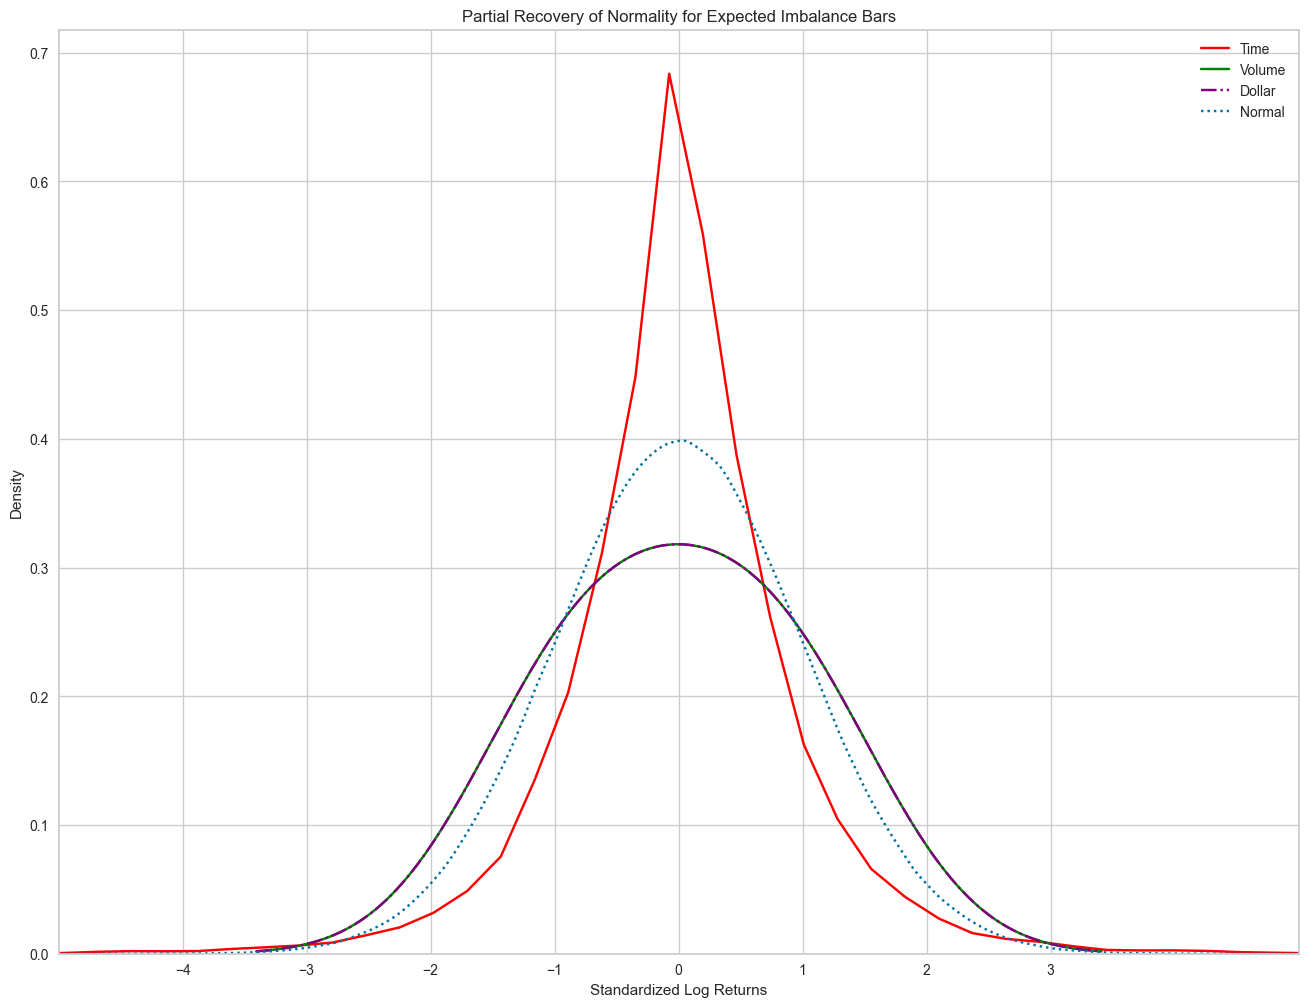

In [51]:
#Distribution Plot
plt.figure(figsize=(16, 12))
sns.kdeplot(time_standard, label="Time", color="red")
sns.kdeplot(EIB_tick_standard, label="Tick", color="blue")
sns.kdeplot(EIB_volume_standard, label="Volume", color="green")
sns.kdeplot(EIB_dollar_standard, label="Dollar", color="purple", linestyle="-.")
sns.kdeplot(np.random.normal(size=1000000), label="Normal", linestyle="dotted")
plt.xticks(range(-4, +4))

#labels
plt.xlabel("Standardized Log Returns")
plt.ylabel("Density")
plt.title(
    'Partial Recovery of Normality for Expected Imbalance Bars',
    loc='center', 
)
plt.xlim(-5, 5)
plt.legend()
plt.show()

## Run Bars

### Tick Run Bars

In [52]:
tick_run_bars = generate_info_driven_bars(sampling_method='expected_tick_run_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reload_db_resampling_params)
tick_run_bars.head()

Processing batch 0 with size 29401


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold


### Volume Run Bars

In [53]:


volume_run_bars = generate_info_driven_bars(sampling_method='expected_volume_run_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reload_db_resampling_params)
volume_run_bars.head()

Processing batch 0 with size 29401


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold


### Dollar Run Bars

In [54]:
dollar_run_bars = generate_info_driven_bars(sampling_method='expected_dollar_run_bars',
                                      df_sample=df_riskAI,
                                      db_best_params=reload_db_resampling_params)
dollar_run_bars.head()

Processing batch 0 with size 29401


,Date Time,Tick Number,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar Value,Threshold
0,2025-08-21 21:27:01.312652+00:00,5682,118251.351562,118316.007812,112029.570312,112477.546875,26679.420281,12531.694057,14147.726223,5682,3.047829e+09,8.864659e+08
1,2025-08-24 23:38:44.702653+00:00,10131,112542.843750,117409.593750,111075.546875,113601.039062,30623.208539,14744.969204,15878.239335,4449,3.510916e+09,1.817063e+09
2,2025-08-29 14:15:47.332642+00:00,16764,113486.546875,113664.000000,108415.421875,108415.421875,40630.550637,19066.407923,21564.142714,6633,4.516909e+09,2.389148e+09
3,2025-09-04 04:09:46.682659+00:00,24793,108556.000000,112559.187500,107278.429688,111272.539062,37962.182999,19009.391016,18952.791983,8029,4.154732e+09,2.081369e+09


### Statistical Test

#### Log Return

In [55]:
tick_run_bars_returns = log_return(tick_run_bars['Close'])
volume_run_bars_returns = log_return(volume_run_bars['Close'])
dollar_run_bars_returns = log_return(dollar_run_bars['Close'])

####  Jarque–Bera test statistic 

In [56]:
print("Jarque-Bera test statistic for time returns:", int(stats.jarque_bera(time_returns)[0]))
print("Jarque-Bera test statistic for tick run bars returns:", int(stats.jarque_bera(tick_run_bars_returns)[0]))
print("Jarque-Bera test statistic for volume run bars returns:", int(stats.jarque_bera(volume_run_bars_returns)[0]))
print("Jarque-Bera test statistic for dollar run bars returns:", int(stats.jarque_bera(dollar_run_bars_returns)[0]))

Jarque-Bera test statistic for time returns: 6474885


ValueError: At least one observation is required.

#### Shapiro-Wilk Test

In [ ]:
print("Shapiro-Wilk test statistic for time returns:", stats.shapiro(time_returns))
print("Shapiro-Wilk test statistic for tick run bars returns:", stats.shapiro(tick_run_bars_returns))
print("Shapiro-Wilk test statistic for volume run bars returns:", stats.shapiro(volume_run_bars_returns))
print("Shapiro-Wilk test statistic for dollar run bars returns:", stats.shapiro(dollar_run_bars_returns))

#### Kernel Density Estimate (KDE) plot

In [ ]:
#Standardize Data 
tick_run_bars_standard = (tick_run_bars_returns - tick_run_bars_returns.mean()) / tick_run_bars_returns.std()
volume_run_bars_standard = (volume_run_bars_returns  - volume_run_bars_returns.mean()) / volume_run_bars_returns.std()
dollar_run_bars_standard = (dollar_run_bars_returns - dollar_run_bars_returns.mean()) / dollar_run_bars_returns.std()

In [ ]:
#Distribution Plot
plt.figure(figsize=(16, 12))
sns.kdeplot(time_standard, label="Time", color="red")
sns.kdeplot(tick_run_bars_standard, label="Tick", color="blue")
sns.kdeplot(volume_run_bars_standard, label="Volume", color="green")
sns.kdeplot(dollar_run_bars_standard , label="Dollar", color="purple", linestyle="-.")
sns.kdeplot(np.random.normal(size=1000000), label="Normal", linestyle="dotted")
plt.xticks(range(-4, +4))

#labels
plt.xlabel("Standardized Log Returns")
plt.ylabel("Density")
plt.title(
    'Partial Recovery of Normality for Run Bars',
    loc='center', 
)
plt.xlim(-5, 5)
plt.legend()
plt.show()

# TLDR

# Future Studies

In [ ]:
# EIB_ticks = controller.handle_input_command(
#     method_name="expected_tick_imbalance_bars",
#     method_arguments={
#         "window_size_for_expected_n_ticks_estimation": 5,
#         "window_size_for_expected_imbalance_estimation": 10000,
#         "initial_estimate_of_expected_n_ticks_in_bar": 2000,
#     },
#     input_data=data,
#     batch_size=1_000_000,
# )

# #Map / Aggreagate to other features

# EIB_ticks_with_orderbook = attach_extra_features_to_bars(
#     df,
#     EIB_ticks,
#     feature_cols=features,
#     # optional overrides:
#     # agg_spec={"spot_price": "mean"},  # if you want different aggregation
#     # weighted_cols={"tr_vwap": ("tr_vwap", "tr_volume_base")},
#     drop_empty=False
# )

# EIB_ticks_with_orderbook.head()
# EIB_ticks.head()


